In [ ]:
eta = 0.1
optimizer_lr = 1e-5 # try 1e-5 from dim=2

dim = 4
n_center = 6
l = 5

num_layers = 30
width = 256

n_max_mirror_iterations= 10       # num mirror steps (for the frist and second)
n_max_iterations=6000        # max inner steps

num_samples = 10000         # number of theta generated for training
num_samples_test =  8192 # samples to estimate KL
import math
verbose = True
set_seed = 114540 # seed not used.
exp_number = 0 # [0, 1, 2, 3, 4]
pretrain_factor = 100

outer_lr_final_factor = 1e0
outer_eta_final_factor = 1e0
import math
outer_lr_factor = pow(math.e, math.log(outer_lr_final_factor)/n_max_mirror_iterations)
outer_eta_factor = pow(math.e, math.log(outer_eta_final_factor)/n_max_mirror_iterations)

In [ ]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87245 sha256=467f3907d96e6c22d70fdde6274ba94d4d79d22bb5556192f55b6cb9c90cee1e
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [ ]:
import numpy as np
import zlib
from multipledispatch import dispatch
import torch
import random

class RandomManager:
    '''
    Manage random using crc32 checksum for seeds generating
    '''

    @staticmethod
    def _get_crc32_seed(_str):
        _bstr = str.encode(_str)
        return zlib.crc32(_bstr)

    def _make_str(self, *args):
        return '@'.join(map(str, args))

    def __init__(self, *args):
        self._str = self._make_str(*args)

    def get_seed(self, *postfixes):
        _str = self._str + self._make_str(*postfixes)
        return self._get_crc32_seed(_str)

    def seed_random(self, *postfixes):
        rnd_postfixes = ('random',) + postfixes
        random.seed(self.get_seed(*rnd_postfixes))
        return self

    def seed_torch(self, *postfixes):
        torch_postfixes = ('pytorch',) + postfixes
        torch.manual_seed(self.get_seed(*torch_postfixes))
        return self

    def seed_numpy(self, *postfixes):
        np_postfixes = ('numpy',) + postfixes
        np.random.seed(self.get_seed(*np_postfixes))
        return self

    def seed(self, *postfixes):
        return self.seed_random(*postfixes).seed_numpy(*postfixes).seed_torch(*postfixes)

def get_random_manager(*args):
    return RandomManager(*args)

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch.nn.functional as F
import torch.distributions as TD
import pandas as pd
import seaborn as sb
import torch.nn as nn
import shutil
import gc
import copy
import time
from scipy.optimize import linear_sum_assignment

In [ ]:
torch.manual_seed(114514)
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [ ]:
def random_centers_distrib_generator(n, n_rand, target_span, std, device='cpu', dtype=torch.float32):
    centers_sample_distrib = TD.Uniform(-target_span, target_span)
    centers = centers_sample_distrib.sample((n_rand, n)).to(device, dtype)
    comp = TD.Independent(TD.Normal(centers, torch.tensor([std,]).to(device, dtype)), 1)
    mix = TD.Categorical(torch.ones(n_rand,).to(device, dtype))
    target = TD.MixtureSameFamily(mix, comp)
    return target

def random_project(input_data, p = 2, random_seed = 114514):
  import torch
# input_data n by m
# random_matrix m by p
# random_projected = 1/sqrt(p) * input_data %*% random_matrix
  torch.manual_seed(random_seed)
  m = input_data.shape[1]
  random_mx = torch.randn((m, p))
  projected = (1/torch.sqrt(torch.tensor(p)))*torch.matmul(input_data, random_mx)
  return projected

def plot_two_data(target_dist, model_transform):
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sb

  df_1 = pd.DataFrame(random_project(target_dist)).astype("float")
  df_2 =  pd.DataFrame(random_project(model_transform)).astype("float")

  df_1["type"] = "target dist"
  df_2["type"] = "model transform"
  df_all = pd.concat([df_1, df_2], ignore_index=True)
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)
  sns_plot = sb.jointplot(data=df_all, x="dim_0", y="dim_1", hue="type", kind="kde")
  return sns_plot

<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


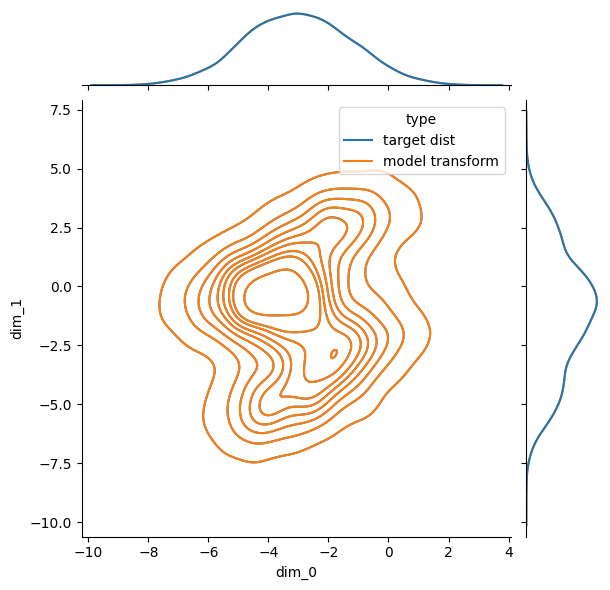

In [ ]:
r_m = get_random_manager('uran', dim, exp_number)
r_m.seed()

stationary_dist = random_centers_distrib_generator(n = dim, n_rand = n_center, target_span = l, std = 1, device=device, dtype=torch.float32)
target_samples = stationary_dist.sample((5000,))
plot_two_data(target_samples.cpu().detach(), target_samples.cpu().detach())

In [ ]:
kld1_hist = np.array([])
kld2_hist = np.array([])



trail_num = exp_number
torch.manual_seed(527)

# target_pretrain = TD.MultivariateNormal(
#     torch.zeros(dim).to(device), pretrain_factor * torch.eye(dim).to(device))
target_pretrain = TD.Uniform(-10, 10)
# Define 2D Gaussian base distribution
base = nf.distributions.DiagGaussian(dim, trainable=False)
# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(dim, mode='swap'))

# for i in range(num_layers):
#     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
#     flows += [nf.flows.LULinearPermute(dim)]

# Construct flow model
model = nf.NormalizingFlow(base, flows).to(device)
optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(100)):
    optimizer1.zero_grad()

    # Get training samples
    # x = target_pretrain.sample((num_samples,)).to(device)
    x = target_pretrain.sample((num_samples, dim)).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer1.step()

    if it % 100 == 99:
      clear_output(wait=True)
      print('Loss:', loss.item())


100%|██████████| 100/100 [00:10<00:00,  9.93it/s]

Loss: 12.622632026672363


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


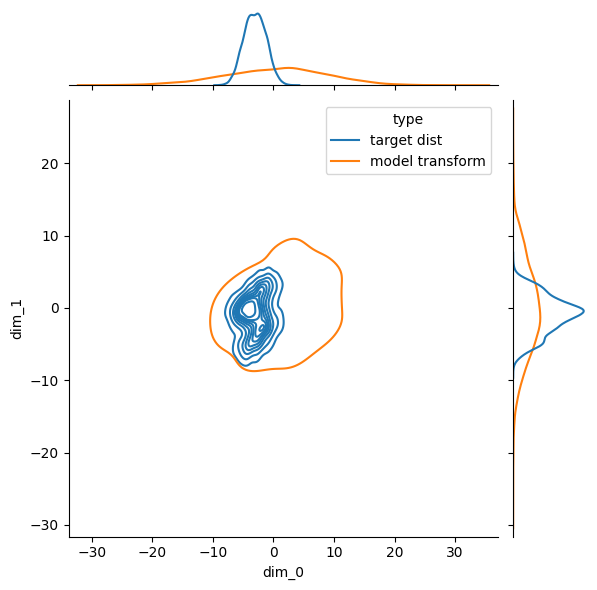

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

  2%|▏         | 100/6000 [00:29<31:30,  3.12it/s]

trail: 0 m step: 0 Loss: 23.212648391723633  L_n: 16.994834899902344  kld: 0.6217813491821289 KLD1: 17.040307998657227 KLD2: 2.9940478801727295


  3%|▎         | 200/6000 [00:58<32:03,  3.02it/s]

trail: 0 m step: 0 Loss: 20.96830654144287  L_n: 13.080275535583496  kld: 0.7888031005859375 KLD1: 12.810224533081055 KLD2: 2.7118327617645264


  5%|▌         | 300/6000 [01:29<32:41,  2.91it/s]

trail: 0 m step: 0 Loss: 19.643563270568848  L_n: 10.914830207824707  kld: 0.8728733062744141 KLD1: 11.218271255493164 KLD2: 2.5655815601348877


  7%|▋         | 400/6000 [02:00<31:28,  2.97it/s]

trail: 0 m step: 0 Loss: 19.459656715393066  L_n: 10.157784461975098  kld: 0.9301872253417969 KLD1: 10.242033004760742 KLD2: 2.4546968936920166


  8%|▊         | 500/6000 [02:30<30:44,  2.98it/s]

trail: 0 m step: 0 Loss: 19.378385543823242  L_n: 9.662866592407227  kld: 0.9715518951416016 KLD1: 9.592948913574219 KLD2: 2.39288067817688


 10%|█         | 600/6000 [03:01<30:37,  2.94it/s]

trail: 0 m step: 0 Loss: 19.29080581665039  L_n: 9.461551666259766  kld: 0.9829254150390625 KLD1: 9.461446762084961 KLD2: 2.3665080070495605


 12%|█▏        | 700/6000 [03:31<29:51,  2.96it/s]

trail: 0 m step: 0 Loss: 19.099818229675293  L_n: 9.458657264709473  kld: 0.964116096496582 KLD1: 9.580388069152832 KLD2: 2.3430378437042236


 13%|█▎        | 800/6000 [04:02<29:15,  2.96it/s]

trail: 0 m step: 0 Loss: 18.908467292785645  L_n: 9.16104793548584  kld: 0.9747419357299805 KLD1: 9.416757583618164 KLD2: 2.3035964965820312


 15%|█▌        | 900/6000 [04:33<28:45,  2.96it/s]

trail: 0 m step: 0 Loss: 19.177875518798828  L_n: 9.298744201660156  kld: 0.9879131317138672 KLD1: 9.245682716369629 KLD2: 2.3245277404785156


 17%|█▋        | 1000/6000 [05:03<28:16,  2.95it/s]

trail: 0 m step: 0 Loss: 19.009163856506348  L_n: 9.152558326721191  kld: 0.9856605529785156 KLD1: 9.273198127746582 KLD2: 2.3006744384765625


 18%|█▊        | 1100/6000 [05:34<27:51,  2.93it/s]

trail: 0 m step: 0 Loss: 19.200284957885742  L_n: 9.272449493408203  kld: 0.9927835464477539 KLD1: 9.167835235595703 KLD2: 2.275743246078491


 20%|██        | 1200/6000 [06:05<27:11,  2.94it/s]

trail: 0 m step: 0 Loss: 19.071301460266113  L_n: 9.234274864196777  kld: 0.9837026596069336 KLD1: 9.224265098571777 KLD2: 2.300623655319214


 22%|██▏       | 1300/6000 [06:35<26:31,  2.95it/s]

trail: 0 m step: 0 Loss: 18.90164852142334  L_n: 8.975749015808105  kld: 0.9925899505615234 KLD1: 9.04258918762207 KLD2: 2.294983386993408


 23%|██▎       | 1400/6000 [07:06<26:06,  2.94it/s]

trail: 0 m step: 0 Loss: 18.961098670959473  L_n: 9.066069602966309  kld: 0.9895029067993164 KLD1: 9.069100379943848 KLD2: 2.2964560985565186


 25%|██▌       | 1500/6000 [07:37<25:36,  2.93it/s]

trail: 0 m step: 0 Loss: 18.94076919555664  L_n: 8.938194274902344  kld: 1.0002574920654297 KLD1: 8.899027824401855 KLD2: 2.2613070011138916


 27%|██▋       | 1600/6000 [08:07<25:01,  2.93it/s]

trail: 0 m step: 0 Loss: 18.85328483581543  L_n: 9.041301727294922  kld: 0.9811983108520508 KLD1: 9.055578231811523 KLD2: 2.270115852355957


 28%|██▊       | 1700/6000 [08:38<24:12,  2.96it/s]

trail: 0 m step: 0 Loss: 18.76305866241455  L_n: 8.806174278259277  kld: 0.9956884384155273 KLD1: 8.865747451782227 KLD2: 2.267198324203491


 30%|███       | 1800/6000 [09:09<23:43,  2.95it/s]

trail: 0 m step: 0 Loss: 18.76736831665039  L_n: 8.76793098449707  kld: 0.999943733215332 KLD1: 8.776865005493164 KLD2: 2.258803129196167


 32%|███▏      | 1900/6000 [09:39<23:10,  2.95it/s]

trail: 0 m step: 0 Loss: 18.684860229492188  L_n: 8.940683364868164  kld: 0.9744176864624023 KLD1: 9.04615306854248 KLD2: 2.26556396484375


 33%|███▎      | 2000/6000 [10:10<22:32,  2.96it/s]

trail: 0 m step: 0 Loss: 18.983858108520508  L_n: 9.014442443847656  kld: 0.9969415664672852 KLD1: 8.764029502868652 KLD2: 2.258794069290161


 35%|███▌      | 2100/6000 [10:41<22:10,  2.93it/s]

trail: 0 m step: 0 Loss: 18.532928466796875  L_n: 8.754838943481445  kld: 0.977808952331543 KLD1: 8.951427459716797 KLD2: 2.270707845687866


 37%|███▋      | 2200/6000 [11:11<21:33,  2.94it/s]

trail: 0 m step: 0 Loss: 18.773147583007812  L_n: 8.78131103515625  kld: 0.9991836547851562 KLD1: 8.742310523986816 KLD2: 2.2805371284484863


 38%|███▊      | 2300/6000 [11:42<21:01,  2.93it/s]

trail: 0 m step: 0 Loss: 18.861501693725586  L_n: 8.818634033203125  kld: 1.004286766052246 KLD1: 8.687870979309082 KLD2: 2.2494571208953857


 40%|████      | 2400/6000 [12:13<20:19,  2.95it/s]

trail: 0 m step: 0 Loss: 18.816564559936523  L_n: 8.815906524658203  kld: 1.000065803527832 KLD1: 8.751370429992676 KLD2: 2.263770580291748


 42%|████▏     | 2500/6000 [12:44<19:48,  2.94it/s]

trail: 0 m step: 0 Loss: 18.606473922729492  L_n: 8.777973175048828  kld: 0.9828500747680664 KLD1: 8.90563678741455 KLD2: 2.2523374557495117


 43%|████▎     | 2600/6000 [13:14<19:14,  2.95it/s]

trail: 0 m step: 0 Loss: 18.67550277709961  L_n: 8.77849006652832  kld: 0.9897012710571289 KLD1: 8.790146827697754 KLD2: 2.250185012817383


 45%|████▌     | 2700/6000 [13:45<18:41,  2.94it/s]

trail: 0 m step: 0 Loss: 18.59735679626465  L_n: 8.69957160949707  kld: 0.9897785186767578 KLD1: 8.793355941772461 KLD2: 2.248333215713501


 47%|████▋     | 2800/6000 [14:16<18:05,  2.95it/s]

trail: 0 m step: 0 Loss: 18.32913303375244  L_n: 8.50599193572998  kld: 0.9823141098022461 KLD1: 8.843851089477539 KLD2: 2.233072280883789


 48%|████▊     | 2900/6000 [14:46<17:32,  2.95it/s]

trail: 0 m step: 0 Loss: 18.638020515441895  L_n: 8.76613712310791  kld: 0.9871883392333984 KLD1: 8.828214645385742 KLD2: 2.235581636428833


 50%|█████     | 3000/6000 [15:17<16:57,  2.95it/s]

trail: 0 m step: 0 Loss: 18.71272087097168  L_n: 8.783683776855469  kld: 0.9929037094116211 KLD1: 8.743436813354492 KLD2: 2.2581961154937744


 52%|█████▏    | 3100/6000 [15:48<16:25,  2.94it/s]

trail: 0 m step: 0 Loss: 18.621540069580078  L_n: 8.686304092407227  kld: 0.9935235977172852 KLD1: 8.768367767333984 KLD2: 2.2307968139648438


 53%|█████▎    | 3200/6000 [16:19<15:54,  2.93it/s]

trail: 0 m step: 0 Loss: 18.893383026123047  L_n: 8.809364318847656  kld: 1.008401870727539 KLD1: 8.569311141967773 KLD2: 2.232728958129883


 55%|█████▌    | 3300/6000 [16:49<15:19,  2.94it/s]

trail: 0 m step: 0 Loss: 18.8095121383667  L_n: 8.8848237991333  kld: 0.9924688339233398 KLD1: 8.740848541259766 KLD2: 2.2521347999572754


 57%|█████▋    | 3400/6000 [17:20<14:45,  2.94it/s]

trail: 0 m step: 0 Loss: 18.726981163024902  L_n: 8.741620063781738  kld: 0.9985361099243164 KLD1: 8.678380012512207 KLD2: 2.2334530353546143


 58%|█████▊    | 3500/6000 [17:51<14:11,  2.94it/s]

trail: 0 m step: 0 Loss: 18.790968894958496  L_n: 8.834017753601074  kld: 0.9956951141357422 KLD1: 8.703810691833496 KLD2: 2.2071468830108643


 60%|██████    | 3600/6000 [18:22<13:32,  2.95it/s]

trail: 0 m step: 0 Loss: 18.73965549468994  L_n: 8.483412742614746  kld: 1.0256242752075195 KLD1: 8.399917602539062 KLD2: 2.2069849967956543


 62%|██████▏   | 3700/6000 [18:52<13:00,  2.95it/s]

trail: 0 m step: 0 Loss: 19.017451286315918  L_n: 8.95125675201416  kld: 1.0066194534301758 KLD1: 8.64233684539795 KLD2: 2.214587688446045


 63%|██████▎   | 3800/6000 [19:23<12:24,  2.96it/s]

trail: 0 m step: 0 Loss: 18.654897689819336  L_n: 8.720176696777344  kld: 0.9934720993041992 KLD1: 8.703558921813965 KLD2: 2.1994924545288086


 65%|██████▌   | 3900/6000 [19:53<11:50,  2.96it/s]

trail: 0 m step: 0 Loss: 18.532011032104492  L_n: 8.604604721069336  kld: 0.9927406311035156 KLD1: 8.69542407989502 KLD2: 2.237668991088867


 67%|██████▋   | 4000/6000 [20:24<11:17,  2.95it/s]

trail: 0 m step: 0 Loss: 18.8234920501709  L_n: 8.861658096313477  kld: 0.9961833953857422 KLD1: 8.715557098388672 KLD2: 2.211261749267578


 68%|██████▊   | 4100/6000 [20:55<10:48,  2.93it/s]

trail: 0 m step: 0 Loss: 18.3068208694458  L_n: 8.544953346252441  kld: 0.9761867523193359 KLD1: 8.899056434631348 KLD2: 2.1994574069976807


 70%|███████   | 4200/6000 [21:26<10:10,  2.95it/s]

trail: 0 m step: 0 Loss: 18.60838794708252  L_n: 8.617695808410645  kld: 0.9990692138671875 KLD1: 8.676077842712402 KLD2: 2.21722149848938


 72%|███████▏  | 4300/6000 [21:56<09:38,  2.94it/s]

trail: 0 m step: 0 Loss: 18.936396598815918  L_n: 8.782959938049316  kld: 1.0153436660766602 KLD1: 8.517332077026367 KLD2: 2.220400333404541


 73%|███████▎  | 4400/6000 [22:27<09:03,  2.94it/s]

trail: 0 m step: 0 Loss: 18.47899341583252  L_n: 8.528546333312988  kld: 0.9950447082519531 KLD1: 8.701754570007324 KLD2: 2.1854946613311768


 75%|███████▌  | 4500/6000 [22:58<08:30,  2.94it/s]

trail: 0 m step: 0 Loss: 18.622014045715332  L_n: 8.594862937927246  kld: 1.0027151107788086 KLD1: 8.623747825622559 KLD2: 2.2000162601470947


 77%|███████▋  | 4600/6000 [23:28<07:55,  2.94it/s]

trail: 0 m step: 0 Loss: 18.912044525146484  L_n: 8.738008499145508  kld: 1.0174036026000977 KLD1: 8.465346336364746 KLD2: 2.209256172180176


 78%|███████▊  | 4700/6000 [23:59<07:21,  2.94it/s]

trail: 0 m step: 0 Loss: 18.612062454223633  L_n: 8.595802307128906  kld: 1.0016260147094727 KLD1: 8.604313850402832 KLD2: 2.2140960693359375


 80%|████████  | 4800/6000 [24:30<06:46,  2.95it/s]

trail: 0 m step: 0 Loss: 18.530882835388184  L_n: 8.452614784240723  kld: 1.007826805114746 KLD1: 8.590324401855469 KLD2: 2.19706392288208


 82%|████████▏ | 4900/6000 [25:00<06:12,  2.95it/s]

trail: 0 m step: 0 Loss: 18.464204788208008  L_n: 8.56585693359375  kld: 0.9898347854614258 KLD1: 8.743531227111816 KLD2: 2.2090137004852295


 83%|████████▎ | 5000/6000 [25:31<05:38,  2.95it/s]

trail: 0 m step: 0 Loss: 18.67583656311035  L_n: 8.591379165649414  kld: 1.0084457397460938 KLD1: 8.577425956726074 KLD2: 2.2188103199005127


 85%|████████▌ | 5100/6000 [26:02<05:06,  2.94it/s]

trail: 0 m step: 0 Loss: 18.626797676086426  L_n: 8.57528018951416  kld: 1.0051517486572266 KLD1: 8.60729694366455 KLD2: 2.2139244079589844


 87%|████████▋ | 5200/6000 [26:33<04:32,  2.94it/s]

trail: 0 m step: 0 Loss: 18.53229808807373  L_n: 8.620474815368652  kld: 0.9911823272705078 KLD1: 8.724257469177246 KLD2: 2.224721908569336


 88%|████████▊ | 5300/6000 [27:03<03:57,  2.95it/s]

trail: 0 m step: 0 Loss: 18.567458152770996  L_n: 8.638640403747559  kld: 0.9928817749023438 KLD1: 8.707138061523438 KLD2: 2.2014458179473877


 90%|█████████ | 5400/6000 [27:34<03:23,  2.95it/s]

trail: 0 m step: 0 Loss: 18.954317092895508  L_n: 8.826677322387695  kld: 1.0127639770507812 KLD1: 8.505587577819824 KLD2: 2.2035269737243652


 92%|█████████▏| 5500/6000 [28:05<02:49,  2.95it/s]

trail: 0 m step: 0 Loss: 18.666406631469727  L_n: 8.629146575927734  kld: 1.0037260055541992 KLD1: 8.608902931213379 KLD2: 2.203932046890259


 93%|█████████▎| 5600/6000 [28:35<02:16,  2.93it/s]

trail: 0 m step: 0 Loss: 18.79210090637207  L_n: 8.744989395141602  kld: 1.0047111511230469 KLD1: 8.600902557373047 KLD2: 2.2005043029785156


 95%|█████████▌| 5700/6000 [29:06<01:42,  2.94it/s]

trail: 0 m step: 0 Loss: 18.509839057922363  L_n: 8.634779930114746  kld: 0.9875059127807617 KLD1: 8.760690689086914 KLD2: 2.207169771194458


 97%|█████████▋| 5800/6000 [29:37<01:07,  2.95it/s]

trail: 0 m step: 0 Loss: 18.62698459625244  L_n: 8.720253944396973  kld: 0.9906730651855469 KLD1: 8.735970497131348 KLD2: 2.212221145629883


 98%|█████████▊| 5900/6000 [30:07<00:33,  2.94it/s]

trail: 0 m step: 0 Loss: 18.730655670166016  L_n: 8.65528678894043  kld: 1.0075368881225586 KLD1: 8.573780059814453 KLD2: 2.1968557834625244


100%|██████████| 6000/6000 [30:38<00:00,  3.26it/s]

trail: 0 m step: 0 Loss: 18.511176109313965  L_n: 8.49947452545166  kld: 1.0011701583862305 KLD1: 8.640454292297363 KLD2: 2.1972358226776123



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


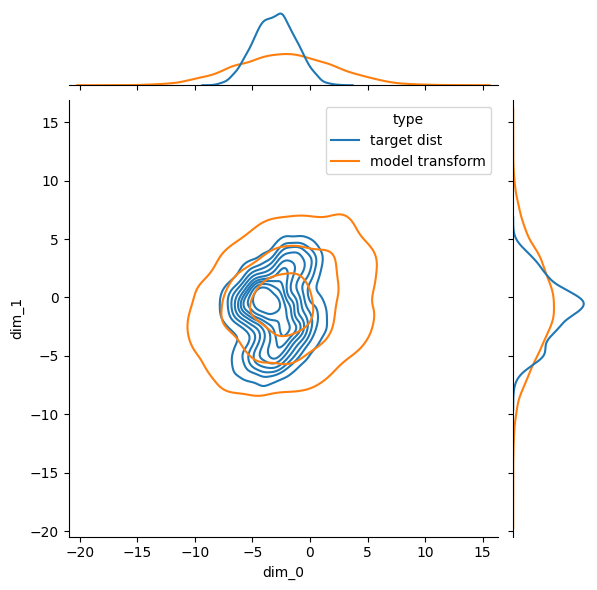

trail: 0 m step: 0 kl_test: 8.634757041931152


  2%|▏         | 100/6000 [00:30<33:42,  2.92it/s]

trail: 0 m step: 1 Loss: 6.014720916748047  L_n: 4.521152496337891  kld: 0.14935684204101562 KLD1: 4.511775493621826 KLD2: 1.6518479585647583


  3%|▎         | 200/6000 [01:01<32:40,  2.96it/s]

trail: 0 m step: 1 Loss: 6.0402326583862305  L_n: 4.314387321472168  kld: 0.17258453369140625 KLD1: 4.247948169708252 KLD2: 1.5824189186096191


  5%|▌         | 300/6000 [01:32<32:08,  2.96it/s]

trail: 0 m step: 1 Loss: 5.795014381408691  L_n: 4.185431480407715  kld: 0.16095829010009766 KLD1: 4.329502582550049 KLD2: 1.5969675779342651


  7%|▋         | 400/6000 [02:02<31:47,  2.94it/s]

trail: 0 m step: 1 Loss: 5.931670188903809  L_n: 4.2382307052612305  kld: 0.1693439483642578 KLD1: 4.249805927276611 KLD2: 1.5780152082443237


  8%|▊         | 500/6000 [02:33<31:02,  2.95it/s]

trail: 0 m step: 1 Loss: 5.962555885314941  L_n: 4.222348213195801  kld: 0.17402076721191406 KLD1: 4.161022663116455 KLD2: 1.586456060409546


 10%|█         | 600/6000 [03:04<30:31,  2.95it/s]

trail: 0 m step: 1 Loss: 5.930385589599609  L_n: 4.201116561889648  kld: 0.1729269027709961 KLD1: 4.187873363494873 KLD2: 1.5797218084335327


 12%|█▏        | 700/6000 [03:34<29:58,  2.95it/s]

trail: 0 m step: 1 Loss: 5.861397743225098  L_n: 4.242297172546387  kld: 0.1619100570678711 KLD1: 4.2751336097717285 KLD2: 1.575113296508789


 13%|█▎        | 800/6000 [04:05<29:20,  2.95it/s]

trail: 0 m step: 1 Loss: 5.726321220397949  L_n: 4.071677207946777  kld: 0.1654644012451172 KLD1: 4.22837495803833 KLD2: 1.5489627122879028


 15%|█▌        | 900/6000 [04:35<28:44,  2.96it/s]

trail: 0 m step: 1 Loss: 5.957021713256836  L_n: 4.214649200439453  kld: 0.17423725128173828 KLD1: 4.14315128326416 KLD2: 1.567270040512085


 17%|█▋        | 1000/6000 [05:06<28:21,  2.94it/s]

trail: 0 m step: 1 Loss: 5.84860897064209  L_n: 4.149323463439941  kld: 0.16992855072021484 KLD1: 4.18216609954834 KLD2: 1.5543118715286255


 18%|█▊        | 1100/6000 [05:37<27:46,  2.94it/s]

trail: 0 m step: 1 Loss: 5.894954681396484  L_n: 4.164941787719727  kld: 0.17300128936767578 KLD1: 4.13243293762207 KLD2: 1.5262112617492676


 20%|██        | 1200/6000 [06:08<27:11,  2.94it/s]

trail: 0 m step: 1 Loss: 5.93614387512207  L_n: 4.237916946411133  kld: 0.16982269287109375 KLD1: 4.18438196182251 KLD2: 1.5591719150543213


 22%|██▏       | 1300/6000 [06:38<26:35,  2.95it/s]

trail: 0 m step: 1 Loss: 5.839502334594727  L_n: 4.060565948486328  kld: 0.17789363861083984 KLD1: 4.102044582366943 KLD2: 1.5460373163223267


 23%|██▎       | 1400/6000 [07:09<26:05,  2.94it/s]

trail: 0 m step: 1 Loss: 5.903059959411621  L_n: 4.190604209899902  kld: 0.17124557495117188 KLD1: 4.161184310913086 KLD2: 1.5632964372634888


 25%|██▌       | 1500/6000 [07:40<25:29,  2.94it/s]

trail: 0 m step: 1 Loss: 5.910138130187988  L_n: 4.163464546203613  kld: 0.1746673583984375 KLD1: 4.141202926635742 KLD2: 1.537613034248352


 27%|██▋       | 1600/6000 [08:11<24:53,  2.95it/s]

trail: 0 m step: 1 Loss: 5.904202461242676  L_n: 4.182562828063965  kld: 0.1721639633178711 KLD1: 4.151744842529297 KLD2: 1.530806064605713


 28%|██▊       | 1700/6000 [08:41<24:20,  2.94it/s]

trail: 0 m step: 1 Loss: 5.810006141662598  L_n: 4.081299781799316  kld: 0.17287063598632812 KLD1: 4.143234729766846 KLD2: 1.541089653968811


 30%|███       | 1800/6000 [09:12<23:44,  2.95it/s]

trail: 0 m step: 1 Loss: 5.876696586608887  L_n: 4.1167192459106445  kld: 0.17599773406982422 KLD1: 4.100337505340576 KLD2: 1.5304830074310303


 32%|███▏      | 1900/6000 [09:43<23:12,  2.94it/s]

trail: 0 m step: 1 Loss: 5.833331108093262  L_n: 4.239712715148926  kld: 0.1593618392944336 KLD1: 4.2948832511901855 KLD2: 1.5461211204528809


 33%|███▎      | 2000/6000 [10:13<22:38,  2.94it/s]

trail: 0 m step: 1 Loss: 5.975893974304199  L_n: 4.233263969421387  kld: 0.17426300048828125 KLD1: 4.122719764709473 KLD2: 1.531287431716919


 35%|███▌      | 2100/6000 [10:44<22:06,  2.94it/s]

trail: 0 m step: 1 Loss: 5.763100624084473  L_n: 4.1076459884643555  kld: 0.16554546356201172 KLD1: 4.207502841949463 KLD2: 1.546402931213379


 37%|███▋      | 2200/6000 [11:15<21:30,  2.94it/s]

trail: 0 m step: 1 Loss: 5.895389556884766  L_n: 4.154180526733398  kld: 0.17412090301513672 KLD1: 4.1313958168029785 KLD2: 1.5610125064849854


 38%|███▊      | 2300/6000 [11:45<20:54,  2.95it/s]

trail: 0 m step: 1 Loss: 5.939250946044922  L_n: 4.174228668212891  kld: 0.17650222778320312 KLD1: 4.119170665740967 KLD2: 1.531489610671997


 40%|████      | 2400/6000 [12:16<20:22,  2.95it/s]

trail: 0 m step: 1 Loss: 5.918670654296875  L_n: 4.184804916381836  kld: 0.1733865737915039 KLD1: 4.1262335777282715 KLD2: 1.5478923320770264


 42%|████▏     | 2500/6000 [12:47<19:49,  2.94it/s]

trail: 0 m step: 1 Loss: 5.81343936920166  L_n: 4.1385393142700195  kld: 0.16749000549316406 KLD1: 4.18807315826416 KLD2: 1.5341517925262451


 43%|████▎     | 2600/6000 [13:17<19:14,  2.95it/s]

trail: 0 m step: 1 Loss: 5.851188659667969  L_n: 4.132543563842773  kld: 0.17186450958251953 KLD1: 4.1373114585876465 KLD2: 1.532293677330017


 45%|████▌     | 2700/6000 [13:48<18:39,  2.95it/s]

trail: 0 m step: 1 Loss: 5.785832405090332  L_n: 4.103646278381348  kld: 0.16821861267089844 KLD1: 4.171905517578125 KLD2: 1.530648946762085


 47%|████▋     | 2800/6000 [14:19<18:07,  2.94it/s]

trail: 0 m step: 1 Loss: 5.691285133361816  L_n: 4.022564888000488  kld: 0.1668720245361328 KLD1: 4.1613450050354 KLD2: 1.5218256711959839


 48%|████▊     | 2900/6000 [14:50<17:32,  2.95it/s]

trail: 0 m step: 1 Loss: 5.814172744750977  L_n: 4.157106399536133  kld: 0.16570663452148438 KLD1: 4.185537338256836 KLD2: 1.5262739658355713


 50%|█████     | 3000/6000 [15:20<16:59,  2.94it/s]

trail: 0 m step: 1 Loss: 5.868499755859375  L_n: 4.141557693481445  kld: 0.17269420623779297 KLD1: 4.125942707061768 KLD2: 1.5443693399429321


 52%|█████▏    | 3100/6000 [15:51<16:21,  2.96it/s]

trail: 0 m step: 1 Loss: 5.819643974304199  L_n: 4.076460838317871  kld: 0.1743183135986328 KLD1: 4.115413665771484 KLD2: 1.520572304725647


 53%|█████▎    | 3200/6000 [16:22<15:52,  2.94it/s]

trail: 0 m step: 1 Loss: 5.990597724914551  L_n: 4.178149223327637  kld: 0.1812448501586914 KLD1: 4.035285949707031 KLD2: 1.5277830362319946


 55%|█████▌    | 3300/6000 [16:52<15:18,  2.94it/s]

trail: 0 m step: 1 Loss: 5.941620826721191  L_n: 4.21993350982666  kld: 0.17216873168945312 KLD1: 4.129006862640381 KLD2: 1.5432889461517334


 57%|█████▋    | 3400/6000 [17:23<14:41,  2.95it/s]

trail: 0 m step: 1 Loss: 5.903471946716309  L_n: 4.150084495544434  kld: 0.1753387451171875 KLD1: 4.088314056396484 KLD2: 1.5289058685302734


 58%|█████▊    | 3500/6000 [17:54<14:06,  2.95it/s]

trail: 0 m step: 1 Loss: 5.906352996826172  L_n: 4.162883758544922  kld: 0.174346923828125 KLD1: 4.113224983215332 KLD2: 1.5059359073638916


 60%|██████    | 3600/6000 [18:24<13:35,  2.94it/s]

trail: 0 m step: 1 Loss: 5.875825881958008  L_n: 3.995075225830078  kld: 0.18807506561279297 KLD1: 3.972860336303711 KLD2: 1.5123780965805054


 62%|██████▏   | 3700/6000 [18:55<12:59,  2.95it/s]

trail: 0 m step: 1 Loss: 6.041831970214844  L_n: 4.2618560791015625  kld: 0.17799758911132812 KLD1: 4.081092834472656 KLD2: 1.5149139165878296


 63%|██████▎   | 3800/6000 [19:26<12:29,  2.94it/s]

trail: 0 m step: 1 Loss: 5.867311477661133  L_n: 4.169456481933594  kld: 0.1697854995727539 KLD1: 4.141223907470703 KLD2: 1.506287932395935


 65%|██████▌   | 3900/6000 [19:57<11:53,  2.94it/s]

trail: 0 m step: 1 Loss: 5.785091400146484  L_n: 4.037006378173828  kld: 0.17480850219726562 KLD1: 4.0807061195373535 KLD2: 1.5274723768234253


 67%|██████▋   | 4000/6000 [20:27<11:18,  2.95it/s]

trail: 0 m step: 1 Loss: 5.931155204772949  L_n: 4.190918922424316  kld: 0.17402362823486328 KLD1: 4.128286838531494 KLD2: 1.5125200748443604


 68%|██████▊   | 4100/6000 [20:58<10:46,  2.94it/s]

trail: 0 m step: 1 Loss: 5.665615081787109  L_n: 4.063642501831055  kld: 0.16019725799560547 KLD1: 4.260497570037842 KLD2: 1.5072786808013916


 70%|███████   | 4200/6000 [21:29<10:12,  2.94it/s]

trail: 0 m step: 1 Loss: 5.811814308166504  L_n: 4.06742000579834  kld: 0.1744394302368164 KLD1: 4.12002420425415 KLD2: 1.5154699087142944


 72%|███████▏  | 4300/6000 [21:59<09:38,  2.94it/s]

trail: 0 m step: 1 Loss: 5.980599403381348  L_n: 4.172852516174316  kld: 0.18077468872070312 KLD1: 4.056004047393799 KLD2: 1.5226770639419556


 73%|███████▎  | 4400/6000 [22:30<09:03,  2.94it/s]

trail: 0 m step: 1 Loss: 5.782003402709961  L_n: 4.045095443725586  kld: 0.1736907958984375 KLD1: 4.113986015319824 KLD2: 1.491400122642517


 75%|███████▌  | 4500/6000 [23:01<08:29,  2.95it/s]

trail: 0 m step: 1 Loss: 5.832588195800781  L_n: 4.072725296020508  kld: 0.17598628997802734 KLD1: 4.09885835647583 KLD2: 1.5054723024368286


 77%|███████▋  | 4600/6000 [23:31<07:55,  2.95it/s]

trail: 0 m step: 1 Loss: 5.973616600036621  L_n: 4.135495185852051  kld: 0.18381214141845703 KLD1: 4.0060224533081055 KLD2: 1.5162941217422485


 78%|███████▊  | 4700/6000 [24:02<07:21,  2.95it/s]

trail: 0 m step: 1 Loss: 5.834362030029297  L_n: 4.086353302001953  kld: 0.17480087280273438 KLD1: 4.084993839263916 KLD2: 1.5192228555679321


 80%|████████  | 4800/6000 [24:33<06:46,  2.95it/s]

trail: 0 m step: 1 Loss: 5.784375190734863  L_n: 4.017102241516113  kld: 0.176727294921875 KLD1: 4.088602066040039 KLD2: 1.5056614875793457


 82%|████████▏ | 4900/6000 [25:04<06:14,  2.94it/s]

trail: 0 m step: 1 Loss: 5.748126029968262  L_n: 4.091851234436035  kld: 0.16562747955322266 KLD1: 4.1904706954956055 KLD2: 1.5167878866195679


 83%|████████▎ | 5000/6000 [25:34<05:41,  2.93it/s]

trail: 0 m step: 1 Loss: 5.84808349609375  L_n: 4.08203125  kld: 0.176605224609375 KLD1: 4.0891194343566895 KLD2: 1.5253509283065796


 85%|████████▌ | 5100/6000 [26:05<05:05,  2.94it/s]

trail: 0 m step: 1 Loss: 5.8153076171875  L_n: 4.044153213500977  kld: 0.17711544036865234 KLD1: 4.070801258087158 KLD2: 1.5170044898986816


 87%|████████▋ | 5200/6000 [26:36<04:31,  2.94it/s]

trail: 0 m step: 1 Loss: 5.784257888793945  L_n: 4.085020065307617  kld: 0.1699237823486328 KLD1: 4.14725399017334 KLD2: 1.5293784141540527


 88%|████████▊ | 5300/6000 [27:06<03:57,  2.95it/s]

trail: 0 m step: 1 Loss: 5.822488784790039  L_n: 4.099208831787109  kld: 0.17232799530029297 KLD1: 4.111362457275391 KLD2: 1.506300687789917


 90%|█████████ | 5400/6000 [27:37<03:23,  2.95it/s]

trail: 0 m step: 1 Loss: 6.017756462097168  L_n: 4.205145835876465  kld: 0.1812610626220703 KLD1: 4.028675556182861 KLD2: 1.509737253189087


 92%|█████████▏| 5500/6000 [28:08<02:49,  2.95it/s]

trail: 0 m step: 1 Loss: 5.874579429626465  L_n: 4.082339286804199  kld: 0.17922401428222656 KLD1: 4.057435512542725 KLD2: 1.507489562034607


 93%|█████████▎| 5600/6000 [28:38<02:15,  2.95it/s]

trail: 0 m step: 1 Loss: 5.921385765075684  L_n: 4.1366987228393555  kld: 0.1784687042236328 KLD1: 4.061864852905273 KLD2: 1.5047929286956787


 95%|█████████▌| 5700/6000 [29:09<01:41,  2.95it/s]

trail: 0 m step: 1 Loss: 5.779613494873047  L_n: 4.087909698486328  kld: 0.16917037963867188 KLD1: 4.156496047973633 KLD2: 1.512993574142456


 97%|█████████▋| 5800/6000 [29:40<01:08,  2.94it/s]

trail: 0 m step: 1 Loss: 5.831764221191406  L_n: 4.150045394897461  kld: 0.16817188262939453 KLD1: 4.170296669006348 KLD2: 1.5189294815063477


 98%|█████████▊| 5900/6000 [30:11<00:33,  2.94it/s]

trail: 0 m step: 1 Loss: 5.899799346923828  L_n: 4.105794906616211  kld: 0.17940044403076172 KLD1: 4.065502166748047 KLD2: 1.5052822828292847


100%|██████████| 6000/6000 [30:41<00:00,  3.26it/s]

trail: 0 m step: 1 Loss: 5.7748613357543945  L_n: 4.031659126281738  kld: 0.17432022094726562 KLD1: 4.107100009918213 KLD2: 1.5092835426330566



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


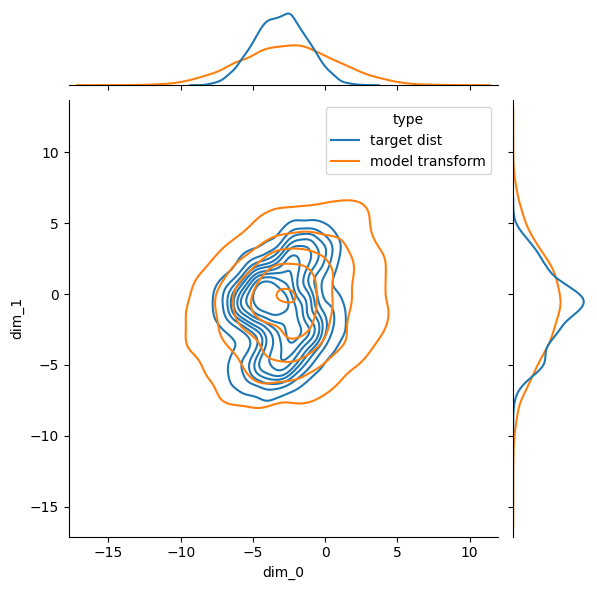

trail: 0 m step: 1 kl_test: 4.121048927307129


  2%|▏         | 100/6000 [00:30<33:54,  2.90it/s]

trail: 0 m step: 2 Loss: 3.2218074798583984  L_n: 2.6451873779296875  kld: 0.057662010192871094 KLD1: 2.64111328125 KLD2: 1.2031441926956177


  3%|▎         | 200/6000 [01:01<32:51,  2.94it/s]

trail: 0 m step: 2 Loss: 3.2352981567382812  L_n: 2.532773971557617  kld: 0.0702524185180664 KLD1: 2.4970593452453613 KLD2: 1.1531805992126465


  5%|▌         | 300/6000 [01:32<32:18,  2.94it/s]

trail: 0 m step: 2 Loss: 3.093174934387207  L_n: 2.4608983993530273  kld: 0.06322765350341797 KLD1: 2.5601463317871094 KLD2: 1.1643673181533813


  7%|▋         | 400/6000 [02:03<31:53,  2.93it/s]

trail: 0 m step: 2 Loss: 3.196722984313965  L_n: 2.512843132019043  kld: 0.06838798522949219 KLD1: 2.512749433517456 KLD2: 1.150239109992981


  8%|▊         | 500/6000 [02:34<31:20,  2.92it/s]

trail: 0 m step: 2 Loss: 3.215386390686035  L_n: 2.4950952529907227  kld: 0.07202911376953125 KLD1: 2.449413776397705 KLD2: 1.1578222513198853


 10%|█         | 600/6000 [03:04<30:40,  2.93it/s]

trail: 0 m step: 2 Loss: 3.1897201538085938  L_n: 2.5187721252441406  kld: 0.06709480285644531 KLD1: 2.5086467266082764 KLD2: 1.161123275756836


 12%|█▏        | 700/6000 [03:35<30:05,  2.94it/s]

trail: 0 m step: 2 Loss: 3.1559276580810547  L_n: 2.5564098358154297  kld: 0.0599517822265625 KLD1: 2.5809898376464844 KLD2: 1.1545939445495605


 13%|█▎        | 800/6000 [04:06<29:31,  2.94it/s]

trail: 0 m step: 2 Loss: 3.0621471405029297  L_n: 2.4299087524414062  kld: 0.06322383880615234 KLD1: 2.5308356285095215 KLD2: 1.1342893838882446


 15%|█▌        | 900/6000 [04:37<28:50,  2.95it/s]

trail: 0 m step: 2 Loss: 3.210892677307129  L_n: 2.5189828872680664  kld: 0.06919097900390625 KLD1: 2.4713783264160156 KLD2: 1.151154637336731


 17%|█▋        | 1000/6000 [05:08<28:21,  2.94it/s]

trail: 0 m step: 2 Loss: 3.14231014251709  L_n: 2.490292549133301  kld: 0.0652017593383789 KLD1: 2.5193428993225098 KLD2: 1.1410791873931885


 18%|█▊        | 1100/6000 [05:38<27:49,  2.94it/s]

trail: 0 m step: 2 Loss: 3.173290252685547  L_n: 2.486673355102539  kld: 0.06866168975830078 KLD1: 2.461622953414917 KLD2: 1.1153136491775513


 20%|██        | 1200/6000 [06:09<27:15,  2.93it/s]

trail: 0 m step: 2 Loss: 3.209153175354004  L_n: 2.565871238708496  kld: 0.06432819366455078 KLD1: 2.5232956409454346 KLD2: 1.1480152606964111


 22%|██▏       | 1300/6000 [06:40<26:39,  2.94it/s]

trail: 0 m step: 2 Loss: 3.13802433013916  L_n: 2.43210506439209  kld: 0.07059192657470703 KLD1: 2.4617905616760254 KLD2: 1.137749195098877


 23%|██▎       | 1400/6000 [07:11<26:04,  2.94it/s]

trail: 0 m step: 2 Loss: 3.189725875854492  L_n: 2.519550323486328  kld: 0.0670175552368164 KLD1: 2.5043892860412598 KLD2: 1.150539755821228


 25%|██▌       | 1500/6000 [07:42<25:35,  2.93it/s]

trail: 0 m step: 2 Loss: 3.190511703491211  L_n: 2.4968185424804688  kld: 0.06936931610107422 KLD1: 2.47821307182312 KLD2: 1.1270333528518677


 27%|██▋       | 1600/6000 [08:12<24:55,  2.94it/s]

trail: 0 m step: 2 Loss: 3.194639205932617  L_n: 2.508890151977539  kld: 0.06857490539550781 KLD1: 2.486374855041504 KLD2: 1.1179120540618896


 28%|██▊       | 1700/6000 [08:43<24:19,  2.95it/s]

trail: 0 m step: 2 Loss: 3.123006820678711  L_n: 2.454538345336914  kld: 0.06684684753417969 KLD1: 2.488041400909424 KLD2: 1.1327697038650513


 30%|███       | 1800/6000 [09:14<23:53,  2.93it/s]

trail: 0 m step: 2 Loss: 3.1820764541625977  L_n: 2.4415769577026367  kld: 0.0740499496459961 KLD1: 2.4151995182037354 KLD2: 1.1139318943023682


 32%|███▏      | 1900/6000 [09:45<23:16,  2.94it/s]

trail: 0 m step: 2 Loss: 3.141925811767578  L_n: 2.5493316650390625  kld: 0.05925941467285156 KLD1: 2.585268974304199 KLD2: 1.132570505142212


 33%|███▎      | 2000/6000 [10:15<22:47,  2.92it/s]

trail: 0 m step: 2 Loss: 3.2325735092163086  L_n: 2.5468626022338867  kld: 0.06857109069824219 KLD1: 2.472229242324829 KLD2: 1.1221660375595093


 35%|███▌      | 2100/6000 [10:46<22:07,  2.94it/s]

trail: 0 m step: 2 Loss: 3.0935802459716797  L_n: 2.4723472595214844  kld: 0.06212329864501953 KLD1: 2.535525321960449 KLD2: 1.1401231288909912


 37%|███▋      | 2200/6000 [11:17<21:30,  2.94it/s]

trail: 0 m step: 2 Loss: 3.1868972778320312  L_n: 2.506603240966797  kld: 0.06802940368652344 KLD1: 2.4802043437957764 KLD2: 1.1523957252502441


 38%|███▊      | 2300/6000 [11:48<20:59,  2.94it/s]

trail: 0 m step: 2 Loss: 3.2057247161865234  L_n: 2.5026092529296875  kld: 0.0703115463256836 KLD1: 2.466826915740967 KLD2: 1.1227614879608154


 40%|████      | 2400/6000 [12:19<20:23,  2.94it/s]

trail: 0 m step: 2 Loss: 3.1904258728027344  L_n: 2.524465560913086  kld: 0.06659603118896484 KLD1: 2.4814257621765137 KLD2: 1.1420987844467163


 42%|████▏     | 2500/6000 [12:50<19:52,  2.93it/s]

trail: 0 m step: 2 Loss: 3.133697509765625  L_n: 2.483949661254883  kld: 0.06497478485107422 KLD1: 2.5068283081054688 KLD2: 1.126286506652832


 43%|████▎     | 2600/6000 [13:20<19:19,  2.93it/s]

trail: 0 m step: 2 Loss: 3.161929130554199  L_n: 2.489912986755371  kld: 0.06720161437988281 KLD1: 2.480069398880005 KLD2: 1.1268699169158936


 45%|████▌     | 2700/6000 [13:51<18:46,  2.93it/s]

trail: 0 m step: 2 Loss: 3.101898193359375  L_n: 2.444272994995117  kld: 0.06576251983642578 KLD1: 2.488370418548584 KLD2: 1.1214207410812378


 47%|████▋     | 2800/6000 [14:22<18:10,  2.93it/s]

trail: 0 m step: 2 Loss: 3.05808162689209  L_n: 2.414952278137207  kld: 0.06431293487548828 KLD1: 2.4908523559570312 KLD2: 1.1179052591323853


 48%|████▊     | 2900/6000 [14:53<17:35,  2.94it/s]

trail: 0 m step: 2 Loss: 3.132744789123535  L_n: 2.494574546813965  kld: 0.06381702423095703 KLD1: 2.5080621242523193 KLD2: 1.1195707321166992


 50%|█████     | 3000/6000 [15:23<17:03,  2.93it/s]

trail: 0 m step: 2 Loss: 3.1630477905273438  L_n: 2.4800548553466797  kld: 0.0682992935180664 KLD1: 2.4753713607788086 KLD2: 1.1367121934890747


 52%|█████▏    | 3100/6000 [15:54<16:34,  2.92it/s]

trail: 0 m step: 2 Loss: 3.132265090942383  L_n: 2.434328079223633  kld: 0.069793701171875 KLD1: 2.460493564605713 KLD2: 1.1167300939559937


 53%|█████▎    | 3200/6000 [16:25<15:57,  2.92it/s]

trail: 0 m step: 2 Loss: 3.240281105041504  L_n: 2.515164375305176  kld: 0.07251167297363281 KLD1: 2.41926646232605 KLD2: 1.126551866531372


 55%|█████▌    | 3300/6000 [16:56<15:22,  2.93it/s]

trail: 0 m step: 2 Loss: 3.2109479904174805  L_n: 2.535231590270996  kld: 0.06757164001464844 KLD1: 2.472245216369629 KLD2: 1.1382198333740234


 57%|█████▋    | 3400/6000 [17:27<14:46,  2.93it/s]

trail: 0 m step: 2 Loss: 3.186330795288086  L_n: 2.490053176879883  kld: 0.06962776184082031 KLD1: 2.4511921405792236 KLD2: 1.1262719631195068


 58%|█████▊    | 3500/6000 [17:58<14:10,  2.94it/s]

trail: 0 m step: 2 Loss: 3.188614845275879  L_n: 2.505154609680176  kld: 0.06834602355957031 KLD1: 2.4800937175750732 KLD2: 1.1077808141708374


 60%|██████    | 3600/6000 [18:28<13:40,  2.93it/s]

trail: 0 m step: 2 Loss: 3.165238380432129  L_n: 2.391798973083496  kld: 0.07734394073486328 KLD1: 2.3862454891204834 KLD2: 1.1119439601898193


 62%|██████▏   | 3700/6000 [18:59<13:03,  2.94it/s]

trail: 0 m step: 2 Loss: 3.278660774230957  L_n: 2.56716251373291  kld: 0.07114982604980469 KLD1: 2.440260410308838 KLD2: 1.11433744430542


 63%|██████▎   | 3800/6000 [19:30<12:40,  2.89it/s]

trail: 0 m step: 2 Loss: 3.168654441833496  L_n: 2.5136804580688477  kld: 0.06549739837646484 KLD1: 2.4914586544036865 KLD2: 1.108313798904419


 65%|██████▌   | 3900/6000 [20:01<11:54,  2.94it/s]

trail: 0 m step: 2 Loss: 3.1192750930786133  L_n: 2.4268503189086914  kld: 0.06924247741699219 KLD1: 2.449246406555176 KLD2: 1.1264077425003052


 67%|██████▋   | 4000/6000 [20:32<11:23,  2.93it/s]

trail: 0 m step: 2 Loss: 3.196932792663574  L_n: 2.5095338821411133  kld: 0.0687398910522461 KLD1: 2.475867986679077 KLD2: 1.1118727922439575


 68%|██████▊   | 4100/6000 [21:02<10:46,  2.94it/s]

trail: 0 m step: 2 Loss: 3.037660598754883  L_n: 2.454021453857422  kld: 0.058363914489746094 KLD1: 2.576148271560669 KLD2: 1.1092453002929688


 70%|███████   | 4200/6000 [21:33<10:13,  2.93it/s]

trail: 0 m step: 2 Loss: 3.1169309616088867  L_n: 2.440241813659668  kld: 0.06766891479492188 KLD1: 2.482025146484375 KLD2: 1.1145784854888916


 72%|███████▏  | 4300/6000 [22:04<09:36,  2.95it/s]

trail: 0 m step: 2 Loss: 3.224562644958496  L_n: 2.5013532638549805  kld: 0.07232093811035156 KLD1: 2.430619239807129 KLD2: 1.1197978258132935


 73%|███████▎  | 4400/6000 [22:35<09:02,  2.95it/s]

trail: 0 m step: 2 Loss: 3.116426467895508  L_n: 2.429676055908203  kld: 0.06867504119873047 KLD1: 2.468892812728882 KLD2: 1.0935016870498657


 75%|███████▌  | 4500/6000 [23:06<08:32,  2.93it/s]

trail: 0 m step: 2 Loss: 3.138859748840332  L_n: 2.434943199157715  kld: 0.07039165496826172 KLD1: 2.454437017440796 KLD2: 1.1055656671524048


 77%|███████▋  | 4600/6000 [23:36<07:56,  2.94it/s]

trail: 0 m step: 2 Loss: 3.2286148071289062  L_n: 2.478616714477539  kld: 0.07499980926513672 KLD1: 2.3989107608795166 KLD2: 1.116060733795166


 78%|███████▊  | 4700/6000 [24:07<07:23,  2.93it/s]

trail: 0 m step: 2 Loss: 3.148625373840332  L_n: 2.450516700744629  kld: 0.06981086730957031 KLD1: 2.450355291366577 KLD2: 1.118220329284668


 80%|████████  | 4800/6000 [24:38<06:49,  2.93it/s]

trail: 0 m step: 2 Loss: 3.1078853607177734  L_n: 2.4077835083007812  kld: 0.07001018524169922 KLD1: 2.4540154933929443 KLD2: 1.1074928045272827


 82%|████████▏ | 4900/6000 [25:09<06:15,  2.93it/s]

trail: 0 m step: 2 Loss: 3.0973873138427734  L_n: 2.468477249145508  kld: 0.06289100646972656 KLD1: 2.5252199172973633 KLD2: 1.1160080432891846


 83%|████████▎ | 5000/6000 [25:40<05:39,  2.94it/s]

trail: 0 m step: 2 Loss: 3.1454639434814453  L_n: 2.4521427154541016  kld: 0.06933212280273438 KLD1: 2.455918788909912 KLD2: 1.125218152999878


 85%|████████▌ | 5100/6000 [26:10<05:07,  2.93it/s]

trail: 0 m step: 2 Loss: 3.1260147094726562  L_n: 2.4216785430908203  kld: 0.0704336166381836 KLD1: 2.436584234237671 KLD2: 1.1171951293945312


 87%|████████▋ | 5200/6000 [26:41<04:32,  2.93it/s]

trail: 0 m step: 2 Loss: 3.108323097229004  L_n: 2.454073905944824  kld: 0.06542491912841797 KLD1: 2.493716239929199 KLD2: 1.1296015977859497


 88%|████████▊ | 5300/6000 [27:12<03:56,  2.95it/s]

trail: 0 m step: 2 Loss: 3.13582706451416  L_n: 2.455552101135254  kld: 0.06802749633789062 KLD1: 2.4606029987335205 KLD2: 1.1070352792739868


 90%|█████████ | 5400/6000 [27:43<03:25,  2.93it/s]

trail: 0 m step: 2 Loss: 3.2700586318969727  L_n: 2.5394678115844727  kld: 0.07305908203125 KLD1: 2.4154021739959717 KLD2: 1.1111785173416138


 92%|█████████▏| 5500/6000 [28:14<02:50,  2.94it/s]

trail: 0 m step: 2 Loss: 3.163632392883301  L_n: 2.446793556213379  kld: 0.07168388366699219 KLD1: 2.4337236881256104 KLD2: 1.1093186140060425


 93%|█████████▎| 5600/6000 [28:44<02:15,  2.95it/s]

trail: 0 m step: 2 Loss: 3.201565742492676  L_n: 2.4812936782836914  kld: 0.07202720642089844 KLD1: 2.4311623573303223 KLD2: 1.1061439514160156


 95%|█████████▌| 5700/6000 [29:15<01:41,  2.95it/s]

trail: 0 m step: 2 Loss: 3.1029558181762695  L_n: 2.44997501373291  kld: 0.06529808044433594 KLD1: 2.4933292865753174 KLD2: 1.1138496398925781


 97%|█████████▋| 5800/6000 [29:46<01:08,  2.94it/s]

trail: 0 m step: 2 Loss: 3.1344985961914062  L_n: 2.490224838256836  kld: 0.06442737579345703 KLD1: 2.5056521892547607 KLD2: 1.1186628341674805


 98%|█████████▊| 5900/6000 [30:17<00:33,  2.94it/s]

trail: 0 m step: 2 Loss: 3.178709030151367  L_n: 2.4617843627929688  kld: 0.07169246673583984 KLD1: 2.4419939517974854 KLD2: 1.1080507040023804


100%|██████████| 6000/6000 [30:47<00:00,  3.25it/s]

trail: 0 m step: 2 Loss: 3.1010332107543945  L_n: 2.4149789810180664  kld: 0.06860542297363281 KLD1: 2.4624698162078857 KLD2: 1.1114381551742554



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


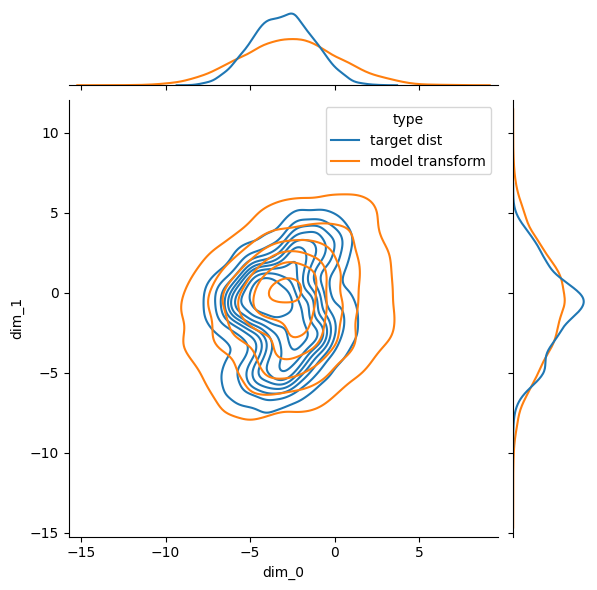

trail: 0 m step: 2 kl_test: 2.483896255493164


  2%|▏         | 100/6000 [00:30<33:58,  2.89it/s]

trail: 0 m step: 3 Loss: 2.034656524658203  L_n: 1.7512435913085938  kld: 0.028341293334960938 KLD1: 1.7558600902557373 KLD2: 0.912330150604248


  3%|▎         | 200/6000 [01:01<32:46,  2.95it/s]

trail: 0 m step: 3 Loss: 2.052922248840332  L_n: 1.6940641403198242  kld: 0.03588581085205078 KLD1: 1.6702615022659302 KLD2: 0.8745097517967224


  5%|▌         | 300/6000 [01:32<32:19,  2.94it/s]

trail: 0 m step: 3 Loss: 1.9470148086547852  L_n: 1.6194276809692383  kld: 0.03275871276855469 KLD1: 1.705810308456421 KLD2: 0.882349967956543


  7%|▋         | 400/6000 [02:03<31:38,  2.95it/s]

trail: 0 m step: 3 Loss: 2.0318450927734375  L_n: 1.6543712615966797  kld: 0.03774738311767578 KLD1: 1.6557167768478394 KLD2: 0.8665257692337036


  8%|▊         | 500/6000 [02:33<31:06,  2.95it/s]

trail: 0 m step: 3 Loss: 2.0495128631591797  L_n: 1.6566085815429688  kld: 0.039290428161621094 KLD1: 1.6175464391708374 KLD2: 0.8754869103431702


 10%|█         | 600/6000 [03:04<30:32,  2.95it/s]

trail: 0 m step: 3 Loss: 2.027477264404297  L_n: 1.685537338256836  kld: 0.034193992614746094 KLD1: 1.6791634559631348 KLD2: 0.8836228251457214


 12%|█▏        | 700/6000 [03:35<30:04,  2.94it/s]

trail: 0 m step: 3 Loss: 2.0106143951416016  L_n: 1.7216320037841797  kld: 0.028898239135742188 KLD1: 1.7421925067901611 KLD2: 0.8781352043151855


 13%|█▎        | 800/6000 [04:06<29:31,  2.94it/s]

trail: 0 m step: 3 Loss: 1.9318952560424805  L_n: 1.6179933547973633  kld: 0.03139019012451172 KLD1: 1.6910232305526733 KLD2: 0.8602617979049683


 15%|█▌        | 900/6000 [04:36<28:50,  2.95it/s]

trail: 0 m step: 3 Loss: 2.042081832885742  L_n: 1.694305419921875  kld: 0.03477764129638672 KLD1: 1.6601569652557373 KLD2: 0.8780914545059204


 17%|█▋        | 1000/6000 [05:07<28:19,  2.94it/s]

trail: 0 m step: 3 Loss: 1.9908533096313477  L_n: 1.6545114517211914  kld: 0.033634185791015625 KLD1: 1.6790156364440918 KLD2: 0.8657130599021912


 18%|█▊        | 1100/6000 [05:38<27:45,  2.94it/s]

trail: 0 m step: 3 Loss: 2.024667739868164  L_n: 1.6767101287841797  kld: 0.03479576110839844 KLD1: 1.651914358139038 KLD2: 0.8475872874259949


 20%|██        | 1200/6000 [06:08<27:13,  2.94it/s]

trail: 0 m step: 3 Loss: 2.0484180450439453  L_n: 1.7259330749511719  kld: 0.032248497009277344 KLD1: 1.6936097145080566 KLD2: 0.8765079975128174


 22%|██▏       | 1300/6000 [06:39<26:33,  2.95it/s]

trail: 0 m step: 3 Loss: 1.9886417388916016  L_n: 1.6171951293945312  kld: 0.03714466094970703 KLD1: 1.643075942993164 KLD2: 0.8651309609413147


 23%|██▎       | 1400/6000 [07:10<26:06,  2.94it/s]

trail: 0 m step: 3 Loss: 2.024728775024414  L_n: 1.6764183044433594  kld: 0.03483104705810547 KLD1: 1.6678087711334229 KLD2: 0.876175582408905


 25%|██▌       | 1500/6000 [07:41<25:28,  2.94it/s]

trail: 0 m step: 3 Loss: 2.0315608978271484  L_n: 1.6729698181152344  kld: 0.035859107971191406 KLD1: 1.6511530876159668 KLD2: 0.857510507106781


 27%|██▋       | 1600/6000 [08:11<24:54,  2.94it/s]

trail: 0 m step: 3 Loss: 2.034364700317383  L_n: 1.6726837158203125  kld: 0.03616809844970703 KLD1: 1.6581802368164062 KLD2: 0.8471580147743225


 28%|██▊       | 1700/6000 [08:42<24:15,  2.95it/s]

trail: 0 m step: 3 Loss: 1.987100601196289  L_n: 1.6499099731445312  kld: 0.03371906280517578 KLD1: 1.6605910062789917 KLD2: 0.8635159134864807


 30%|███       | 1800/6000 [09:13<23:49,  2.94it/s]

trail: 0 m step: 3 Loss: 2.03546142578125  L_n: 1.6332778930664062  kld: 0.040218353271484375 KLD1: 1.5994582176208496 KLD2: 0.8467918634414673


 32%|███▏      | 1900/6000 [09:44<23:17,  2.93it/s]

trail: 0 m step: 3 Loss: 1.9922990798950195  L_n: 1.705815315246582  kld: 0.02864837646484375 KLD1: 1.7336347103118896 KLD2: 0.8613669872283936


 33%|███▎      | 2000/6000 [10:14<22:43,  2.93it/s]

trail: 0 m step: 3 Loss: 2.0551719665527344  L_n: 1.6987266540527344  kld: 0.03564453125 KLD1: 1.6458804607391357 KLD2: 0.853229284286499


 35%|███▌      | 2100/6000 [10:45<22:06,  2.94it/s]

trail: 0 m step: 3 Loss: 1.9584531784057617  L_n: 1.6544885635375977  kld: 0.030396461486816406 KLD1: 1.6949182748794556 KLD2: 0.8711541891098022


 37%|███▋      | 2200/6000 [11:16<21:31,  2.94it/s]

trail: 0 m step: 3 Loss: 2.0317792892456055  L_n: 1.6794633865356445  kld: 0.035231590270996094 KLD1: 1.6481436491012573 KLD2: 0.8819450736045837


 38%|███▊      | 2300/6000 [11:47<20:59,  2.94it/s]

trail: 0 m step: 3 Loss: 2.039052963256836  L_n: 1.6718692779541016  kld: 0.03671836853027344 KLD1: 1.6444743871688843 KLD2: 0.8542637228965759


 40%|████      | 2400/6000 [12:18<20:23,  2.94it/s]

trail: 0 m step: 3 Loss: 2.020425796508789  L_n: 1.686697006225586  kld: 0.03337287902832031 KLD1: 1.6591964960098267 KLD2: 0.8722377419471741


 42%|████▏     | 2500/6000 [12:48<19:52,  2.93it/s]

trail: 0 m step: 3 Loss: 1.9885644912719727  L_n: 1.656895637512207  kld: 0.03316688537597656 KLD1: 1.6716771125793457 KLD2: 0.8576204180717468


 43%|████▎     | 2600/6000 [13:19<19:13,  2.95it/s]

trail: 0 m step: 3 Loss: 2.0146350860595703  L_n: 1.6682987213134766  kld: 0.034633636474609375 KLD1: 1.655291199684143 KLD2: 0.8591659665107727


 45%|████▌     | 2700/6000 [13:50<18:44,  2.94it/s]

trail: 0 m step: 3 Loss: 1.9697933197021484  L_n: 1.6309242248535156  kld: 0.03388690948486328 KLD1: 1.6547601222991943 KLD2: 0.8542923331260681


 47%|████▋     | 2800/6000 [14:21<18:15,  2.92it/s]

trail: 0 m step: 3 Loss: 1.9360361099243164  L_n: 1.6086397171020508  kld: 0.03273963928222656 KLD1: 1.6597166061401367 KLD2: 0.8512699007987976


 48%|████▊     | 2900/6000 [14:52<17:33,  2.94it/s]

trail: 0 m step: 3 Loss: 1.9950733184814453  L_n: 1.666351318359375  kld: 0.03287220001220703 KLD1: 1.669503092765808 KLD2: 0.8521044850349426


 50%|█████     | 3000/6000 [15:22<17:03,  2.93it/s]

trail: 0 m step: 3 Loss: 2.011943817138672  L_n: 1.6530952453613281  kld: 0.035884857177734375 KLD1: 1.6504671573638916 KLD2: 0.8676308393478394


 52%|█████▏    | 3100/6000 [15:53<16:26,  2.94it/s]

trail: 0 m step: 3 Loss: 1.9895763397216797  L_n: 1.61822509765625  kld: 0.03713512420654297 KLD1: 1.6357313394546509 KLD2: 0.8500117659568787


 53%|█████▎    | 3200/6000 [16:24<15:54,  2.93it/s]

trail: 0 m step: 3 Loss: 2.0641279220581055  L_n: 1.6789865493774414  kld: 0.038514137268066406 KLD1: 1.6096696853637695 KLD2: 0.8603798747062683


 55%|█████▌    | 3300/6000 [16:55<15:21,  2.93it/s]

trail: 0 m step: 3 Loss: 2.0476484298706055  L_n: 1.697535514831543  kld: 0.03501129150390625 KLD1: 1.6501796245574951 KLD2: 0.8707437515258789


 57%|█████▋    | 3400/6000 [17:25<14:47,  2.93it/s]

trail: 0 m step: 3 Loss: 2.024550437927246  L_n: 1.6666936874389648  kld: 0.035785675048828125 KLD1: 1.6367239952087402 KLD2: 0.8616968393325806


 58%|█████▊    | 3500/6000 [17:56<14:12,  2.93it/s]

trail: 0 m step: 3 Loss: 2.035215377807617  L_n: 1.6836528778076172  kld: 0.03515625 KLD1: 1.6601709127426147 KLD2: 0.8444499969482422


 60%|██████    | 3600/6000 [18:27<13:36,  2.94it/s]

trail: 0 m step: 3 Loss: 2.010896682739258  L_n: 1.5931205749511719  kld: 0.041777610778808594 KLD1: 1.5909310579299927 KLD2: 0.8471372723579407


 62%|██████▏   | 3700/6000 [18:58<13:04,  2.93it/s]

trail: 0 m step: 3 Loss: 2.096480369567871  L_n: 1.7204370498657227  kld: 0.037604331970214844 KLD1: 1.6182445287704468 KLD2: 0.8491603136062622


 63%|██████▎   | 3800/6000 [19:29<12:29,  2.93it/s]

trail: 0 m step: 3 Loss: 2.0115556716918945  L_n: 1.6782941818237305  kld: 0.033326148986816406 KLD1: 1.667942762374878 KLD2: 0.8448959589004517


 65%|██████▌   | 3900/6000 [19:59<11:55,  2.94it/s]

trail: 0 m step: 3 Loss: 1.9802627563476562  L_n: 1.623159408569336  kld: 0.03571033477783203 KLD1: 1.6356174945831299 KLD2: 0.8617032170295715


 67%|██████▋   | 4000/6000 [20:30<11:20,  2.94it/s]

trail: 0 m step: 3 Loss: 2.030247688293457  L_n: 1.677311897277832  kld: 0.0352935791015625 KLD1: 1.6499699354171753 KLD2: 0.8477990031242371


 68%|██████▊   | 4100/6000 [21:01<10:48,  2.93it/s]

trail: 0 m step: 3 Loss: 1.9192447662353516  L_n: 1.642965316772461  kld: 0.027627944946289062 KLD1: 1.7323065996170044 KLD2: 0.8457472324371338


 70%|███████   | 4200/6000 [21:32<10:12,  2.94it/s]

trail: 0 m step: 3 Loss: 1.9705352783203125  L_n: 1.6300640106201172  kld: 0.03404712677001953 KLD1: 1.6644973754882812 KLD2: 0.8504692316055298


 72%|███████▏  | 4300/6000 [22:03<09:39,  2.93it/s]

trail: 0 m step: 3 Loss: 2.047534942626953  L_n: 1.6699466705322266  kld: 0.037758827209472656 KLD1: 1.6190752983093262 KLD2: 0.8537657856941223


 73%|███████▎  | 4400/6000 [22:33<09:06,  2.93it/s]

trail: 0 m step: 3 Loss: 1.9827451705932617  L_n: 1.6223993301391602  kld: 0.036034584045410156 KLD1: 1.6507302522659302 KLD2: 0.8311454653739929


 75%|███████▌  | 4500/6000 [23:04<08:28,  2.95it/s]

trail: 0 m step: 3 Loss: 1.9871454238891602  L_n: 1.6187219619750977  kld: 0.03684234619140625 KLD1: 1.6320513486862183 KLD2: 0.8414987921714783


 77%|███████▋  | 4600/6000 [23:35<07:57,  2.93it/s]

trail: 0 m step: 3 Loss: 2.0574188232421875  L_n: 1.6514301300048828  kld: 0.04059886932373047 KLD1: 1.597528338432312 KLD2: 0.8512076139450073


 78%|███████▊  | 4700/6000 [24:06<07:20,  2.95it/s]

trail: 0 m step: 3 Loss: 2.006028175354004  L_n: 1.6371183395385742  kld: 0.03689098358154297 KLD1: 1.6365232467651367 KLD2: 0.8524128794670105


 80%|████████  | 4800/6000 [24:36<06:47,  2.95it/s]

trail: 0 m step: 3 Loss: 1.9670085906982422  L_n: 1.6019515991210938  kld: 0.036505699157714844 KLD1: 1.6375635862350464 KLD2: 0.8441867232322693


 82%|████████▏ | 4900/6000 [25:07<06:11,  2.96it/s]

trail: 0 m step: 3 Loss: 1.9694814682006836  L_n: 1.654311180114746  kld: 0.03151702880859375 KLD1: 1.6891472339630127 KLD2: 0.850600004196167


 83%|████████▎ | 5000/6000 [25:38<05:39,  2.95it/s]

trail: 0 m step: 3 Loss: 1.9916629791259766  L_n: 1.6335773468017578  kld: 0.035808563232421875 KLD1: 1.6403911113739014 KLD2: 0.859952986240387


 85%|████████▌ | 5100/6000 [26:08<05:04,  2.95it/s]

trail: 0 m step: 3 Loss: 1.9787817001342773  L_n: 1.6112165451049805  kld: 0.03675651550292969 KLD1: 1.6232057809829712 KLD2: 0.8526460528373718


 87%|████████▋ | 5200/6000 [26:39<04:31,  2.94it/s]

trail: 0 m step: 3 Loss: 1.9618091583251953  L_n: 1.63629150390625  kld: 0.03255176544189453 KLD1: 1.6710124015808105 KLD2: 0.8646308183670044


 88%|████████▊ | 5300/6000 [27:10<03:57,  2.94it/s]

trail: 0 m step: 3 Loss: 1.9915075302124023  L_n: 1.6351289749145508  kld: 0.035637855529785156 KLD1: 1.639552354812622 KLD2: 0.842986524105072


 90%|█████████ | 5400/6000 [27:41<03:24,  2.94it/s]

trail: 0 m step: 3 Loss: 2.091543197631836  L_n: 1.7070884704589844  kld: 0.038445472717285156 KLD1: 1.6144518852233887 KLD2: 0.8475366830825806


 92%|█████████▏| 5500/6000 [28:12<02:50,  2.93it/s]

trail: 0 m step: 3 Loss: 2.0057554244995117  L_n: 1.629521369934082  kld: 0.03762340545654297 KLD1: 1.626412034034729 KLD2: 0.8464096188545227


 93%|█████████▎| 5600/6000 [28:42<02:16,  2.94it/s]

trail: 0 m step: 3 Loss: 2.044367790222168  L_n: 1.6596269607543945  kld: 0.038474082946777344 KLD1: 1.6205672025680542 KLD2: 0.8422421813011169


 95%|█████████▌| 5700/6000 [29:13<01:42,  2.93it/s]

trail: 0 m step: 3 Loss: 1.9727897644042969  L_n: 1.6384696960449219  kld: 0.0334320068359375 KLD1: 1.6647900342941284 KLD2: 0.849408745765686


 97%|█████████▋| 5800/6000 [29:44<01:07,  2.95it/s]

trail: 0 m step: 3 Loss: 1.9814605712890625  L_n: 1.656209945678711  kld: 0.032525062561035156 KLD1: 1.6742308139801025 KLD2: 0.8533484935760498


 98%|█████████▊| 5900/6000 [30:15<00:33,  2.95it/s]

trail: 0 m step: 3 Loss: 2.015155792236328  L_n: 1.6436710357666016  kld: 0.037148475646972656 KLD1: 1.631352186203003 KLD2: 0.8446840643882751


100%|██████████| 6000/6000 [30:45<00:00,  3.25it/s]

trail: 0 m step: 3 Loss: 1.962590217590332  L_n: 1.611495018005371  kld: 0.035109519958496094 KLD1: 1.6461812257766724 KLD2: 0.8477264642715454



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


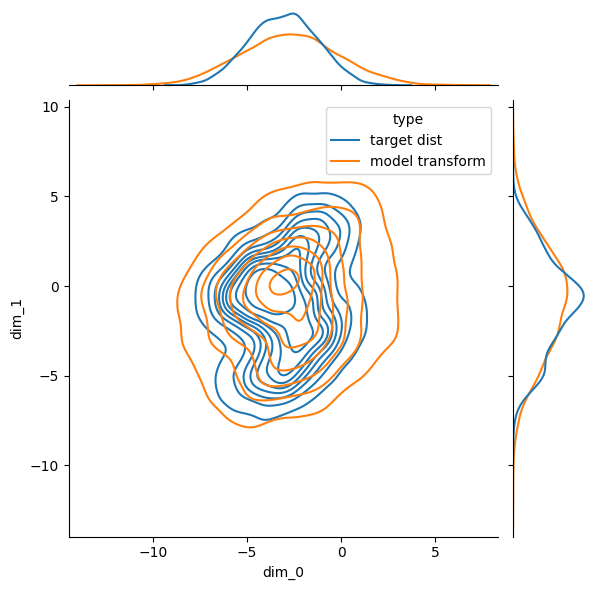

trail: 0 m step: 3 kl_test: 1.6627044677734375


  2%|▏         | 100/6000 [00:30<33:55,  2.90it/s]

trail: 0 m step: 4 Loss: 1.3958826065063477  L_n: 1.2403860092163086  kld: 0.015549659729003906 KLD1: 1.2512348890304565 KLD2: 0.7109001278877258


  3%|▎         | 200/6000 [01:01<32:53,  2.94it/s]

trail: 0 m step: 4 Loss: 1.4180707931518555  L_n: 1.1977434158325195  kld: 0.022032737731933594 KLD1: 1.176923155784607 KLD2: 0.6748871803283691


  5%|▌         | 300/6000 [01:32<32:23,  2.93it/s]

trail: 0 m step: 4 Loss: 1.3346996307373047  L_n: 1.1486949920654297  kld: 0.0186004638671875 KLD1: 1.2203415632247925 KLD2: 0.6887401938438416


  7%|▋         | 400/6000 [02:03<31:47,  2.94it/s]

trail: 0 m step: 4 Loss: 1.400376319885254  L_n: 1.1653146743774414  kld: 0.02350616455078125 KLD1: 1.1654512882232666 KLD2: 0.6714328527450562


  8%|▊         | 500/6000 [02:34<31:15,  2.93it/s]

trail: 0 m step: 4 Loss: 1.4222297668457031  L_n: 1.1707077026367188  kld: 0.025152206420898438 KLD1: 1.132228136062622 KLD2: 0.678402841091156


 10%|█         | 600/6000 [03:04<30:37,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3996076583862305  L_n: 1.1971330642700195  kld: 0.020247459411621094 KLD1: 1.191904067993164 KLD2: 0.6886789798736572


 12%|█▏        | 700/6000 [03:35<30:03,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3892955780029297  L_n: 1.2286109924316406  kld: 0.016068458557128906 KLD1: 1.245654582977295 KLD2: 0.6839951872825623


 13%|█▎        | 800/6000 [04:06<29:26,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3238592147827148  L_n: 1.143519401550293  kld: 0.018033981323242188 KLD1: 1.198197841644287 KLD2: 0.6681118011474609


 15%|█▌        | 900/6000 [04:37<28:48,  2.95it/s]

trail: 0 m step: 4 Loss: 1.4145050048828125  L_n: 1.204000473022461  kld: 0.021050453186035156 KLD1: 1.175598382949829 KLD2: 0.6835934519767761


 17%|█▋        | 1000/6000 [05:07<28:21,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3713645935058594  L_n: 1.1700057983398438  kld: 0.020135879516601562 KLD1: 1.1885745525360107 KLD2: 0.6732009649276733


 18%|█▊        | 1100/6000 [05:38<27:41,  2.95it/s]

trail: 0 m step: 4 Loss: 1.4031829833984375  L_n: 1.1922492980957031  kld: 0.021093368530273438 KLD1: 1.1708605289459229 KLD2: 0.6575918197631836


 20%|██        | 1200/6000 [06:09<27:17,  2.93it/s]

trail: 0 m step: 4 Loss: 1.4174385070800781  L_n: 1.232797622680664  kld: 0.018464088439941406 KLD1: 1.2080594301223755 KLD2: 0.686495304107666


 22%|██▏       | 1300/6000 [06:39<26:37,  2.94it/s]

trail: 0 m step: 4 Loss: 1.366368293762207  L_n: 1.1413869857788086  kld: 0.022498130798339844 KLD1: 1.1666178703308105 KLD2: 0.6741637587547302


 23%|██▎       | 1400/6000 [07:10<26:02,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3937139511108398  L_n: 1.1847352981567383  kld: 0.020897865295410156 KLD1: 1.1803478002548218 KLD2: 0.6837257742881775


 25%|██▌       | 1500/6000 [07:41<25:32,  2.94it/s]

trail: 0 m step: 4 Loss: 1.4013385772705078  L_n: 1.1873817443847656  kld: 0.02139568328857422 KLD1: 1.168553113937378 KLD2: 0.666723906993866


 27%|██▋       | 1600/6000 [08:12<24:56,  2.94it/s]

trail: 0 m step: 4 Loss: 1.4034862518310547  L_n: 1.184255599975586  kld: 0.021923065185546875 KLD1: 1.1764839887619019 KLD2: 0.6576471328735352


 28%|██▊       | 1700/6000 [08:42<24:23,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3747901916503906  L_n: 1.1789913177490234  kld: 0.01957988739013672 KLD1: 1.1810483932495117 KLD2: 0.6745468378067017


 30%|███       | 1800/6000 [09:13<23:51,  2.93it/s]

trail: 0 m step: 4 Loss: 1.4148874282836914  L_n: 1.164433479309082  kld: 0.025045394897460938 KLD1: 1.1283122301101685 KLD2: 0.6598716378211975


 32%|███▏      | 1900/6000 [09:44<23:15,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3719377517700195  L_n: 1.2109384536743164  kld: 0.016099929809570312 KLD1: 1.234904408454895 KLD2: 0.6708571910858154


 33%|███▎      | 2000/6000 [10:15<22:42,  2.94it/s]

trail: 0 m step: 4 Loss: 1.4161510467529297  L_n: 1.203643798828125  kld: 0.02125072479248047 KLD1: 1.1670833826065063 KLD2: 0.6642650961875916


 35%|███▌      | 2100/6000 [10:46<22:10,  2.93it/s]

trail: 0 m step: 4 Loss: 1.3475065231323242  L_n: 1.175797462463379  kld: 0.01717090606689453 KLD1: 1.2061296701431274 KLD2: 0.6811445951461792


 37%|███▋      | 2200/6000 [11:16<21:33,  2.94it/s]

trail: 0 m step: 4 Loss: 1.4063701629638672  L_n: 1.193319320678711  kld: 0.021305084228515625 KLD1: 1.164148211479187 KLD2: 0.690632164478302


 38%|███▊      | 2300/6000 [11:47<20:59,  2.94it/s]

trail: 0 m step: 4 Loss: 1.409306526184082  L_n: 1.1894464492797852  kld: 0.021986007690429688 KLD1: 1.1689190864562988 KLD2: 0.6661533117294312


 40%|████      | 2400/6000 [12:18<20:26,  2.93it/s]

trail: 0 m step: 4 Loss: 1.3883123397827148  L_n: 1.194411277770996  kld: 0.019390106201171875 KLD1: 1.178000569343567 KLD2: 0.6810062527656555


 42%|████▏     | 2500/6000 [12:49<19:48,  2.95it/s]

trail: 0 m step: 4 Loss: 1.3696489334106445  L_n: 1.1730871200561523  kld: 0.01965618133544922 KLD1: 1.1852011680603027 KLD2: 0.6683031320571899


 43%|████▎     | 2600/6000 [13:19<19:15,  2.94it/s]

trail: 0 m step: 4 Loss: 1.392843246459961  L_n: 1.187021255493164  kld: 0.020582199096679688 KLD1: 1.1734707355499268 KLD2: 0.6701949238777161


 45%|████▌     | 2700/6000 [13:50<18:39,  2.95it/s]

trail: 0 m step: 4 Loss: 1.362776756286621  L_n: 1.159510612487793  kld: 0.020326614379882812 KLD1: 1.1696622371673584 KLD2: 0.6664974689483643


 47%|████▋     | 2800/6000 [14:21<18:10,  2.93it/s]

trail: 0 m step: 4 Loss: 1.3309698104858398  L_n: 1.1387758255004883  kld: 0.019219398498535156 KLD1: 1.1788636445999146 KLD2: 0.6632621884346008


 48%|████▊     | 2900/6000 [14:52<17:36,  2.93it/s]

trail: 0 m step: 4 Loss: 1.3790197372436523  L_n: 1.1832304000854492  kld: 0.019578933715820312 KLD1: 1.1812199354171753 KLD2: 0.6635347604751587


 50%|█████     | 3000/6000 [15:22<17:03,  2.93it/s]

trail: 0 m step: 4 Loss: 1.3927421569824219  L_n: 1.1736736297607422  kld: 0.02190685272216797 KLD1: 1.1675801277160645 KLD2: 0.6777397394180298


 52%|█████▏    | 3100/6000 [15:53<16:24,  2.95it/s]

trail: 0 m step: 4 Loss: 1.3730039596557617  L_n: 1.146315574645996  kld: 0.022668838500976562 KLD1: 1.1524897813796997 KLD2: 0.6620778441429138


 53%|█████▎    | 3200/6000 [16:24<15:52,  2.94it/s]

trail: 0 m step: 4 Loss: 1.424546241760254  L_n: 1.189732551574707  kld: 0.023481369018554688 KLD1: 1.1368123292922974 KLD2: 0.6722728610038757


 55%|█████▌    | 3300/6000 [16:54<15:16,  2.95it/s]

trail: 0 m step: 4 Loss: 1.4196243286132812  L_n: 1.210073471069336  kld: 0.02095508575439453 KLD1: 1.1729884147644043 KLD2: 0.6815629005432129


 57%|█████▋    | 3400/6000 [17:25<14:43,  2.94it/s]

trail: 0 m step: 4 Loss: 1.4002513885498047  L_n: 1.1893558502197266  kld: 0.021089553833007812 KLD1: 1.1640368700027466 KLD2: 0.6741520166397095


 58%|█████▊    | 3500/6000 [17:56<14:08,  2.95it/s]

trail: 0 m step: 4 Loss: 1.4107704162597656  L_n: 1.2032413482666016  kld: 0.020752906799316406 KLD1: 1.1793252229690552 KLD2: 0.6583864092826843


 60%|██████    | 3600/6000 [18:27<13:40,  2.92it/s]

trail: 0 m step: 4 Loss: 1.3864564895629883  L_n: 1.125483512878418  kld: 0.02609729766845703 KLD1: 1.1247448921203613 KLD2: 0.6600921154022217


 62%|██████▏   | 3700/6000 [18:57<13:05,  2.93it/s]

trail: 0 m step: 4 Loss: 1.4490795135498047  L_n: 1.2195301055908203  kld: 0.022954940795898438 KLD1: 1.1425719261169434 KLD2: 0.6612305045127869


 63%|██████▎   | 3800/6000 [19:28<12:26,  2.95it/s]

trail: 0 m step: 4 Loss: 1.3855085372924805  L_n: 1.191206932067871  kld: 0.019430160522460938 KLD1: 1.1859509944915771 KLD2: 0.6583582758903503


 65%|██████▌   | 3900/6000 [19:59<11:52,  2.95it/s]

trail: 0 m step: 4 Loss: 1.3636226654052734  L_n: 1.1527748107910156  kld: 0.02108478546142578 KLD1: 1.1594644784927368 KLD2: 0.6743950247764587


 67%|██████▋   | 4000/6000 [20:29<11:18,  2.95it/s]

trail: 0 m step: 4 Loss: 1.3996992111206055  L_n: 1.191349983215332  kld: 0.020834922790527344 KLD1: 1.1710622310638428 KLD2: 0.6612625122070312


 68%|██████▊   | 4100/6000 [21:00<10:44,  2.95it/s]

trail: 0 m step: 4 Loss: 1.3182878494262695  L_n: 1.1681699752807617  kld: 0.015011787414550781 KLD1: 1.2352701425552368 KLD2: 0.6593446135520935


 70%|███████   | 4200/6000 [21:31<10:11,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3507003784179688  L_n: 1.1553592681884766  kld: 0.01953411102294922 KLD1: 1.1850900650024414 KLD2: 0.6640195846557617


 72%|███████▏  | 4300/6000 [22:02<09:38,  2.94it/s]

trail: 0 m step: 4 Loss: 1.413177490234375  L_n: 1.1843719482421875  kld: 0.02288055419921875 KLD1: 1.1484286785125732 KLD2: 0.6655314564704895


 73%|███████▎  | 4400/6000 [22:32<09:05,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3711957931518555  L_n: 1.1540632247924805  kld: 0.0217132568359375 KLD1: 1.1708745956420898 KLD2: 0.6460266709327698


 75%|███████▌  | 4500/6000 [23:03<08:29,  2.94it/s]

trail: 0 m step: 4 Loss: 1.371500015258789  L_n: 1.1472244262695312  kld: 0.02242755889892578 KLD1: 1.1543115377426147 KLD2: 0.6551719307899475


 77%|███████▋  | 4600/6000 [23:34<07:55,  2.94it/s]

trail: 0 m step: 4 Loss: 1.4200162887573242  L_n: 1.1709260940551758  kld: 0.024909019470214844 KLD1: 1.1267982721328735 KLD2: 0.6644185781478882


 78%|███████▊  | 4700/6000 [24:04<07:20,  2.95it/s]

trail: 0 m step: 4 Loss: 1.3842573165893555  L_n: 1.1624040603637695  kld: 0.022185325622558594 KLD1: 1.1617276668548584 KLD2: 0.6645674705505371


 80%|████████  | 4800/6000 [24:35<06:48,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3460149765014648  L_n: 1.1288347244262695  kld: 0.02171802520751953 KLD1: 1.1604971885681152 KLD2: 0.6579822301864624


 82%|████████▏ | 4900/6000 [25:06<06:14,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3596839904785156  L_n: 1.1766929626464844  kld: 0.018299102783203125 KLD1: 1.1977866888046265 KLD2: 0.6627766489982605


 83%|████████▎ | 5000/6000 [25:37<05:40,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3676681518554688  L_n: 1.1558856964111328  kld: 0.021178245544433594 KLD1: 1.1625815629959106 KLD2: 0.6722022294998169


 85%|████████▌ | 5100/6000 [26:07<05:05,  2.94it/s]

trail: 0 m step: 4 Loss: 1.358769416809082  L_n: 1.1375551223754883  kld: 0.022121429443359375 KLD1: 1.1530776023864746 KLD2: 0.6652796268463135


 87%|████████▋ | 5200/6000 [26:38<04:32,  2.94it/s]

trail: 0 m step: 4 Loss: 1.344477653503418  L_n: 1.1591787338256836  kld: 0.018529891967773438 KLD1: 1.191249966621399 KLD2: 0.6762058138847351


 88%|████████▊ | 5300/6000 [27:09<03:58,  2.93it/s]

trail: 0 m step: 4 Loss: 1.371363639831543  L_n: 1.1556520462036133  kld: 0.02157115936279297 KLD1: 1.156839370727539 KLD2: 0.6564515233039856


 90%|█████████ | 5400/6000 [27:40<03:24,  2.94it/s]

trail: 0 m step: 4 Loss: 1.450240135192871  L_n: 1.2190313339233398  kld: 0.023120880126953125 KLD1: 1.143393874168396 KLD2: 0.6613365411758423


 92%|█████████▏| 5500/6000 [28:11<02:50,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3807315826416016  L_n: 1.1551017761230469  kld: 0.02256298065185547 KLD1: 1.1526927947998047 KLD2: 0.660308837890625


 93%|█████████▎| 5600/6000 [28:41<02:16,  2.93it/s]

trail: 0 m step: 4 Loss: 1.4188203811645508  L_n: 1.1831388473510742  kld: 0.023568153381347656 KLD1: 1.1462599039077759 KLD2: 0.6556668877601624


 95%|█████████▌| 5700/6000 [29:12<01:42,  2.94it/s]

trail: 0 m step: 4 Loss: 1.3590564727783203  L_n: 1.1628475189208984  kld: 0.019620895385742188 KLD1: 1.182160496711731 KLD2: 0.6622287631034851


 97%|█████████▋| 5800/6000 [29:43<01:08,  2.94it/s]

trail: 0 m step: 4 Loss: 1.355093002319336  L_n: 1.1658744812011719  kld: 0.018921852111816406 KLD1: 1.1900339126586914 KLD2: 0.6654473543167114


 98%|█████████▊| 5900/6000 [30:14<00:33,  2.95it/s]

trail: 0 m step: 4 Loss: 1.391535758972168  L_n: 1.1686716079711914  kld: 0.022286415100097656 KLD1: 1.1600556373596191 KLD2: 0.6579978466033936


100%|██████████| 6000/6000 [30:44<00:00,  3.25it/s]

trail: 0 m step: 4 Loss: 1.3521108627319336  L_n: 1.1447057723999023  kld: 0.020740509033203125 KLD1: 1.1699199676513672 KLD2: 0.6609438061714172



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


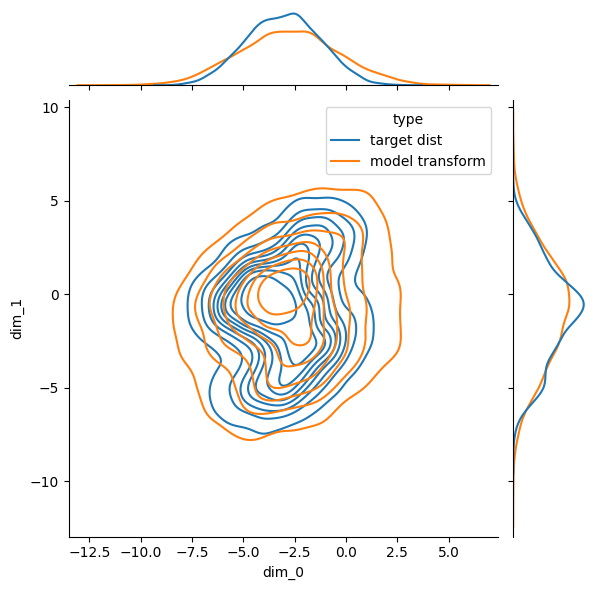

trail: 0 m step: 4 kl_test: 1.1779155731201172


  2%|▏         | 100/6000 [00:30<33:44,  2.91it/s]

trail: 0 m step: 5 Loss: 1.0098838806152344  L_n: 0.9169673919677734  kld: 0.009291648864746094 KLD1: 0.9298839569091797 KLD2: 0.5629892349243164


  3%|▎         | 200/6000 [01:01<32:45,  2.95it/s]

trail: 0 m step: 5 Loss: 1.0269222259521484  L_n: 0.8759746551513672  kld: 0.015094757080078125 KLD1: 0.8593392372131348 KLD2: 0.5293336510658264


  5%|▌         | 300/6000 [01:32<32:15,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9654436111450195  L_n: 0.8502016067504883  kld: 0.011524200439453125 KLD1: 0.9072418808937073 KLD2: 0.5459452867507935


  7%|▋         | 400/6000 [02:02<31:46,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0110177993774414  L_n: 0.8555784225463867  kld: 0.015543937683105469 KLD1: 0.8564949035644531 KLD2: 0.5307326316833496


  8%|▊         | 500/6000 [02:33<31:01,  2.96it/s]

trail: 0 m step: 5 Loss: 1.0372638702392578  L_n: 0.862274169921875  kld: 0.01749897003173828 KLD1: 0.8265624642372131 KLD2: 0.5355175733566284


 10%|█         | 600/6000 [03:04<30:31,  2.95it/s]

trail: 0 m step: 5 Loss: 1.017054557800293  L_n: 0.8868494033813477  kld: 0.013020515441894531 KLD1: 0.8787415027618408 KLD2: 0.5457964539527893


 12%|█▏        | 700/6000 [03:35<30:04,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0095596313476562  L_n: 0.9118366241455078  kld: 0.009772300720214844 KLD1: 0.922609269618988 KLD2: 0.5416505932807922


 13%|█▎        | 800/6000 [04:05<29:30,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9536476135253906  L_n: 0.8393878936767578  kld: 0.011425971984863281 KLD1: 0.880690336227417 KLD2: 0.5278415679931641


 15%|█▌        | 900/6000 [04:36<28:56,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0318307876586914  L_n: 0.8910589218139648  kld: 0.014077186584472656 KLD1: 0.861882209777832 KLD2: 0.5412625670433044


 17%|█▋        | 1000/6000 [05:07<28:23,  2.93it/s]

trail: 0 m step: 5 Loss: 0.9917583465576172  L_n: 0.8617725372314453  kld: 0.012998580932617188 KLD1: 0.8759447336196899 KLD2: 0.5322912335395813


 18%|█▊        | 1100/6000 [05:38<27:48,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0224132537841797  L_n: 0.8818511962890625  kld: 0.014056205749511719 KLD1: 0.8591967821121216 KLD2: 0.5180497169494629


 20%|██        | 1200/6000 [06:08<27:15,  2.93it/s]

trail: 0 m step: 5 Loss: 1.0282564163208008  L_n: 0.9144830703735352  kld: 0.011377334594726562 KLD1: 0.8943068385124207 KLD2: 0.5465447306632996


 22%|██▏       | 1300/6000 [06:39<26:40,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9838228225708008  L_n: 0.8376245498657227  kld: 0.014619827270507812 KLD1: 0.8606177568435669 KLD2: 0.5347402095794678


 23%|██▎       | 1400/6000 [07:10<26:08,  2.93it/s]

trail: 0 m step: 5 Loss: 1.0047731399536133  L_n: 0.8672342300415039  kld: 0.013753890991210938 KLD1: 0.8687700033187866 KLD2: 0.542256236076355


 25%|██▌       | 1500/6000 [07:41<25:29,  2.94it/s]

trail: 0 m step: 5 Loss: 1.013627052307129  L_n: 0.8755826950073242  kld: 0.013804435729980469 KLD1: 0.8603499531745911 KLD2: 0.5266292095184326


 27%|██▋       | 1600/6000 [08:11<24:53,  2.95it/s]

trail: 0 m step: 5 Loss: 1.0179376602172852  L_n: 0.8724069595336914  kld: 0.014553070068359375 KLD1: 0.8665080666542053 KLD2: 0.5191982388496399


 28%|██▊       | 1700/6000 [08:42<24:22,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9961013793945312  L_n: 0.8723049163818359  kld: 0.012379646301269531 KLD1: 0.8728947043418884 KLD2: 0.5352739095687866


 30%|███       | 1800/6000 [09:13<23:47,  2.94it/s]

trail: 0 m step: 5 Loss: 1.025674819946289  L_n: 0.8581428527832031  kld: 0.016753196716308594 KLD1: 0.8316318988800049 KLD2: 0.5229719877243042


 32%|███▏      | 1900/6000 [09:44<23:17,  2.93it/s]

trail: 0 m step: 5 Loss: 0.9904899597167969  L_n: 0.8927764892578125  kld: 0.009771347045898438 KLD1: 0.9147403836250305 KLD2: 0.5310825109481812


 33%|███▎      | 2000/6000 [10:14<22:43,  2.93it/s]

trail: 0 m step: 5 Loss: 1.0282983779907227  L_n: 0.8877840042114258  kld: 0.014051437377929688 KLD1: 0.8599748015403748 KLD2: 0.5250045657157898


 35%|███▌      | 2100/6000 [10:45<22:07,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9702081680297852  L_n: 0.8656854629516602  kld: 0.0104522705078125 KLD1: 0.8935241103172302 KLD2: 0.5410538911819458


 37%|███▋      | 2200/6000 [11:16<21:37,  2.93it/s]

trail: 0 m step: 5 Loss: 1.0194272994995117  L_n: 0.8787317276000977  kld: 0.014069557189941406 KLD1: 0.855083167552948 KLD2: 0.548966109752655


 38%|███▊      | 2300/6000 [11:47<20:59,  2.94it/s]

trail: 0 m step: 5 Loss: 1.023188591003418  L_n: 0.8792028427124023  kld: 0.014398574829101562 KLD1: 0.8620302677154541 KLD2: 0.5276257395744324


 40%|████      | 2400/6000 [12:17<20:28,  2.93it/s]

trail: 0 m step: 5 Loss: 1.0002470016479492  L_n: 0.8769845962524414  kld: 0.012326240539550781 KLD1: 0.8684417605400085 KLD2: 0.5397396087646484


 42%|████▏     | 2500/6000 [12:48<19:51,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9946041107177734  L_n: 0.8670597076416016  kld: 0.012754440307617188 KLD1: 0.8727949261665344 KLD2: 0.5292701721191406


 43%|████▎     | 2600/6000 [13:19<19:16,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0165929794311523  L_n: 0.8811330795288086  kld: 0.013545989990234375 KLD1: 0.8595105409622192 KLD2: 0.5307294130325317


 45%|████▌     | 2700/6000 [13:50<18:43,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9923620223999023  L_n: 0.8582563400268555  kld: 0.013410568237304688 KLD1: 0.8572386503219604 KLD2: 0.5282308459281921


 47%|████▋     | 2800/6000 [14:21<18:08,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9587383270263672  L_n: 0.8361530303955078  kld: 0.012258529663085938 KLD1: 0.8717575669288635 KLD2: 0.5250774025917053


 48%|████▊     | 2900/6000 [14:51<17:35,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9985675811767578  L_n: 0.87225341796875  kld: 0.012631416320800781 KLD1: 0.8699562549591064 KLD2: 0.5251115560531616


 50%|█████     | 3000/6000 [15:22<17:02,  2.93it/s]

trail: 0 m step: 5 Loss: 1.0092029571533203  L_n: 0.8655223846435547  kld: 0.014368057250976562 KLD1: 0.8568407297134399 KLD2: 0.5378132462501526


 52%|█████▏    | 3100/6000 [15:53<16:26,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9972448348999023  L_n: 0.843998908996582  kld: 0.015324592590332031 KLD1: 0.843337893486023 KLD2: 0.5236495733261108


 53%|█████▎    | 3200/6000 [16:24<15:53,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0315637588500977  L_n: 0.8746557235717773  kld: 0.01569080352783203 KLD1: 0.8359308242797852 KLD2: 0.5332767367362976


 55%|█████▌    | 3300/6000 [16:54<15:20,  2.93it/s]

trail: 0 m step: 5 Loss: 1.0363578796386719  L_n: 0.8994293212890625  kld: 0.013692855834960938 KLD1: 0.8657183647155762 KLD2: 0.5421004295349121


 57%|█████▋    | 3400/6000 [17:25<14:42,  2.95it/s]

trail: 0 m step: 5 Loss: 1.0184946060180664  L_n: 0.8816804885864258  kld: 0.013681411743164062 KLD1: 0.8634862899780273 KLD2: 0.5355530381202698


 58%|█████▊    | 3500/6000 [17:56<14:09,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0252933502197266  L_n: 0.8916645050048828  kld: 0.013362884521484375 KLD1: 0.8705599308013916 KLD2: 0.5210480093955994


 60%|██████    | 3600/6000 [18:27<13:37,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0057811737060547  L_n: 0.8278350830078125  kld: 0.01779460906982422 KLD1: 0.8263530135154724 KLD2: 0.5225694179534912


 62%|██████▏   | 3700/6000 [18:57<13:04,  2.93it/s]

trail: 0 m step: 5 Loss: 1.0487117767333984  L_n: 0.8973922729492188  kld: 0.015131950378417969 KLD1: 0.8435196280479431 KLD2: 0.5229475498199463


 63%|██████▎   | 3800/6000 [19:28<12:29,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0052452087402344  L_n: 0.8809814453125  kld: 0.012426376342773438 KLD1: 0.8782433271408081 KLD2: 0.520799994468689


 65%|██████▌   | 3900/6000 [19:59<11:55,  2.93it/s]

trail: 0 m step: 5 Loss: 0.987736701965332  L_n: 0.8539838790893555  kld: 0.013375282287597656 KLD1: 0.8537293672561646 KLD2: 0.5364852547645569


 67%|██████▋   | 4000/6000 [20:29<11:20,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0141324996948242  L_n: 0.8811140060424805  kld: 0.013301849365234375 KLD1: 0.8656998872756958 KLD2: 0.5240817070007324


 68%|██████▊   | 4100/6000 [21:00<10:46,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9516019821166992  L_n: 0.8646745681762695  kld: 0.008692741394042969 KLD1: 0.915310800075531 KLD2: 0.5221055746078491


 70%|███████   | 4200/6000 [21:31<10:11,  2.95it/s]

trail: 0 m step: 5 Loss: 0.971308708190918  L_n: 0.8506975173950195  kld: 0.012061119079589844 KLD1: 0.876853883266449 KLD2: 0.5264776945114136


 72%|███████▏  | 4300/6000 [22:02<09:37,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0263071060180664  L_n: 0.874882698059082  kld: 0.015142440795898438 KLD1: 0.8485574126243591 KLD2: 0.5268105864524841


 73%|███████▎  | 4400/6000 [22:33<09:03,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9935359954833984  L_n: 0.85003662109375  kld: 0.014349937438964844 KLD1: 0.8641441464424133 KLD2: 0.5101383924484253


 75%|███████▌  | 4500/6000 [23:03<08:30,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9966831207275391  L_n: 0.8480911254882812  kld: 0.014859199523925781 KLD1: 0.8478307127952576 KLD2: 0.5179579257965088


 77%|███████▋  | 4600/6000 [23:34<07:57,  2.93it/s]

trail: 0 m step: 5 Loss: 1.0294275283813477  L_n: 0.8621530532836914  kld: 0.016727447509765625 KLD1: 0.8259969353675842 KLD2: 0.5266821384429932


 78%|███████▊  | 4700/6000 [24:05<07:22,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0002031326293945  L_n: 0.8563699722290039  kld: 0.014383316040039062 KLD1: 0.8569328784942627 KLD2: 0.5261876583099365


 80%|████████  | 4800/6000 [24:35<06:48,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9688444137573242  L_n: 0.8287496566772461  kld: 0.014009475708007812 KLD1: 0.8545081615447998 KLD2: 0.5206941366195679


 82%|████████▏ | 4900/6000 [25:06<06:14,  2.93it/s]

trail: 0 m step: 5 Loss: 0.9850625991821289  L_n: 0.8683710098266602  kld: 0.011669158935546875 KLD1: 0.8852285742759705 KLD2: 0.5243917107582092


 83%|████████▎ | 5000/6000 [25:37<05:40,  2.94it/s]

trail: 0 m step: 5 Loss: 0.9853286743164062  L_n: 0.8486576080322266  kld: 0.013667106628417969 KLD1: 0.8563462495803833 KLD2: 0.5334439873695374


 85%|████████▌ | 5100/6000 [26:08<05:07,  2.93it/s]

trail: 0 m step: 5 Loss: 0.9847612380981445  L_n: 0.8402891159057617  kld: 0.014447212219238281 KLD1: 0.853264331817627 KLD2: 0.5272761583328247


 87%|████████▋ | 5200/6000 [26:38<04:32,  2.93it/s]

trail: 0 m step: 5 Loss: 0.96929931640625  L_n: 0.8541717529296875  kld: 0.01151275634765625 KLD1: 0.8841468691825867 KLD2: 0.5375258922576904


 88%|████████▊ | 5300/6000 [27:09<03:57,  2.95it/s]

trail: 0 m step: 5 Loss: 0.9940481185913086  L_n: 0.8498144149780273  kld: 0.014423370361328125 KLD1: 0.8471865057945251 KLD2: 0.5188362002372742


 90%|█████████ | 5400/6000 [27:40<03:23,  2.95it/s]

trail: 0 m step: 5 Loss: 1.056732177734375  L_n: 0.9046688079833984  kld: 0.015206336975097656 KLD1: 0.8380119204521179 KLD2: 0.523878812789917


 92%|█████████▏| 5500/6000 [28:11<02:50,  2.93it/s]

trail: 0 m step: 5 Loss: 0.9967546463012695  L_n: 0.8498411178588867  kld: 0.014691352844238281 KLD1: 0.8491494059562683 KLD2: 0.5232028961181641


 93%|█████████▎| 5600/6000 [28:41<02:16,  2.94it/s]

trail: 0 m step: 5 Loss: 1.0328044891357422  L_n: 0.8769931793212891  kld: 0.015581130981445312 KLD1: 0.8437561392784119 KLD2: 0.518234133720398


 95%|█████████▌| 5700/6000 [29:12<01:41,  2.95it/s]

trail: 0 m step: 5 Loss: 0.9830560684204102  L_n: 0.859278678894043  kld: 0.012377738952636719 KLD1: 0.874801516532898 KLD2: 0.5246127843856812


 97%|█████████▋| 5800/6000 [29:43<01:07,  2.95it/s]

trail: 0 m step: 5 Loss: 0.9743776321411133  L_n: 0.8548250198364258  kld: 0.01195526123046875 KLD1: 0.8796587586402893 KLD2: 0.52717524766922


 98%|█████████▊| 5900/6000 [30:14<00:34,  2.94it/s]

trail: 0 m step: 5 Loss: 1.01031494140625  L_n: 0.8657569885253906  kld: 0.014455795288085938 KLD1: 0.8590210676193237 KLD2: 0.5204036235809326


100%|██████████| 6000/6000 [30:44<00:00,  3.25it/s]

trail: 0 m step: 5 Loss: 0.9776773452758789  L_n: 0.8437814712524414  kld: 0.01338958740234375 KLD1: 0.8638857007026672 KLD2: 0.523119330406189



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


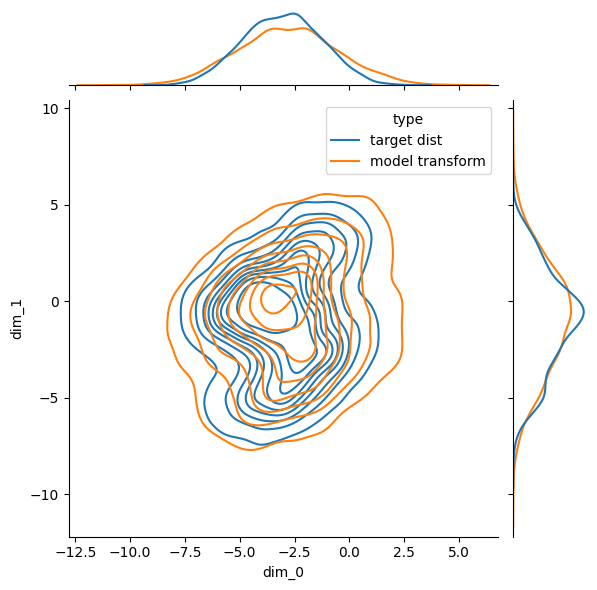

trail: 0 m step: 5 kl_test: 0.8676290512084961


  2%|▏         | 100/6000 [00:30<33:58,  2.89it/s]

trail: 0 m step: 6 Loss: 0.7555484771728516  L_n: 0.6937313079833984  kld: 0.0061817169189453125 KLD1: 0.7036312818527222 KLD2: 0.4501737058162689


  3%|▎         | 200/6000 [01:01<32:49,  2.95it/s]

trail: 0 m step: 6 Loss: 0.7717208862304688  L_n: 0.6644802093505859  kld: 0.010724067687988281 KLD1: 0.6472699642181396 KLD2: 0.42109477519989014


  5%|▌         | 300/6000 [01:32<32:23,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7198410034179688  L_n: 0.6433563232421875  kld: 0.007648468017578125 KLD1: 0.6925150156021118 KLD2: 0.4376585781574249


  7%|▋         | 400/6000 [02:03<31:49,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7556009292602539  L_n: 0.6470441818237305  kld: 0.010855674743652344 KLD1: 0.6497989892959595 KLD2: 0.4245077967643738


  8%|▊         | 500/6000 [02:33<31:14,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7817697525024414  L_n: 0.6530904769897461  kld: 0.012867927551269531 KLD1: 0.6234598755836487 KLD2: 0.42816445231437683


 10%|█         | 600/6000 [03:04<30:39,  2.93it/s]

trail: 0 m step: 6 Loss: 0.761784553527832  L_n: 0.6733217239379883  kld: 0.008846282958984375 KLD1: 0.6654431223869324 KLD2: 0.4379529654979706


 12%|█▏        | 700/6000 [03:35<30:01,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7549505233764648  L_n: 0.692875862121582  kld: 0.006207466125488281 KLD1: 0.7002031803131104 KLD2: 0.43363597989082336


 13%|█▎        | 800/6000 [04:06<29:30,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7136020660400391  L_n: 0.6356010437011719  kld: 0.007800102233886719 KLD1: 0.6648635864257812 KLD2: 0.42221468687057495


 15%|█▌        | 900/6000 [04:36<28:56,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7795438766479492  L_n: 0.6809244155883789  kld: 0.009861946105957031 KLD1: 0.6495254635810852 KLD2: 0.43399950861930847


 17%|█▋        | 1000/6000 [05:07<28:23,  2.93it/s]

trail: 0 m step: 6 Loss: 0.742584228515625  L_n: 0.6529769897460938  kld: 0.008960723876953125 KLD1: 0.6629752516746521 KLD2: 0.4257583022117615


 18%|█▊        | 1100/6000 [05:38<27:48,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7704849243164062  L_n: 0.6712074279785156  kld: 0.009927749633789062 KLD1: 0.6461434364318848 KLD2: 0.41272294521331787


 20%|██        | 1200/6000 [06:09<27:20,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7703924179077148  L_n: 0.6966829299926758  kld: 0.007370948791503906 KLD1: 0.679050862789154 KLD2: 0.4398331046104431


 22%|██▏       | 1300/6000 [06:39<26:42,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7355575561523438  L_n: 0.6352214813232422  kld: 0.010033607482910156 KLD1: 0.6529892683029175 KLD2: 0.4293443262577057


 23%|██▎       | 1400/6000 [07:10<26:04,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7450637817382812  L_n: 0.6495628356933594  kld: 0.009550094604492188 KLD1: 0.6567925214767456 KLD2: 0.4350631833076477


 25%|██▌       | 1500/6000 [07:41<25:34,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7572193145751953  L_n: 0.6630153656005859  kld: 0.009420394897460938 KLD1: 0.6513033509254456 KLD2: 0.4212521016597748


 27%|██▋       | 1600/6000 [08:12<24:58,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7648496627807617  L_n: 0.6612997055053711  kld: 0.010354995727539062 KLD1: 0.6540130376815796 KLD2: 0.41468045115470886


 28%|██▊       | 1700/6000 [08:43<24:26,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7432031631469727  L_n: 0.6619501113891602  kld: 0.00812530517578125 KLD1: 0.6633480191230774 KLD2: 0.4295257329940796


 30%|███       | 1800/6000 [09:13<23:47,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7652378082275391  L_n: 0.6480503082275391  kld: 0.01171875 KLD1: 0.6314406991004944 KLD2: 0.4191994071006775


 32%|███▏      | 1900/6000 [09:44<23:21,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7372760772705078  L_n: 0.6741142272949219  kld: 0.006316184997558594 KLD1: 0.6983175277709961 KLD2: 0.42530593276023865


 33%|███▎      | 2000/6000 [10:15<22:45,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7707891464233398  L_n: 0.672083854675293  kld: 0.009870529174804688 KLD1: 0.6494048833847046 KLD2: 0.41977185010910034


 35%|███▌      | 2100/6000 [10:46<22:06,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7219257354736328  L_n: 0.6552543640136719  kld: 0.006667137145996094 KLD1: 0.6771483421325684 KLD2: 0.43469178676605225


 37%|███▋      | 2200/6000 [11:16<21:32,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7646732330322266  L_n: 0.6658535003662109  kld: 0.009881973266601562 KLD1: 0.6470726132392883 KLD2: 0.4418697655200958


 38%|███▊      | 2300/6000 [11:47<21:03,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7649860382080078  L_n: 0.6662139892578125  kld: 0.009877204895019531 KLD1: 0.654255211353302 KLD2: 0.42322251200675964


 40%|████      | 2400/6000 [12:18<20:27,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7433090209960938  L_n: 0.661712646484375  kld: 0.008159637451171875 KLD1: 0.6584780812263489 KLD2: 0.43298035860061646


 42%|████▏     | 2500/6000 [12:49<19:55,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7446603775024414  L_n: 0.6570272445678711  kld: 0.008763313293457031 KLD1: 0.6606271266937256 KLD2: 0.4240458011627197


 43%|████▎     | 2600/6000 [13:20<19:17,  2.94it/s]

trail: 0 m step: 6 Loss: 0.765228271484375  L_n: 0.6708335876464844  kld: 0.009439468383789062 KLD1: 0.6465568542480469 KLD2: 0.4255472421646118


 45%|████▌     | 2700/6000 [13:50<18:43,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7482051849365234  L_n: 0.654449462890625  kld: 0.009375572204589844 KLD1: 0.6464370489120483 KLD2: 0.42380428314208984


 47%|████▋     | 2800/6000 [14:21<18:12,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7137613296508789  L_n: 0.6307535171508789  kld: 0.00830078125 KLD1: 0.6630786657333374 KLD2: 0.4204011559486389


 48%|████▊     | 2900/6000 [14:52<17:33,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7459831237792969  L_n: 0.6607151031494141  kld: 0.008526802062988281 KLD1: 0.6599695682525635 KLD2: 0.42058730125427246


 50%|█████     | 3000/6000 [15:23<17:03,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7556667327880859  L_n: 0.6552734375  kld: 0.010039329528808594 KLD1: 0.6474424600601196 KLD2: 0.43205663561820984


 52%|█████▏    | 3100/6000 [15:53<16:31,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7499246597290039  L_n: 0.6390409469604492  kld: 0.011088371276855469 KLD1: 0.63348788022995 KLD2: 0.4188571274280548


 53%|█████▎    | 3200/6000 [16:24<15:57,  2.92it/s]

trail: 0 m step: 6 Loss: 0.7723312377929688  L_n: 0.6606941223144531  kld: 0.011163711547851562 KLD1: 0.6318292617797852 KLD2: 0.4277708828449249


 55%|█████▌    | 3300/6000 [16:55<15:17,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7816715240478516  L_n: 0.6867904663085938  kld: 0.009488105773925781 KLD1: 0.6563886404037476 KLD2: 0.43622493743896484


 57%|█████▋    | 3400/6000 [17:26<14:48,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7640171051025391  L_n: 0.6702136993408203  kld: 0.009380340576171875 KLD1: 0.6570296287536621 KLD2: 0.4301963746547699


 58%|█████▊    | 3500/6000 [17:57<14:11,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7694587707519531  L_n: 0.6789073944091797  kld: 0.009055137634277344 KLD1: 0.6617981791496277 KLD2: 0.4171912968158722


 60%|██████    | 3600/6000 [18:27<13:39,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7533407211303711  L_n: 0.6236410140991211  kld: 0.012969970703125 KLD1: 0.6259451508522034 KLD2: 0.41862204670906067


 62%|██████▏   | 3700/6000 [18:58<13:05,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7853536605834961  L_n: 0.6801729202270508  kld: 0.010518074035644531 KLD1: 0.6411395072937012 KLD2: 0.4185433089733124


 63%|██████▎   | 3800/6000 [19:29<12:30,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7534236907958984  L_n: 0.6683559417724609  kld: 0.00850677490234375 KLD1: 0.669328510761261 KLD2: 0.4165753424167633


 65%|██████▌   | 3900/6000 [20:00<11:57,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7394027709960938  L_n: 0.6497478485107422  kld: 0.008965492248535156 KLD1: 0.6455603241920471 KLD2: 0.43187692761421204


 67%|██████▋   | 4000/6000 [20:31<11:20,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7606315612792969  L_n: 0.6710147857666016  kld: 0.008961677551269531 KLD1: 0.6585438847541809 KLD2: 0.420304536819458


 68%|██████▊   | 4100/6000 [21:01<10:47,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7078084945678711  L_n: 0.6557092666625977  kld: 0.005209922790527344 KLD1: 0.6952171921730042 KLD2: 0.4178784191608429


 70%|███████   | 4200/6000 [21:32<10:14,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7228555679321289  L_n: 0.6448640823364258  kld: 0.0077991485595703125 KLD1: 0.6685935258865356 KLD2: 0.42206576466560364


 72%|███████▏  | 4300/6000 [22:03<09:39,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7679834365844727  L_n: 0.6629743576049805  kld: 0.010500907897949219 KLD1: 0.6466050744056702 KLD2: 0.4216250479221344


 73%|███████▎  | 4400/6000 [22:34<09:05,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7435121536254883  L_n: 0.6430902481079102  kld: 0.010042190551757812 KLD1: 0.6545105576515198 KLD2: 0.40762439370155334


 75%|███████▌  | 4500/6000 [23:05<08:30,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7503089904785156  L_n: 0.6455860137939453  kld: 0.010472297668457031 KLD1: 0.638900101184845 KLD2: 0.414173424243927


 77%|███████▋  | 4600/6000 [23:35<07:56,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7707834243774414  L_n: 0.6521463394165039  kld: 0.01186370849609375 KLD1: 0.620982825756073 KLD2: 0.42214760184288025


 78%|███████▊  | 4700/6000 [24:06<07:22,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7463016510009766  L_n: 0.6477775573730469  kld: 0.009852409362792969 KLD1: 0.6496360898017883 KLD2: 0.421481728553772


 80%|████████  | 4800/6000 [24:37<06:48,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7220020294189453  L_n: 0.6261672973632812  kld: 0.009583473205566406 KLD1: 0.6453506946563721 KLD2: 0.41663798689842224


 82%|████████▏ | 4900/6000 [25:08<06:13,  2.95it/s]

trail: 0 m step: 6 Loss: 0.7381629943847656  L_n: 0.6593513488769531  kld: 0.00788116455078125 KLD1: 0.6724523305892944 KLD2: 0.41987738013267517


 83%|████████▎ | 5000/6000 [25:39<05:40,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7349090576171875  L_n: 0.6398849487304688  kld: 0.009502410888671875 KLD1: 0.6471203565597534 KLD2: 0.42806267738342285


 85%|████████▌ | 5100/6000 [26:10<05:06,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7397327423095703  L_n: 0.6393394470214844  kld: 0.010039329528808594 KLD1: 0.6482468843460083 KLD2: 0.4228791296482086


 87%|████████▋ | 5200/6000 [26:40<04:33,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7197694778442383  L_n: 0.6450109481811523  kld: 0.007475852966308594 KLD1: 0.6752867102622986 KLD2: 0.4323662519454956


 88%|████████▊ | 5300/6000 [27:11<03:58,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7445268630981445  L_n: 0.6425790786743164  kld: 0.010194778442382812 KLD1: 0.6362361907958984 KLD2: 0.4145445227622986


 90%|█████████ | 5400/6000 [27:42<03:24,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7948856353759766  L_n: 0.6891136169433594  kld: 0.010577201843261719 KLD1: 0.63099604845047 KLD2: 0.41999930143356323


 92%|█████████▏| 5500/6000 [28:13<02:50,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7438640594482422  L_n: 0.6423358917236328  kld: 0.010152816772460938 KLD1: 0.6422813534736633 KLD2: 0.4191262722015381


 93%|█████████▎| 5600/6000 [28:44<02:16,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7753448486328125  L_n: 0.6656723022460938  kld: 0.010967254638671875 KLD1: 0.6389679908752441 KLD2: 0.4144957959651947


 95%|█████████▌| 5700/6000 [29:14<01:42,  2.94it/s]

trail: 0 m step: 6 Loss: 0.7319221496582031  L_n: 0.6500015258789062  kld: 0.008192062377929688 KLD1: 0.6648454666137695 KLD2: 0.42033231258392334


 97%|█████████▋| 5800/6000 [29:45<01:08,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7269649505615234  L_n: 0.6459693908691406  kld: 0.008099555969238281 KLD1: 0.6685087084770203 KLD2: 0.42235252261161804


 98%|█████████▊| 5900/6000 [30:16<00:34,  2.93it/s]

trail: 0 m step: 6 Loss: 0.7560911178588867  L_n: 0.6581201553344727  kld: 0.009797096252441406 KLD1: 0.6501805782318115 KLD2: 0.41611921787261963


100%|██████████| 6000/6000 [30:47<00:00,  3.25it/s]

trail: 0 m step: 6 Loss: 0.7299394607543945  L_n: 0.6390542984008789  kld: 0.009088516235351562 KLD1: 0.6552729606628418 KLD2: 0.41882744431495667



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


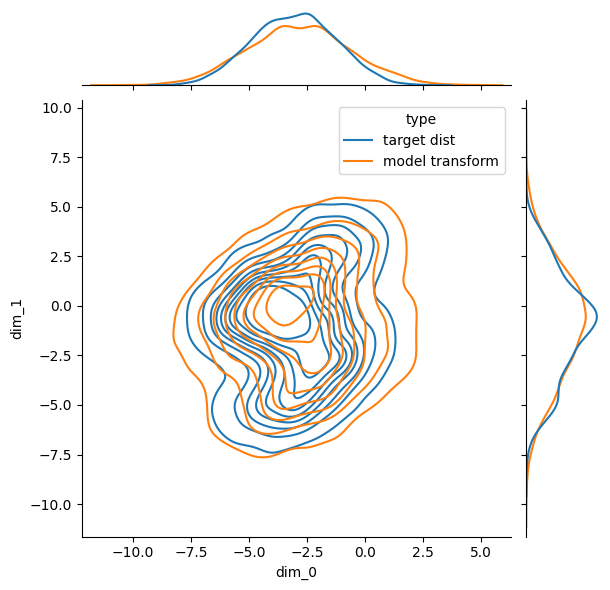

trail: 0 m step: 6 kl_test: 0.6538724899291992


  2%|▏         | 100/6000 [00:30<33:51,  2.90it/s]

trail: 0 m step: 7 Loss: 0.5780239105224609  L_n: 0.5374832153320312  kld: 0.004054069519042969 KLD1: 0.5427965521812439 KLD2: 0.36468666791915894


  3%|▎         | 200/6000 [01:01<32:43,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5958490371704102  L_n: 0.5171995162963867  kld: 0.007864952087402344 KLD1: 0.5002223253250122 KLD2: 0.3389514684677124


  5%|▌         | 300/6000 [01:32<32:14,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5461435317993164  L_n: 0.4940824508666992  kld: 0.005206108093261719 KLD1: 0.5370075106620789 KLD2: 0.35366347432136536


  7%|▋         | 400/6000 [02:02<31:43,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5788850784301758  L_n: 0.4995584487915039  kld: 0.007932662963867188 KLD1: 0.5032778382301331 KLD2: 0.34274980425834656


  8%|▊         | 500/6000 [02:33<31:18,  2.93it/s]

trail: 0 m step: 7 Loss: 0.6032390594482422  L_n: 0.5037899017333984  kld: 0.009944915771484375 KLD1: 0.48169076442718506 KLD2: 0.34589263796806335


 10%|█         | 600/6000 [03:04<30:37,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5820770263671875  L_n: 0.5193538665771484  kld: 0.006272315979003906 KLD1: 0.5144335627555847 KLD2: 0.35465583205223083


 12%|█▏        | 700/6000 [03:35<30:01,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5769472122192383  L_n: 0.5365018844604492  kld: 0.004044532775878906 KLD1: 0.5415255427360535 KLD2: 0.35049882531166077


 13%|█▎        | 800/6000 [04:05<29:24,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5482015609741211  L_n: 0.49182987213134766  kld: 0.005637168884277344 KLD1: 0.5125375986099243 KLD2: 0.3412805199623108


 15%|█▌        | 900/6000 [04:36<28:52,  2.94it/s]

trail: 0 m step: 7 Loss: 0.6017704010009766  L_n: 0.5307598114013672  kld: 0.0071010589599609375 KLD1: 0.5012423992156982 KLD2: 0.3518220782279968


 17%|█▋        | 1000/6000 [05:07<28:14,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5685138702392578  L_n: 0.5051231384277344  kld: 0.006339073181152344 KLD1: 0.5101714134216309 KLD2: 0.34343743324279785


 18%|█▊        | 1100/6000 [05:37<27:40,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5959758758544922  L_n: 0.5211696624755859  kld: 0.007480621337890625 KLD1: 0.4970119893550873 KLD2: 0.3315015435218811


 20%|██        | 1200/6000 [06:08<27:03,  2.96it/s]

trail: 0 m step: 7 Loss: 0.5904474258422852  L_n: 0.5409040451049805  kld: 0.004954338073730469 KLD1: 0.5270934700965881 KLD2: 0.35750848054885864


 22%|██▏       | 1300/6000 [06:39<26:34,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5640134811401367  L_n: 0.4920492172241211  kld: 0.0071964263916015625 KLD1: 0.5042622685432434 KLD2: 0.348052442073822


 23%|██▎       | 1400/6000 [07:09<26:06,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5658550262451172  L_n: 0.4965991973876953  kld: 0.0069255828857421875 KLD1: 0.5060827732086182 KLD2: 0.35257959365844727


 25%|██▌       | 1500/6000 [07:40<25:24,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5782995223999023  L_n: 0.5114660263061523  kld: 0.006683349609375 KLD1: 0.5049462914466858 KLD2: 0.3401011526584625


 27%|██▋       | 1600/6000 [08:11<24:52,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5888566970825195  L_n: 0.5102453231811523  kld: 0.007861137390136719 KLD1: 0.5034571290016174 KLD2: 0.3341408967971802


 28%|██▊       | 1700/6000 [08:41<24:18,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5666103363037109  L_n: 0.5109634399414062  kld: 0.005564689636230469 KLD1: 0.5151494145393372 KLD2: 0.34816786646842957


 30%|███       | 1800/6000 [09:12<23:48,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5843973159790039  L_n: 0.4995393753051758  kld: 0.008485794067382812 KLD1: 0.49017420411109924 KLD2: 0.3393309712409973


 32%|███▏      | 1900/6000 [09:43<23:04,  2.96it/s]

trail: 0 m step: 7 Loss: 0.5617141723632812  L_n: 0.5190372467041016  kld: 0.004267692565917969 KLD1: 0.543239414691925 KLD2: 0.3438323736190796


 33%|███▎      | 2000/6000 [10:13<22:38,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5920095443725586  L_n: 0.518519401550293  kld: 0.0073490142822265625 KLD1: 0.4969625473022461 KLD2: 0.33846035599708557


 35%|███▌      | 2100/6000 [10:44<22:05,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5522079467773438  L_n: 0.50860595703125  kld: 0.004360198974609375 KLD1: 0.5260375738143921 KLD2: 0.3524305522441864


 37%|███▋      | 2200/6000 [11:15<21:33,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5859642028808594  L_n: 0.5143337249755859  kld: 0.007163047790527344 KLD1: 0.4998728334903717 KLD2: 0.3590976595878601


 38%|███▊      | 2300/6000 [11:45<20:58,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5840301513671875  L_n: 0.5136680603027344  kld: 0.0070362091064453125 KLD1: 0.5083787441253662 KLD2: 0.34269896149635315


 40%|████      | 2400/6000 [12:16<20:24,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5632600784301758  L_n: 0.5084333419799805  kld: 0.005482673645019531 KLD1: 0.5118775963783264 KLD2: 0.35095465183258057


 42%|████▏     | 2500/6000 [12:47<19:46,  2.95it/s]

trail: 0 m step: 7 Loss: 0.569849967956543  L_n: 0.5067548751831055  kld: 0.00630950927734375 KLD1: 0.5104787349700928 KLD2: 0.3431587219238281


 43%|████▎     | 2600/6000 [13:18<19:14,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5870389938354492  L_n: 0.5178213119506836  kld: 0.0069217681884765625 KLD1: 0.4976906478404999 KLD2: 0.34454432129859924


 45%|████▌     | 2700/6000 [13:48<18:42,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5774164199829102  L_n: 0.5083799362182617  kld: 0.006903648376464844 KLD1: 0.49895066022872925 KLD2: 0.3430841565132141


 47%|████▋     | 2800/6000 [14:19<18:08,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5435447692871094  L_n: 0.4862194061279297  kld: 0.005732536315917969 KLD1: 0.511890172958374 KLD2: 0.3398902416229248


 48%|████▊     | 2900/6000 [14:50<17:32,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5693912506103516  L_n: 0.5100059509277344  kld: 0.005938529968261719 KLD1: 0.5106741189956665 KLD2: 0.3401208817958832


 50%|█████     | 3000/6000 [15:20<16:57,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5789508819580078  L_n: 0.5050697326660156  kld: 0.007388114929199219 KLD1: 0.4993177652359009 KLD2: 0.35054269433021545


 52%|█████▏    | 3100/6000 [15:51<16:27,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5773763656616211  L_n: 0.49374866485595703  kld: 0.008362770080566406 KLD1: 0.48676633834838867 KLD2: 0.33833345770835876


 53%|█████▎    | 3200/6000 [16:22<15:52,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5950784683227539  L_n: 0.5125570297241211  kld: 0.008252143859863281 KLD1: 0.48709529638290405 KLD2: 0.3466327488422394


 55%|█████▌    | 3300/6000 [16:52<15:16,  2.95it/s]

trail: 0 m step: 7 Loss: 0.6037235260009766  L_n: 0.5351829528808594  kld: 0.006854057312011719 KLD1: 0.5092841386795044 KLD2: 0.3543451428413391


 57%|█████▋    | 3400/6000 [17:23<14:40,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5883731842041016  L_n: 0.52130126953125  kld: 0.006707191467285156 KLD1: 0.5108726620674133 KLD2: 0.3489571511745453


 58%|█████▊    | 3500/6000 [17:54<14:06,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5910396575927734  L_n: 0.5279731750488281  kld: 0.006306648254394531 KLD1: 0.5154283046722412 KLD2: 0.33725130558013916


 60%|██████    | 3600/6000 [18:24<13:36,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5763120651245117  L_n: 0.4789609909057617  kld: 0.009735107421875 KLD1: 0.48437753319740295 KLD2: 0.33880698680877686


 62%|██████▏   | 3700/6000 [18:55<13:01,  2.94it/s]

trail: 0 m step: 7 Loss: 0.601893424987793  L_n: 0.5256280899047852  kld: 0.007626533508300781 KLD1: 0.49600809812545776 KLD2: 0.3381279706954956


 63%|██████▎   | 3800/6000 [19:26<12:26,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5777196884155273  L_n: 0.5179529190063477  kld: 0.005976676940917969 KLD1: 0.5197973251342773 KLD2: 0.33653524518013


 65%|██████▌   | 3900/6000 [19:56<11:52,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5672016143798828  L_n: 0.5041732788085938  kld: 0.006302833557128906 KLD1: 0.49907225370407104 KLD2: 0.351044237613678


 67%|██████▋   | 4000/6000 [20:27<11:56,  2.79it/s]

trail: 0 m step: 7 Loss: 0.583709716796875  L_n: 0.5211868286132812  kld: 0.006252288818359375 KLD1: 0.5109158754348755 KLD2: 0.34005507826805115


 68%|██████▊   | 4100/6000 [20:58<10:45,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5406761169433594  L_n: 0.5074787139892578  kld: 0.0033197402954101562 KLD1: 0.5391201972961426 KLD2: 0.3376517593860626


 70%|███████   | 4200/6000 [21:29<10:12,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5521669387817383  L_n: 0.49945735931396484  kld: 0.005270957946777344 KLD1: 0.5182035565376282 KLD2: 0.3415698707103729


 72%|███████▏  | 4300/6000 [21:59<09:39,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5894994735717773  L_n: 0.5139970779418945  kld: 0.007550239562988281 KLD1: 0.5038217902183533 KLD2: 0.34052664041519165


 73%|███████▎  | 4400/6000 [22:30<09:04,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5685710906982422  L_n: 0.4959678649902344  kld: 0.007260322570800781 KLD1: 0.5039157867431641 KLD2: 0.3287881314754486


 75%|███████▌  | 4500/6000 [23:01<08:31,  2.93it/s]

trail: 0 m step: 7 Loss: 0.5818328857421875  L_n: 0.5034599304199219  kld: 0.007837295532226562 KLD1: 0.490055650472641 KLD2: 0.3343169391155243


 77%|███████▋  | 4600/6000 [23:31<07:56,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5910282135009766  L_n: 0.5015354156494141  kld: 0.00894927978515625 KLD1: 0.4771870970726013 KLD2: 0.3416333794593811


 78%|███████▊  | 4700/6000 [24:02<07:21,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5721158981323242  L_n: 0.5011148452758789  kld: 0.007100105285644531 KLD1: 0.5032352805137634 KLD2: 0.3409155607223511


 80%|████████  | 4800/6000 [24:33<06:49,  2.93it/s]

trail: 0 m step: 7 Loss: 0.5502662658691406  L_n: 0.48187828063964844  kld: 0.006838798522949219 KLD1: 0.4976878762245178 KLD2: 0.3363730013370514


 82%|████████▏ | 4900/6000 [25:04<06:14,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5698270797729492  L_n: 0.5125017166137695  kld: 0.005732536315917969 KLD1: 0.5229299664497375 KLD2: 0.33936917781829834


 83%|████████▎ | 5000/6000 [25:34<05:38,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5636920928955078  L_n: 0.4956092834472656  kld: 0.006808280944824219 KLD1: 0.5000014305114746 KLD2: 0.3468049168586731


 85%|████████▌ | 5100/6000 [26:05<05:05,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5648136138916016  L_n: 0.4930877685546875  kld: 0.007172584533691406 KLD1: 0.49955302476882935 KLD2: 0.34222498536109924


 87%|████████▋ | 5200/6000 [26:36<04:31,  2.94it/s]

trail: 0 m step: 7 Loss: 0.547053337097168  L_n: 0.4954214096069336  kld: 0.0051631927490234375 KLD1: 0.5264294147491455 KLD2: 0.35101887583732605


 88%|████████▊ | 5300/6000 [27:07<03:58,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5705080032348633  L_n: 0.4961977005004883  kld: 0.0074310302734375 KLD1: 0.4875754415988922 KLD2: 0.33449822664260864


 90%|█████████ | 5400/6000 [27:37<03:23,  2.95it/s]

trail: 0 m step: 7 Loss: 0.6123046875  L_n: 0.5345516204833984  kld: 0.007775306701660156 KLD1: 0.48582723736763 KLD2: 0.34003058075904846


 92%|█████████▏| 5500/6000 [28:08<02:50,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5717096328735352  L_n: 0.49935436248779297  kld: 0.007235527038574219 KLD1: 0.49778661131858826 KLD2: 0.33927059173583984


 93%|█████████▎| 5600/6000 [28:39<02:16,  2.94it/s]

trail: 0 m step: 7 Loss: 0.5977840423583984  L_n: 0.5171985626220703  kld: 0.008058547973632812 KLD1: 0.49383583664894104 KLD2: 0.3343523442745209


 95%|█████████▌| 5700/6000 [29:10<01:41,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5569095611572266  L_n: 0.5008811950683594  kld: 0.005602836608886719 KLD1: 0.5158390998840332 KLD2: 0.339949369430542


 97%|█████████▋| 5800/6000 [29:40<01:07,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5572853088378906  L_n: 0.5009708404541016  kld: 0.005631446838378906 KLD1: 0.5198749899864197 KLD2: 0.3418676555156708


 98%|█████████▊| 5900/6000 [30:11<00:33,  2.95it/s]

trail: 0 m step: 7 Loss: 0.5806283950805664  L_n: 0.5104284286499023  kld: 0.007019996643066406 KLD1: 0.5022963285446167 KLD2: 0.33566415309906006


100%|██████████| 6000/6000 [30:42<00:00,  3.26it/s]

trail: 0 m step: 7 Loss: 0.5565414428710938  L_n: 0.4931221008300781  kld: 0.0063419342041015625 KLD1: 0.5091663002967834 KLD2: 0.3383285701274872



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


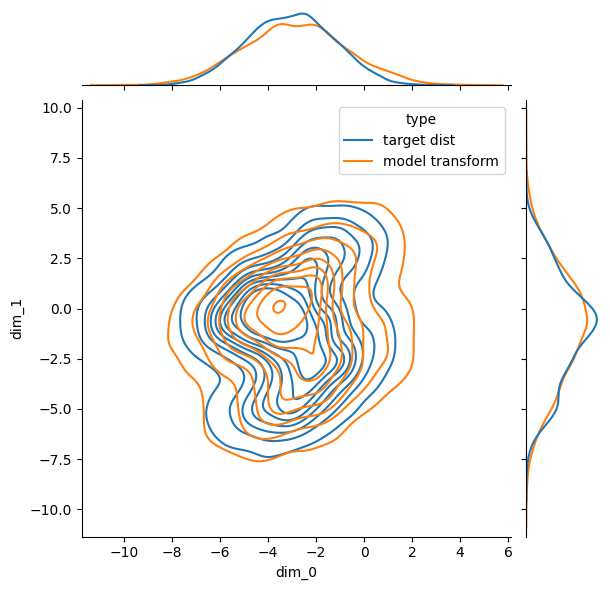

trail: 0 m step: 7 kl_test: 0.5017871856689453


  2%|▏         | 100/6000 [00:30<33:56,  2.90it/s]

trail: 0 m step: 8 Loss: 0.4492168426513672  L_n: 0.4230384826660156  kld: 0.0026178359985351562 KLD1: 0.4277857840061188 KLD2: 0.2984834313392639


  3%|▎         | 200/6000 [01:01<32:43,  2.95it/s]

trail: 0 m step: 8 Loss: 0.4681549072265625  L_n: 0.4085884094238281  kld: 0.0059566497802734375 KLD1: 0.3929591178894043 KLD2: 0.27511706948280334


  5%|▌         | 300/6000 [01:32<32:19,  2.94it/s]

trail: 0 m step: 8 Loss: 0.42267608642578125  L_n: 0.3869800567626953  kld: 0.0035696029663085938 KLD1: 0.4244222939014435 KLD2: 0.28839248418807983


  7%|▋         | 400/6000 [02:03<31:46,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4540214538574219  L_n: 0.3937206268310547  kld: 0.006030082702636719 KLD1: 0.3959343731403351 KLD2: 0.27868396043777466


  8%|▊         | 500/6000 [02:33<31:02,  2.95it/s]

trail: 0 m step: 8 Loss: 0.47571754455566406  L_n: 0.3966388702392578  kld: 0.007907867431640625 KLD1: 0.3783300220966339 KLD2: 0.28206780552864075


 10%|█         | 600/6000 [03:04<30:46,  2.92it/s]

trail: 0 m step: 8 Loss: 0.4534883499145508  L_n: 0.4071016311645508  kld: 0.004638671875 KLD1: 0.40241435170173645 KLD2: 0.2892725169658661


 12%|█▏        | 700/6000 [03:35<30:02,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4508695602416992  L_n: 0.42339420318603516  kld: 0.0027475357055664062 KLD1: 0.42431312799453735 KLD2: 0.2854698598384857


 13%|█▎        | 800/6000 [04:06<29:20,  2.95it/s]

trail: 0 m step: 8 Loss: 0.4280281066894531  L_n: 0.3854656219482422  kld: 0.004256248474121094 KLD1: 0.4021056890487671 KLD2: 0.27819594740867615


 15%|█▌        | 900/6000 [04:36<28:54,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4712352752685547  L_n: 0.4178485870361328  kld: 0.0053386688232421875 KLD1: 0.3933422267436981 KLD2: 0.28718286752700806


 17%|█▋        | 1000/6000 [05:07<28:21,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4431467056274414  L_n: 0.39491939544677734  kld: 0.004822731018066406 KLD1: 0.39871636033058167 KLD2: 0.2790122628211975


 18%|█▊        | 1100/6000 [05:38<27:44,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4700136184692383  L_n: 0.4119253158569336  kld: 0.005808830261230469 KLD1: 0.391043484210968 KLD2: 0.2686625123023987


 20%|██        | 1200/6000 [06:08<27:09,  2.95it/s]

trail: 0 m step: 8 Loss: 0.46060657501220703  L_n: 0.42510128021240234  kld: 0.0035505294799804688 KLD1: 0.4163517355918884 KLD2: 0.2928886413574219


 22%|██▏       | 1300/6000 [06:39<26:33,  2.95it/s]

trail: 0 m step: 8 Loss: 0.4402780532836914  L_n: 0.38591861724853516  kld: 0.005435943603515625 KLD1: 0.39511141180992126 KLD2: 0.28461533784866333


 23%|██▎       | 1400/6000 [07:10<26:03,  2.94it/s]

trail: 0 m step: 8 Loss: 0.44063758850097656  L_n: 0.3885765075683594  kld: 0.005206108093261719 KLD1: 0.3988129794597626 KLD2: 0.28799882531166077


 25%|██▌       | 1500/6000 [07:40<25:28,  2.94it/s]

trail: 0 m step: 8 Loss: 0.44909095764160156  L_n: 0.40093040466308594  kld: 0.0048160552978515625 KLD1: 0.4002392888069153 KLD2: 0.27681660652160645


 27%|██▋       | 1600/6000 [08:11<24:55,  2.94it/s]

trail: 0 m step: 8 Loss: 0.46301841735839844  L_n: 0.40093421936035156  kld: 0.0062084197998046875 KLD1: 0.3965400755405426 KLD2: 0.2713720500469208


 28%|██▊       | 1700/6000 [08:42<24:22,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4402179718017578  L_n: 0.4013938903808594  kld: 0.0038824081420898438 KLD1: 0.4052230715751648 KLD2: 0.284638911485672


 30%|███       | 1800/6000 [09:13<23:48,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4558753967285156  L_n: 0.3917980194091797  kld: 0.006407737731933594 KLD1: 0.38589462637901306 KLD2: 0.2769659161567688


 32%|███▏      | 1900/6000 [09:43<23:15,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4348897933959961  L_n: 0.4064512252807617  kld: 0.0028438568115234375 KLD1: 0.42848333716392517 KLD2: 0.2808084785938263


 33%|███▎      | 2000/6000 [10:14<22:41,  2.94it/s]

trail: 0 m step: 8 Loss: 0.46231651306152344  L_n: 0.40608787536621094  kld: 0.00562286376953125 KLD1: 0.38760823011398315 KLD2: 0.2752041518688202


 35%|███▌      | 2100/6000 [10:45<22:04,  2.94it/s]

trail: 0 m step: 8 Loss: 0.43053627014160156  L_n: 0.4011058807373047  kld: 0.0029430389404296875 KLD1: 0.41607528924942017 KLD2: 0.28843578696250916


 37%|███▋      | 2200/6000 [11:16<21:35,  2.93it/s]

trail: 0 m step: 8 Loss: 0.4584770202636719  L_n: 0.4051952362060547  kld: 0.005328178405761719 KLD1: 0.3902442455291748 KLD2: 0.29442688822746277


 38%|███▊      | 2300/6000 [11:46<20:58,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4543161392211914  L_n: 0.40361881256103516  kld: 0.005069732666015625 KLD1: 0.4015927016735077 KLD2: 0.2801744043827057


 40%|████      | 2400/6000 [12:17<20:26,  2.93it/s]

trail: 0 m step: 8 Loss: 0.43467044830322266  L_n: 0.3977346420288086  kld: 0.0036935806274414062 KLD1: 0.4058153033256531 KLD2: 0.2868102490901947


 42%|████▏     | 2500/6000 [12:48<19:48,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4452028274536133  L_n: 0.3977384567260742  kld: 0.004746437072753906 KLD1: 0.4002370834350586 KLD2: 0.2798171639442444


 43%|████▎     | 2600/6000 [13:19<19:15,  2.94it/s]

trail: 0 m step: 8 Loss: 0.45874786376953125  L_n: 0.4062767028808594  kld: 0.0052471160888671875 KLD1: 0.38993388414382935 KLD2: 0.2810453474521637


 45%|████▌     | 2700/6000 [13:49<18:44,  2.94it/s]

trail: 0 m step: 8 Loss: 0.45404624938964844  L_n: 0.4028434753417969  kld: 0.005120277404785156 KLD1: 0.39384353160858154 KLD2: 0.28027400374412537


 47%|████▋     | 2800/6000 [14:20<18:06,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4218864440917969  L_n: 0.3809165954589844  kld: 0.00409698486328125 KLD1: 0.4007455110549927 KLD2: 0.2770554721355438


 48%|████▊     | 2900/6000 [14:51<17:35,  2.94it/s]

trail: 0 m step: 8 Loss: 0.44211292266845703  L_n: 0.3992166519165039  kld: 0.0042896270751953125 KLD1: 0.40175771713256836 KLD2: 0.27727338671684265


 50%|█████     | 3000/6000 [15:22<16:58,  2.95it/s]

trail: 0 m step: 8 Loss: 0.4525327682495117  L_n: 0.3972768783569336  kld: 0.0055255889892578125 KLD1: 0.39153724908828735 KLD2: 0.28705868124961853


 52%|█████▏    | 3100/6000 [15:52<16:26,  2.94it/s]

trail: 0 m step: 8 Loss: 0.45337390899658203  L_n: 0.3880281448364258  kld: 0.006534576416015625 KLD1: 0.3822118937969208 KLD2: 0.27540308237075806


 53%|█████▎    | 3200/6000 [16:23<15:52,  2.94it/s]

trail: 0 m step: 8 Loss: 0.46742820739746094  L_n: 0.40533447265625  kld: 0.006209373474121094 KLD1: 0.3831323981285095 KLD2: 0.283008873462677


 55%|█████▌    | 3300/6000 [16:54<15:20,  2.93it/s]

trail: 0 m step: 8 Loss: 0.47601890563964844  L_n: 0.42339515686035156  kld: 0.0052623748779296875 KLD1: 0.39920365810394287 KLD2: 0.29014280438423157


 57%|█████▋    | 3400/6000 [17:25<14:43,  2.94it/s]

trail: 0 m step: 8 Loss: 0.46038055419921875  L_n: 0.41109466552734375  kld: 0.0049285888671875 KLD1: 0.40443894267082214 KLD2: 0.28538280725479126


 58%|█████▊    | 3500/6000 [17:55<14:09,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4620656967163086  L_n: 0.41800594329833984  kld: 0.004405975341796875 KLD1: 0.40730103850364685 KLD2: 0.2747457027435303


 60%|██████    | 3600/6000 [18:26<13:36,  2.94it/s]

trail: 0 m step: 8 Loss: 0.45065975189208984  L_n: 0.37433719635009766  kld: 0.007632255554199219 KLD1: 0.3789869546890259 KLD2: 0.27614626288414


 62%|██████▏   | 3700/6000 [18:57<13:02,  2.94it/s]

trail: 0 m step: 8 Loss: 0.46845054626464844  L_n: 0.41143035888671875  kld: 0.005702018737792969 KLD1: 0.389456570148468 KLD2: 0.27517080307006836


 63%|██████▎   | 3800/6000 [19:28<12:29,  2.94it/s]

trail: 0 m step: 8 Loss: 0.45136165618896484  L_n: 0.4081697463989258  kld: 0.004319190979003906 KLD1: 0.40775251388549805 KLD2: 0.27393728494644165


 65%|██████▌   | 3900/6000 [19:58<11:57,  2.93it/s]

trail: 0 m step: 8 Loss: 0.44238948822021484  L_n: 0.39739513397216797  kld: 0.0044994354248046875 KLD1: 0.3920270800590515 KLD2: 0.2876175343990326


 67%|██████▋   | 4000/6000 [20:29<11:19,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4555168151855469  L_n: 0.41089439392089844  kld: 0.004462242126464844 KLD1: 0.4044250249862671 KLD2: 0.27745842933654785


 68%|██████▊   | 4100/6000 [21:00<10:46,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4215116500854492  L_n: 0.39980602264404297  kld: 0.002170562744140625 KLD1: 0.42495524883270264 KLD2: 0.2748115062713623


 70%|███████   | 4200/6000 [21:31<10:10,  2.95it/s]

trail: 0 m step: 8 Loss: 0.4310493469238281  L_n: 0.39418983459472656  kld: 0.0036859512329101562 KLD1: 0.40647122263908386 KLD2: 0.27838367223739624


 72%|███████▏  | 4300/6000 [22:01<09:38,  2.94it/s]

trail: 0 m step: 8 Loss: 0.46035289764404297  L_n: 0.40476322174072266  kld: 0.005558967590332031 KLD1: 0.4008682668209076 KLD2: 0.27726155519485474


 73%|███████▎  | 4400/6000 [22:32<09:04,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4414196014404297  L_n: 0.3881568908691406  kld: 0.005326271057128906 KLD1: 0.3942210376262665 KLD2: 0.2672979533672333


 75%|███████▌  | 4500/6000 [23:03<08:30,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4580707550048828  L_n: 0.39844703674316406  kld: 0.005962371826171875 KLD1: 0.3821755647659302 KLD2: 0.2719373106956482


 77%|███████▋  | 4600/6000 [23:34<07:56,  2.94it/s]

trail: 0 m step: 8 Loss: 0.46094512939453125  L_n: 0.3920421600341797  kld: 0.006890296936035156 KLD1: 0.37374046444892883 KLD2: 0.2786976993083954


 78%|███████▊  | 4700/6000 [24:04<07:23,  2.93it/s]

trail: 0 m step: 8 Loss: 0.4468660354614258  L_n: 0.3942899703979492  kld: 0.005257606506347656 KLD1: 0.3961407542228699 KLD2: 0.27808213233947754


 80%|████████  | 4800/6000 [24:35<06:49,  2.93it/s]

trail: 0 m step: 8 Loss: 0.4263458251953125  L_n: 0.3755531311035156  kld: 0.0050792694091796875 KLD1: 0.3905373215675354 KLD2: 0.2737756371498108


 82%|████████▏ | 4900/6000 [25:06<06:15,  2.93it/s]

trail: 0 m step: 8 Loss: 0.44687652587890625  L_n: 0.40468597412109375  kld: 0.00421905517578125 KLD1: 0.41339167952537537 KLD2: 0.2765832841396332


 83%|████████▎ | 5000/6000 [25:37<05:41,  2.93it/s]

trail: 0 m step: 8 Loss: 0.4405479431152344  L_n: 0.3900413513183594  kld: 0.0050506591796875 KLD1: 0.3925957679748535 KLD2: 0.28330501914024353


 85%|████████▌ | 5100/6000 [26:08<05:06,  2.94it/s]

trail: 0 m step: 8 Loss: 0.43901824951171875  L_n: 0.3867759704589844  kld: 0.0052242279052734375 KLD1: 0.39232826232910156 KLD2: 0.27918437123298645


 87%|████████▋ | 5200/6000 [26:38<04:32,  2.94it/s]

trail: 0 m step: 8 Loss: 0.42414283752441406  L_n: 0.3883323669433594  kld: 0.0035810470581054688 KLD1: 0.41632869839668274 KLD2: 0.2872098982334137


 88%|████████▊ | 5300/6000 [27:09<03:58,  2.93it/s]

trail: 0 m step: 8 Loss: 0.44750118255615234  L_n: 0.3908720016479492  kld: 0.0056629180908203125 KLD1: 0.38034555315971375 KLD2: 0.272159606218338


 90%|█████████ | 5400/6000 [27:40<03:23,  2.94it/s]

trail: 0 m step: 8 Loss: 0.48155784606933594  L_n: 0.42115211486816406  kld: 0.0060405731201171875 KLD1: 0.37988823652267456 KLD2: 0.2773485481739044


 92%|█████████▏| 5500/6000 [28:11<02:49,  2.94it/s]

trail: 0 m step: 8 Loss: 0.44849586486816406  L_n: 0.3952808380126953  kld: 0.005321502685546875 KLD1: 0.3929755389690399 KLD2: 0.27676135301589966


 93%|█████████▎| 5600/6000 [28:41<02:16,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4726696014404297  L_n: 0.4115104675292969  kld: 0.006115913391113281 KLD1: 0.3869619071483612 KLD2: 0.27183714509010315


 95%|█████████▌| 5700/6000 [29:12<01:41,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4317178726196289  L_n: 0.3927125930786133  kld: 0.0039005279541015625 KLD1: 0.4065801203250885 KLD2: 0.2771482467651367


 97%|█████████▋| 5800/6000 [29:43<01:07,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4350910186767578  L_n: 0.39429283142089844  kld: 0.0040798187255859375 KLD1: 0.40992313623428345 KLD2: 0.2787686884403229


 98%|█████████▊| 5900/6000 [30:13<00:34,  2.94it/s]

trail: 0 m step: 8 Loss: 0.4539022445678711  L_n: 0.40180301666259766  kld: 0.005209922790527344 KLD1: 0.3954225182533264 KLD2: 0.2728704512119293


100%|██████████| 6000/6000 [30:44<00:00,  3.25it/s]

trail: 0 m step: 8 Loss: 0.4330425262451172  L_n: 0.3867988586425781  kld: 0.004624366760253906 KLD1: 0.4024827182292938 KLD2: 0.2753838300704956



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


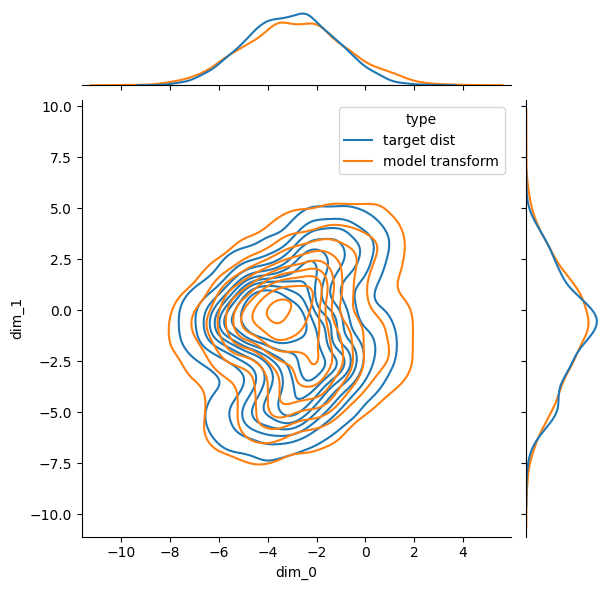

trail: 0 m step: 8 kl_test: 0.3912544250488281


  2%|▏         | 100/6000 [00:30<33:42,  2.92it/s]

trail: 0 m step: 9 Loss: 0.35321903228759766  L_n: 0.3368062973022461  kld: 0.0016412734985351562 KLD1: 0.3426471948623657 KLD2: 0.2461799681186676


  3%|▎         | 200/6000 [01:01<32:36,  2.96it/s]

trail: 0 m step: 9 Loss: 0.3731069564819336  L_n: 0.32693958282470703  kld: 0.004616737365722656 KLD1: 0.31183958053588867 KLD2: 0.22500565648078918


  5%|▌         | 300/6000 [01:32<32:14,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3342323303222656  L_n: 0.3085212707519531  kld: 0.00257110595703125 KLD1: 0.3387584388256073 KLD2: 0.2368510216474533


  7%|▋         | 400/6000 [02:02<31:41,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3623065948486328  L_n: 0.31517601013183594  kld: 0.0047130584716796875 KLD1: 0.31612756848335266 KLD2: 0.22828783094882965


  8%|▊         | 500/6000 [02:33<31:00,  2.96it/s]

trail: 0 m step: 9 Loss: 0.37879276275634766  L_n: 0.31444835662841797  kld: 0.006434440612792969 KLD1: 0.30191874504089355 KLD2: 0.23172372579574585


 10%|█         | 600/6000 [03:03<30:24,  2.96it/s]

trail: 0 m step: 9 Loss: 0.35816097259521484  L_n: 0.32352352142333984  kld: 0.0034637451171875 KLD1: 0.3172098696231842 KLD2: 0.2377740442752838


 12%|█▏        | 700/6000 [03:34<30:01,  2.94it/s]

trail: 0 m step: 9 Loss: 0.3598060607910156  L_n: 0.3401031494140625  kld: 0.0019702911376953125 KLD1: 0.3370225727558136 KLD2: 0.23430365324020386


 13%|█▎        | 800/6000 [04:05<29:24,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3381977081298828  L_n: 0.30457115173339844  kld: 0.0033626556396484375 KLD1: 0.31952494382858276 KLD2: 0.22847643494606018


 15%|█▌        | 900/6000 [04:35<28:45,  2.96it/s]

trail: 0 m step: 9 Loss: 0.37282466888427734  L_n: 0.3310537338256836  kld: 0.004177093505859375 KLD1: 0.31025344133377075 KLD2: 0.2360365241765976


 17%|█▋        | 1000/6000 [05:06<28:06,  2.96it/s]

trail: 0 m step: 9 Loss: 0.3507843017578125  L_n: 0.3121604919433594  kld: 0.0038623809814453125 KLD1: 0.3168443739414215 KLD2: 0.22864462435245514


 18%|█▊        | 1100/6000 [05:36<27:40,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3734397888183594  L_n: 0.32733917236328125  kld: 0.0046100616455078125 KLD1: 0.31278616189956665 KLD2: 0.21907924115657806


 20%|██        | 1200/6000 [06:07<26:59,  2.96it/s]

trail: 0 m step: 9 Loss: 0.36424827575683594  L_n: 0.33927154541015625  kld: 0.0024976730346679688 KLD1: 0.33416688442230225 KLD2: 0.2417210340499878


 22%|██▏       | 1300/6000 [06:37<26:28,  2.96it/s]

trail: 0 m step: 9 Loss: 0.3478546142578125  L_n: 0.3063697814941406  kld: 0.0041484832763671875 KLD1: 0.3147892355918884 KLD2: 0.23451000452041626


 23%|██▎       | 1400/6000 [07:08<25:58,  2.95it/s]

trail: 0 m step: 9 Loss: 0.34917545318603516  L_n: 0.30846309661865234  kld: 0.004071235656738281 KLD1: 0.31999412178993225 KLD2: 0.2369099110364914


 25%|██▌       | 1500/6000 [07:39<25:20,  2.96it/s]

trail: 0 m step: 9 Loss: 0.35400390625  L_n: 0.3185558319091797  kld: 0.0035448074340820312 KLD1: 0.320648729801178 KLD2: 0.22669443488121033


 27%|██▋       | 1600/6000 [08:09<24:50,  2.95it/s]

trail: 0 m step: 9 Loss: 0.36757373809814453  L_n: 0.3186502456665039  kld: 0.0048923492431640625 KLD1: 0.31765520572662354 KLD2: 0.221978560090065


 28%|██▊       | 1700/6000 [08:40<24:11,  2.96it/s]

trail: 0 m step: 9 Loss: 0.34832286834716797  L_n: 0.31979846954345703  kld: 0.0028524398803710938 KLD1: 0.32165297865867615 KLD2: 0.2341577559709549


 30%|███       | 1800/6000 [09:11<23:44,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3593873977661133  L_n: 0.31000614166259766  kld: 0.0049381256103515625 KLD1: 0.30686184763908386 KLD2: 0.22762136161327362


 32%|███▏      | 1900/6000 [09:41<23:12,  2.94it/s]

trail: 0 m step: 9 Loss: 0.3409595489501953  L_n: 0.3215808868408203  kld: 0.0019378662109375 KLD1: 0.3417396545410156 KLD2: 0.23099198937416077


 33%|███▎      | 2000/6000 [10:12<23:41,  2.81it/s]

trail: 0 m step: 9 Loss: 0.36837291717529297  L_n: 0.32354068756103516  kld: 0.004483222961425781 KLD1: 0.30473756790161133 KLD2: 0.22526191174983978


 35%|███▌      | 2100/6000 [10:43<22:02,  2.95it/s]

trail: 0 m step: 9 Loss: 0.34082603454589844  L_n: 0.3198833465576172  kld: 0.002094268798828125 KLD1: 0.3330182433128357 KLD2: 0.23776818811893463


 37%|███▋      | 2200/6000 [11:13<21:25,  2.96it/s]

trail: 0 m step: 9 Loss: 0.3649778366088867  L_n: 0.3241128921508789  kld: 0.004086494445800781 KLD1: 0.3091816306114197 KLD2: 0.24324508011341095


 38%|███▊      | 2300/6000 [11:44<20:53,  2.95it/s]

trail: 0 m step: 9 Loss: 0.35892581939697266  L_n: 0.3216371536254883  kld: 0.0037288665771484375 KLD1: 0.32144269347190857 KLD2: 0.23070460557937622


 40%|████      | 2400/6000 [12:14<20:21,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3403177261352539  L_n: 0.3154935836791992  kld: 0.0024824142456054688 KLD1: 0.32587605714797974 KLD2: 0.2362309992313385


 42%|████▏     | 2500/6000 [12:45<19:44,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3523540496826172  L_n: 0.3152942657470703  kld: 0.0037059783935546875 KLD1: 0.31807631254196167 KLD2: 0.22981134057044983


 43%|████▎     | 2600/6000 [13:16<19:15,  2.94it/s]

trail: 0 m step: 9 Loss: 0.3634452819824219  L_n: 0.32367706298828125  kld: 0.0039768218994140625 KLD1: 0.3114343285560608 KLD2: 0.23109585046768188


 45%|████▌     | 2700/6000 [13:46<18:39,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3617076873779297  L_n: 0.32331275939941406  kld: 0.0038394927978515625 KLD1: 0.3150278329849243 KLD2: 0.23051244020462036


 47%|████▋     | 2800/6000 [14:17<18:02,  2.96it/s]

trail: 0 m step: 9 Loss: 0.3300199508666992  L_n: 0.3002748489379883  kld: 0.0029745101928710938 KLD1: 0.3196582794189453 KLD2: 0.22730086743831635


 48%|████▊     | 2900/6000 [14:48<17:27,  2.96it/s]

trail: 0 m step: 9 Loss: 0.3497943878173828  L_n: 0.3181896209716797  kld: 0.0031604766845703125 KLD1: 0.3220841884613037 KLD2: 0.22765839099884033


 50%|█████     | 3000/6000 [15:18<16:56,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3599729537963867  L_n: 0.3167428970336914  kld: 0.004323005676269531 KLD1: 0.31095853447914124 KLD2: 0.23679284751415253


 52%|█████▏    | 3100/6000 [15:49<16:23,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3617115020751953  L_n: 0.3081626892089844  kld: 0.005354881286621094 KLD1: 0.3059329390525818 KLD2: 0.22566737234592438


 53%|█████▎    | 3200/6000 [16:20<15:46,  2.96it/s]

trail: 0 m step: 9 Loss: 0.37217044830322266  L_n: 0.32334232330322266  kld: 0.0048828125 KLD1: 0.3052034080028534 KLD2: 0.2325228899717331


 55%|█████▌    | 3300/6000 [16:50<15:16,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3818035125732422  L_n: 0.3392982482910156  kld: 0.004250526428222656 KLD1: 0.3154870867729187 KLD2: 0.23923175036907196


 57%|█████▋    | 3400/6000 [17:21<14:43,  2.94it/s]

trail: 0 m step: 9 Loss: 0.36374568939208984  L_n: 0.32691478729248047  kld: 0.0036830902099609375 KLD1: 0.32331112027168274 KLD2: 0.2351641058921814


 58%|█████▊    | 3500/6000 [17:51<14:06,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3664283752441406  L_n: 0.33452796936035156  kld: 0.0031900405883789062 KLD1: 0.3263646364212036 KLD2: 0.22526314854621887


 60%|██████    | 3600/6000 [18:22<13:32,  2.95it/s]

trail: 0 m step: 9 Loss: 0.35750484466552734  L_n: 0.2966890335083008  kld: 0.006081581115722656 KLD1: 0.29984521865844727 KLD2: 0.2268773317337036


 62%|██████▏   | 3700/6000 [18:53<13:00,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3690824508666992  L_n: 0.3258047103881836  kld: 0.0043277740478515625 KLD1: 0.3096809387207031 KLD2: 0.22553294897079468


 63%|██████▎   | 3800/6000 [19:23<13:05,  2.80it/s]

trail: 0 m step: 9 Loss: 0.3586721420288086  L_n: 0.3262186050415039  kld: 0.0032453536987304688 KLD1: 0.3241669535636902 KLD2: 0.22458602488040924


 65%|██████▌   | 3900/6000 [19:54<11:53,  2.94it/s]

trail: 0 m step: 9 Loss: 0.3514986038208008  L_n: 0.3177957534790039  kld: 0.0033702850341796875 KLD1: 0.3130511939525604 KLD2: 0.23746605217456818


 67%|██████▋   | 4000/6000 [20:25<11:17,  2.95it/s]

trail: 0 m step: 9 Loss: 0.36057281494140625  L_n: 0.32827186584472656  kld: 0.0032300949096679688 KLD1: 0.3240569233894348 KLD2: 0.22824877500534058


 68%|██████▊   | 4100/6000 [20:55<10:43,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3338460922241211  L_n: 0.31964588165283203  kld: 0.0014200210571289062 KLD1: 0.3381426930427551 KLD2: 0.22534464299678802


 70%|███████   | 4200/6000 [21:26<10:10,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3409395217895508  L_n: 0.3154478073120117  kld: 0.0025491714477539062 KLD1: 0.32344865798950195 KLD2: 0.22842831909656525


 72%|███████▏  | 4300/6000 [21:56<09:35,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3658456802368164  L_n: 0.3236551284790039  kld: 0.00421905517578125 KLD1: 0.3214245140552521 KLD2: 0.22744013369083405


 73%|███████▎  | 4400/6000 [22:27<09:01,  2.95it/s]

trail: 0 m step: 9 Loss: 0.34761619567871094  L_n: 0.3078765869140625  kld: 0.003973960876464844 KLD1: 0.3156704008579254 KLD2: 0.21905456483364105


 75%|███████▌  | 4500/6000 [22:58<08:29,  2.94it/s]

trail: 0 m step: 9 Loss: 0.3661823272705078  L_n: 0.3190803527832031  kld: 0.004710197448730469 KLD1: 0.30056777596473694 KLD2: 0.22252924740314484


 77%|███████▋  | 4600/6000 [23:28<07:54,  2.95it/s]

trail: 0 m step: 9 Loss: 0.36675262451171875  L_n: 0.3116874694824219  kld: 0.0055065155029296875 KLD1: 0.2965768873691559 KLD2: 0.22895780205726624


 78%|███████▊  | 4700/6000 [23:59<07:20,  2.95it/s]

trail: 0 m step: 9 Loss: 0.35199928283691406  L_n: 0.3126506805419922  kld: 0.0039348602294921875 KLD1: 0.3156823515892029 KLD2: 0.22852832078933716


 80%|████████  | 4800/6000 [24:30<06:46,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3341865539550781  L_n: 0.2950859069824219  kld: 0.003910064697265625 KLD1: 0.3100156784057617 KLD2: 0.22427819669246674


 82%|████████▏ | 4900/6000 [25:00<06:13,  2.94it/s]

trail: 0 m step: 9 Loss: 0.35619354248046875  L_n: 0.3238067626953125  kld: 0.003238677978515625 KLD1: 0.33043530583381653 KLD2: 0.22694046795368195


 83%|████████▎ | 5000/6000 [25:31<05:38,  2.96it/s]

trail: 0 m step: 9 Loss: 0.34906578063964844  L_n: 0.31046104431152344  kld: 0.0038604736328125 KLD1: 0.3114737570285797 KLD2: 0.23296117782592773


 85%|████████▌ | 5100/6000 [26:02<05:05,  2.95it/s]

trail: 0 m step: 9 Loss: 0.34549427032470703  L_n: 0.3063650131225586  kld: 0.003912925720214844 KLD1: 0.31217458844184875 KLD2: 0.22935375571250916


 87%|████████▋ | 5200/6000 [26:32<04:31,  2.95it/s]

trail: 0 m step: 9 Loss: 0.33505821228027344  L_n: 0.3099479675292969  kld: 0.0025110244750976562 KLD1: 0.33318930864334106 KLD2: 0.23677445948123932


 88%|████████▊ | 5300/6000 [27:03<03:57,  2.95it/s]

trail: 0 m step: 9 Loss: 0.35806846618652344  L_n: 0.31254005432128906  kld: 0.0045528411865234375 KLD1: 0.30124542117118835 KLD2: 0.22301317751407623


 90%|█████████ | 5400/6000 [27:33<03:22,  2.96it/s]

trail: 0 m step: 9 Loss: 0.3857603073120117  L_n: 0.3364267349243164  kld: 0.004933357238769531 KLD1: 0.30030229687690735 KLD2: 0.22787748277187347


 92%|█████████▏| 5500/6000 [28:04<02:50,  2.94it/s]

trail: 0 m step: 9 Loss: 0.3568410873413086  L_n: 0.3172922134399414  kld: 0.003954887390136719 KLD1: 0.3156653344631195 KLD2: 0.22742491960525513


 93%|█████████▎| 5600/6000 [28:35<02:26,  2.74it/s]

trail: 0 m step: 9 Loss: 0.37921905517578125  L_n: 0.33161163330078125  kld: 0.0047607421875 KLD1: 0.30846527218818665 KLD2: 0.22268329560756683


 95%|█████████▌| 5700/6000 [29:05<01:42,  2.94it/s]

trail: 0 m step: 9 Loss: 0.3388652801513672  L_n: 0.3114948272705078  kld: 0.0027370452880859375 KLD1: 0.3251197338104248 KLD2: 0.22757260501384735


 97%|█████████▋| 5800/6000 [29:36<01:07,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3456439971923828  L_n: 0.31569862365722656  kld: 0.002994537353515625 KLD1: 0.3287486433982849 KLD2: 0.22897875308990479


 98%|█████████▊| 5900/6000 [30:07<00:33,  2.95it/s]

trail: 0 m step: 9 Loss: 0.3597698211669922  L_n: 0.3201923370361328  kld: 0.0039577484130859375 KLD1: 0.31451189517974854 KLD2: 0.22308985888957977


100%|██████████| 6000/6000 [30:37<00:00,  3.26it/s]

trail: 0 m step: 9 Loss: 0.3410310745239258  L_n: 0.3075857162475586  kld: 0.0033445358276367188 KLD1: 0.3197818994522095 KLD2: 0.22575192153453827



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


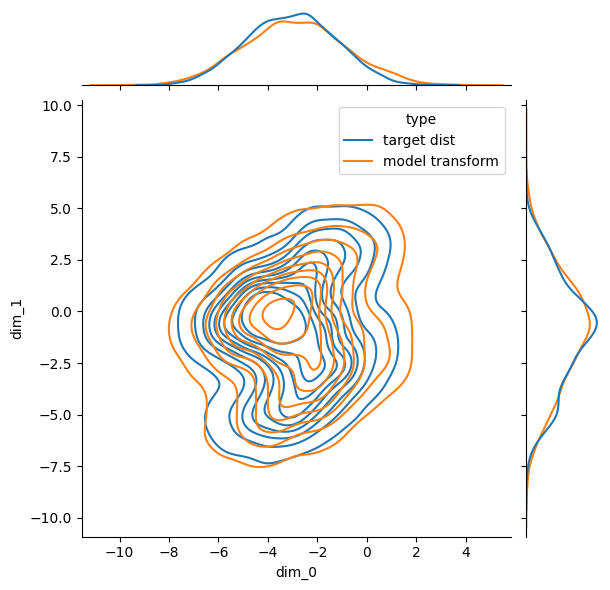

trail: 0 m step: 9 kl_test: 0.31015872955322266


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer_lr_input = optimizer_lr * (outer_lr_factor**mirror_itr)
  optimizer = torch.optim.Adam(model2.parameters(), lr=optimizer_lr_input, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = eta
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


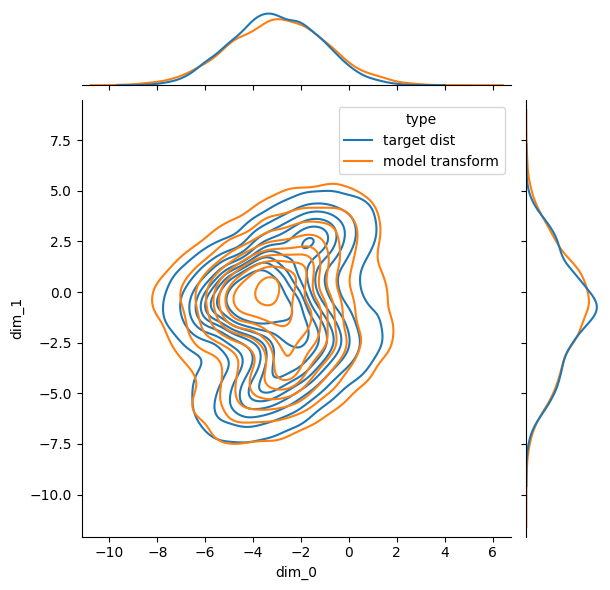

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

  2%|▏         | 100/6000 [00:30<34:08,  2.88it/s]

trail: 0 m step: 0 Loss: 0.2820701599121094  L_n: 0.2710552215576172  kld: 0.0011014938354492188 KLD1: 0.2764436602592468 KLD2: 0.2044508308172226


  3%|▎         | 200/6000 [01:01<32:40,  2.96it/s]

trail: 0 m step: 0 Loss: 0.30118560791015625  L_n: 0.2646217346191406  kld: 0.0036563873291015625 KLD1: 0.25126078724861145 KLD2: 0.18538591265678406


  5%|▌         | 300/6000 [01:32<32:04,  2.96it/s]

trail: 0 m step: 0 Loss: 0.26703453063964844  L_n: 0.24905776977539062  kld: 0.0017976760864257812 KLD1: 0.2733246386051178 KLD2: 0.19576364755630493


  7%|▋         | 400/6000 [02:02<31:51,  2.93it/s]

trail: 0 m step: 0 Loss: 0.2927112579345703  L_n: 0.25506019592285156  kld: 0.003765106201171875 KLD1: 0.2553633153438568 KLD2: 0.18808206915855408


  8%|▊         | 500/6000 [02:33<30:59,  2.96it/s]

trail: 0 m step: 0 Loss: 0.3065834045410156  L_n: 0.25197601318359375  kld: 0.0054607391357421875 KLD1: 0.24455086886882782 KLD2: 0.19168968498706818


 10%|█         | 600/6000 [03:04<30:32,  2.95it/s]

trail: 0 m step: 0 Loss: 0.2863483428955078  L_n: 0.2603797912597656  kld: 0.0025968551635742188 KLD1: 0.2538081705570221 KLD2: 0.19683758914470673


 12%|█▏        | 700/6000 [03:34<30:05,  2.94it/s]

trail: 0 m step: 0 Loss: 0.29048919677734375  L_n: 0.27548789978027344  kld: 0.0015001296997070312 KLD1: 0.270317405462265 KLD2: 0.193495973944664


 13%|█▎        | 800/6000 [04:05<29:19,  2.96it/s]

trail: 0 m step: 0 Loss: 0.27226924896240234  L_n: 0.24439334869384766  kld: 0.0027875900268554688 KLD1: 0.2560102343559265 KLD2: 0.1889917254447937


 15%|█▌        | 900/6000 [04:36<28:54,  2.94it/s]

trail: 0 m step: 0 Loss: 0.29804515838623047  L_n: 0.26537227630615234  kld: 0.0032672882080078125 KLD1: 0.24857357144355774 KLD2: 0.19538970291614532


 17%|█▋        | 1000/6000 [05:07<28:16,  2.95it/s]

trail: 0 m step: 0 Loss: 0.2815361022949219  L_n: 0.25034141540527344  kld: 0.0031194686889648438 KLD1: 0.25395870208740234 KLD2: 0.1883333921432495


 18%|█▊        | 1100/6000 [05:37<27:48,  2.94it/s]

trail: 0 m step: 0 Loss: 0.3008852005004883  L_n: 0.26375865936279297  kld: 0.0037126541137695312 KLD1: 0.25394532084465027 KLD2: 0.18024149537086487


 20%|██        | 1200/6000 [06:08<27:08,  2.95it/s]

trail: 0 m step: 0 Loss: 0.29193973541259766  L_n: 0.2742490768432617  kld: 0.0017690658569335938 KLD1: 0.26941677927970886 KLD2: 0.20099236071109772


 22%|██▏       | 1300/6000 [06:39<26:35,  2.95it/s]

trail: 0 m step: 0 Loss: 0.27840614318847656  L_n: 0.2466869354248047  kld: 0.0031719207763671875 KLD1: 0.2542659044265747 KLD2: 0.19494463503360748


 23%|██▎       | 1400/6000 [07:09<26:03,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2805595397949219  L_n: 0.2481060028076172  kld: 0.0032453536987304688 KLD1: 0.25949835777282715 KLD2: 0.1961175948381424


 25%|██▌       | 1500/6000 [07:40<25:29,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2825336456298828  L_n: 0.256622314453125  kld: 0.0025911331176757812 KLD1: 0.258669912815094 KLD2: 0.1870819628238678


 27%|██▋       | 1600/6000 [08:11<24:51,  2.95it/s]

trail: 0 m step: 0 Loss: 0.29573631286621094  L_n: 0.2558155059814453  kld: 0.0039920806884765625 KLD1: 0.25615134835243225 KLD2: 0.1827283650636673


 28%|██▊       | 1700/6000 [08:41<24:21,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2781553268432617  L_n: 0.25739383697509766  kld: 0.0020761489868164062 KLD1: 0.2564545273780823 KLD2: 0.1940148025751114


 30%|███       | 1800/6000 [09:12<23:48,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2874765396118164  L_n: 0.24785137176513672  kld: 0.003962516784667969 KLD1: 0.24753183126449585 KLD2: 0.18841813504695892


 32%|███▏      | 1900/6000 [09:43<23:10,  2.95it/s]

trail: 0 m step: 0 Loss: 0.27340030670166016  L_n: 0.25984859466552734  kld: 0.0013551712036132812 KLD1: 0.2768765091896057 KLD2: 0.19146648049354553


 33%|███▎      | 2000/6000 [10:13<22:36,  2.95it/s]

trail: 0 m step: 0 Loss: 0.29593849182128906  L_n: 0.25916481018066406  kld: 0.0036773681640625 KLD1: 0.24315431714057922 KLD2: 0.1853821724653244


 35%|███▌      | 2100/6000 [10:44<22:06,  2.94it/s]

trail: 0 m step: 0 Loss: 0.27233123779296875  L_n: 0.2582740783691406  kld: 0.0014057159423828125 KLD1: 0.26918303966522217 KLD2: 0.19735988974571228


 37%|███▋      | 2200/6000 [11:15<21:34,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2933950424194336  L_n: 0.26117992401123047  kld: 0.0032215118408203125 KLD1: 0.24849309027194977 KLD2: 0.20228233933448792


 38%|███▊      | 2300/6000 [11:45<21:01,  2.93it/s]

trail: 0 m step: 0 Loss: 0.28759002685546875  L_n: 0.260009765625  kld: 0.002758026123046875 KLD1: 0.260498970746994 KLD2: 0.19138206541538239


 40%|████      | 2400/6000 [12:16<20:22,  2.94it/s]

trail: 0 m step: 0 Loss: 0.27071475982666016  L_n: 0.2542257308959961  kld: 0.0016489028930664062 KLD1: 0.26643162965774536 KLD2: 0.19600698351860046


 42%|████▏     | 2500/6000 [12:47<19:51,  2.94it/s]

trail: 0 m step: 0 Loss: 0.28327178955078125  L_n: 0.2537555694580078  kld: 0.0029516220092773438 KLD1: 0.25559407472610474 KLD2: 0.1902185082435608


 43%|████▎     | 2600/6000 [13:17<19:16,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2924346923828125  L_n: 0.26172637939453125  kld: 0.003070831298828125 KLD1: 0.2514559030532837 KLD2: 0.19122391939163208


 45%|████▌     | 2700/6000 [13:48<18:39,  2.95it/s]

trail: 0 m step: 0 Loss: 0.29021263122558594  L_n: 0.2609825134277344  kld: 0.0029230117797851562 KLD1: 0.2536849081516266 KLD2: 0.19072723388671875


 47%|████▋     | 2800/6000 [14:19<18:08,  2.94it/s]

trail: 0 m step: 0 Loss: 0.26070594787597656  L_n: 0.23870468139648438  kld: 0.0022001266479492188 KLD1: 0.25926855206489563 KLD2: 0.18783563375473022


 48%|████▊     | 2900/6000 [14:50<17:32,  2.95it/s]

trail: 0 m step: 0 Loss: 0.28173828125  L_n: 0.2585163116455078  kld: 0.0023221969604492188 KLD1: 0.26266923546791077 KLD2: 0.1881052702665329


 50%|█████     | 3000/6000 [15:20<16:58,  2.95it/s]

trail: 0 m step: 0 Loss: 0.2901163101196289  L_n: 0.25533580780029297  kld: 0.0034780502319335938 KLD1: 0.24974848330020905 KLD2: 0.19658704102039337


 52%|█████▏    | 3100/6000 [15:51<16:26,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2920188903808594  L_n: 0.24788284301757812  kld: 0.004413604736328125 KLD1: 0.247621089220047 KLD2: 0.18619513511657715


 53%|█████▎    | 3200/6000 [16:22<15:49,  2.95it/s]

trail: 0 m step: 0 Loss: 0.29830455780029297  L_n: 0.25980472564697266  kld: 0.0038499832153320312 KLD1: 0.24537943303585052 KLD2: 0.1922117918729782


 55%|█████▌    | 3300/6000 [16:52<15:18,  2.94it/s]

trail: 0 m step: 0 Loss: 0.3108205795288086  L_n: 0.2762022018432617  kld: 0.0034618377685546875 KLD1: 0.2531413435935974 KLD2: 0.1985160857439041


 57%|█████▋    | 3400/6000 [17:23<14:45,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2909564971923828  L_n: 0.26274681091308594  kld: 0.0028209686279296875 KLD1: 0.25862011313438416 KLD2: 0.1949976533651352


 58%|█████▊    | 3500/6000 [17:54<14:10,  2.94it/s]

trail: 0 m step: 0 Loss: 0.293731689453125  L_n: 0.27008056640625  kld: 0.0023651123046875 KLD1: 0.2643616199493408 KLD2: 0.18574726581573486


 60%|██████    | 3600/6000 [18:24<13:37,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2884969711303711  L_n: 0.23938274383544922  kld: 0.0049114227294921875 KLD1: 0.24105395376682281 KLD2: 0.18778716027736664


 62%|██████▏   | 3700/6000 [18:55<13:01,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2954273223876953  L_n: 0.26164817810058594  kld: 0.0033779144287109375 KLD1: 0.2489909678697586 KLD2: 0.1860746294260025


 63%|██████▎   | 3800/6000 [19:26<12:29,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2883481979370117  L_n: 0.26242733001708984  kld: 0.0025920867919921875 KLD1: 0.26041144132614136 KLD2: 0.18515577912330627


 65%|██████▌   | 3900/6000 [19:57<11:52,  2.95it/s]

trail: 0 m step: 0 Loss: 0.2826709747314453  L_n: 0.2566356658935547  kld: 0.0026035308837890625 KLD1: 0.2520137131214142 KLD2: 0.19745013117790222


 67%|██████▋   | 4000/6000 [20:27<11:17,  2.95it/s]

trail: 0 m step: 0 Loss: 0.2892875671386719  L_n: 0.26541709899902344  kld: 0.0023870468139648438 KLD1: 0.26117458939552307 KLD2: 0.18888500332832336


 68%|██████▊   | 4100/6000 [20:58<10:46,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2677602767944336  L_n: 0.25823307037353516  kld: 0.0009527206420898438 KLD1: 0.271535724401474 KLD2: 0.18618151545524597


 70%|███████   | 4200/6000 [21:29<10:11,  2.94it/s]

trail: 0 m step: 0 Loss: 0.27234458923339844  L_n: 0.2540435791015625  kld: 0.0018301010131835938 KLD1: 0.26104265451431274 KLD2: 0.1885436773300171


 72%|███████▏  | 4300/6000 [21:59<09:38,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2957134246826172  L_n: 0.26225852966308594  kld: 0.003345489501953125 KLD1: 0.2599027156829834 KLD2: 0.18770216405391693


 73%|███████▎  | 4400/6000 [22:30<09:02,  2.95it/s]

trail: 0 m step: 0 Loss: 0.277740478515625  L_n: 0.24724197387695312  kld: 0.0030498504638671875 KLD1: 0.2546866536140442 KLD2: 0.1808646023273468


 75%|███████▌  | 4500/6000 [23:01<08:29,  2.95it/s]

trail: 0 m step: 0 Loss: 0.29648590087890625  L_n: 0.2593212127685547  kld: 0.0037164688110351562 KLD1: 0.23906435072422028 KLD2: 0.1834471970796585


 77%|███████▋  | 4600/6000 [23:31<07:56,  2.94it/s]

trail: 0 m step: 0 Loss: 0.295867919921875  L_n: 0.2508354187011719  kld: 0.0045032501220703125 KLD1: 0.2383650839328766 KLD2: 0.18927185237407684


 78%|███████▊  | 4700/6000 [24:02<07:22,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2797212600708008  L_n: 0.2502145767211914  kld: 0.0029506683349609375 KLD1: 0.254455029964447 KLD2: 0.18912282586097717


 80%|████████  | 4800/6000 [24:33<06:48,  2.94it/s]

trail: 0 m step: 0 Loss: 0.26451587677001953  L_n: 0.23414134979248047  kld: 0.0030374526977539062 KLD1: 0.2507743239402771 KLD2: 0.18504810333251953


 82%|████████▏ | 4900/6000 [25:03<06:14,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2873649597167969  L_n: 0.2625598907470703  kld: 0.0024805068969726562 KLD1: 0.26657092571258545 KLD2: 0.18743407726287842


 83%|████████▎ | 5000/6000 [25:34<05:38,  2.95it/s]

trail: 0 m step: 0 Loss: 0.2797660827636719  L_n: 0.24936294555664062  kld: 0.003040313720703125 KLD1: 0.24909791350364685 KLD2: 0.19270311295986176


 85%|████████▌ | 5100/6000 [26:05<05:05,  2.95it/s]

trail: 0 m step: 0 Loss: 0.2749471664428711  L_n: 0.24486827850341797  kld: 0.0030078887939453125 KLD1: 0.2519262135028839 KLD2: 0.18968546390533447


 87%|████████▋ | 5200/6000 [26:36<04:31,  2.94it/s]

trail: 0 m step: 0 Loss: 0.26826953887939453  L_n: 0.2506837844848633  kld: 0.001758575439453125 KLD1: 0.26955926418304443 KLD2: 0.19621242582798004


 88%|████████▊ | 5300/6000 [27:06<03:58,  2.94it/s]

trail: 0 m step: 0 Loss: 0.29007434844970703  L_n: 0.25246143341064453  kld: 0.00376129150390625 KLD1: 0.24058261513710022 KLD2: 0.18390998244285583


 90%|█████████ | 5400/6000 [27:37<03:24,  2.94it/s]

trail: 0 m step: 0 Loss: 0.31392478942871094  L_n: 0.2734699249267578  kld: 0.0040454864501953125 KLD1: 0.24148593842983246 KLD2: 0.1885194480419159


 92%|█████████▏| 5500/6000 [28:08<02:50,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2859354019165039  L_n: 0.2567720413208008  kld: 0.0029163360595703125 KLD1: 0.2592020034790039 KLD2: 0.1881493628025055


 93%|█████████▎| 5600/6000 [28:38<02:16,  2.94it/s]

trail: 0 m step: 0 Loss: 0.30611515045166016  L_n: 0.26763439178466797  kld: 0.0038480758666992188 KLD1: 0.2502519190311432 KLD2: 0.18344484269618988


 95%|█████████▌| 5700/6000 [29:09<01:42,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2711324691772461  L_n: 0.2512197494506836  kld: 0.00199127197265625 KLD1: 0.2624390125274658 KLD2: 0.1880292296409607


 97%|█████████▋| 5800/6000 [29:40<01:07,  2.95it/s]

trail: 0 m step: 0 Loss: 0.27683067321777344  L_n: 0.25444793701171875  kld: 0.0022382736206054688 KLD1: 0.2662237584590912 KLD2: 0.18922647833824158


 98%|█████████▊| 5900/6000 [30:10<00:33,  2.94it/s]

trail: 0 m step: 0 Loss: 0.2897682189941406  L_n: 0.2584209442138672  kld: 0.0031347274780273438 KLD1: 0.2521058917045593 KLD2: 0.18365231156349182


100%|██████████| 6000/6000 [30:41<00:00,  3.26it/s]

trail: 0 m step: 0 Loss: 0.2726602554321289  L_n: 0.24713993072509766  kld: 0.002552032470703125 KLD1: 0.2569957375526428 KLD2: 0.18628934025764465



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


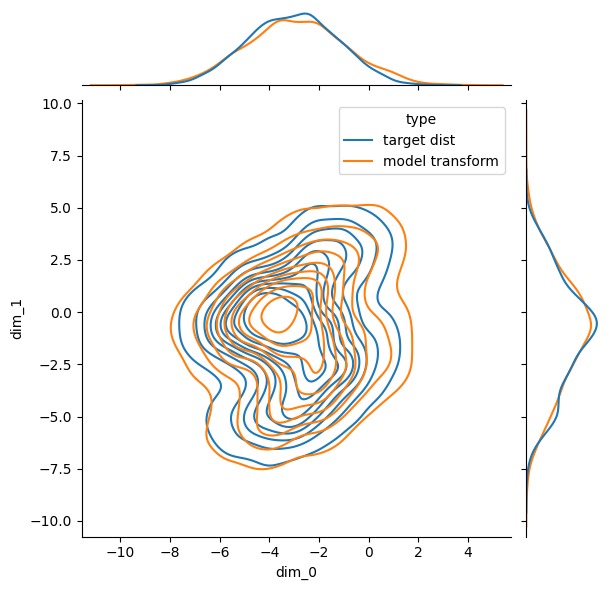

trail: 0 m step: 0 kl_test: 0.24822235107421875


  2%|▏         | 100/6000 [00:30<33:51,  2.90it/s]

trail: 0 m step: 1 Loss: 0.2217980164747972  L_n: 0.21004581451416016  kld: 0.0015277862548828125 KLD1: 0.21536122262477875 KLD2: 0.16395944356918335


  3%|▎         | 200/6000 [01:01<32:40,  2.96it/s]

trail: 0 m step: 1 Loss: 0.2397455802330604  L_n: 0.20814228057861328  kld: 0.004108428955078125 KLD1: 0.19637462496757507 KLD2: 0.14727194607257843


  5%|▌         | 300/6000 [01:32<32:15,  2.94it/s]

trail: 0 m step: 1 Loss: 0.20985713371863732  L_n: 0.19283771514892578  kld: 0.0022125244140625 KLD1: 0.21141278743743896 KLD2: 0.15566596388816833


  7%|▋         | 400/6000 [02:02<31:31,  2.96it/s]

trail: 0 m step: 1 Loss: 0.23082322340745193  L_n: 0.19800949096679688  kld: 0.004265785217285156 KLD1: 0.19989122450351715 KLD2: 0.14912766218185425


  8%|▊         | 500/6000 [02:33<31:01,  2.95it/s]

trail: 0 m step: 1 Loss: 0.24159871614896333  L_n: 0.1945018768310547  kld: 0.006122589111328125 KLD1: 0.18970324099063873 KLD2: 0.15278273820877075


 10%|█         | 600/6000 [03:04<30:26,  2.96it/s]

trail: 0 m step: 1 Loss: 0.22493267059326172  L_n: 0.20013713836669922  kld: 0.003223419189453125 KLD1: 0.1939365714788437 KLD2: 0.15588611364364624


 12%|█▏        | 700/6000 [03:34<29:57,  2.95it/s]

trail: 0 m step: 1 Loss: 0.22811016669640174  L_n: 0.2131814956665039  kld: 0.0019407272338867188 KLD1: 0.20769628882408142 KLD2: 0.15270301699638367


 13%|█▎        | 800/6000 [04:05<29:28,  2.94it/s]

trail: 0 m step: 1 Loss: 0.2131668237539438  L_n: 0.1872415542602539  kld: 0.0033702850341796875 KLD1: 0.1958058774471283 KLD2: 0.1499897688627243


 15%|█▌        | 900/6000 [04:36<28:55,  2.94it/s]

trail: 0 m step: 1 Loss: 0.23596873650184044  L_n: 0.20531177520751953  kld: 0.003985404968261719 KLD1: 0.1911345273256302 KLD2: 0.1550004631280899


 17%|█▋        | 1000/6000 [05:06<28:10,  2.96it/s]

trail: 0 m step: 1 Loss: 0.22371915670541617  L_n: 0.19466876983642578  kld: 0.00377655029296875 KLD1: 0.19470427930355072 KLD2: 0.14859943091869354


 18%|█▊        | 1100/6000 [05:37<27:39,  2.95it/s]

trail: 0 m step: 1 Loss: 0.23573171175443208  L_n: 0.20131874084472656  kld: 0.004473686218261719 KLD1: 0.197978213429451 KLD2: 0.14140719175338745


 20%|██        | 1200/6000 [06:08<27:14,  2.94it/s]

trail: 0 m step: 1 Loss: 0.22912201514610878  L_n: 0.21123695373535156  kld: 0.0023250579833984375 KLD1: 0.20630888640880585 KLD2: 0.15992803871631622


 22%|██▏       | 1300/6000 [06:39<26:36,  2.94it/s]

trail: 0 m step: 1 Loss: 0.21687060136061448  L_n: 0.18903064727783203  kld: 0.0036191940307617188 KLD1: 0.19571882486343384 KLD2: 0.15510334074497223


 23%|██▎       | 1400/6000 [07:09<25:59,  2.95it/s]

trail: 0 m step: 1 Loss: 0.21784144181471604  L_n: 0.18857097625732422  kld: 0.0038051605224609375 KLD1: 0.19916951656341553 KLD2: 0.15499208867549896


 25%|██▌       | 1500/6000 [07:40<25:29,  2.94it/s]

trail: 0 m step: 1 Loss: 0.2212201631986178  L_n: 0.19695281982421875  kld: 0.003154754638671875 KLD1: 0.19750885665416718 KLD2: 0.14724089205265045


 27%|██▋       | 1600/6000 [08:11<24:54,  2.94it/s]

trail: 0 m step: 1 Loss: 0.2330923080444336  L_n: 0.1976156234741211  kld: 0.004611968994140625 KLD1: 0.196492537856102 KLD2: 0.14390751719474792


 28%|██▊       | 1700/6000 [08:41<24:18,  2.95it/s]

trail: 0 m step: 1 Loss: 0.21757800762469953  L_n: 0.19876861572265625  kld: 0.002445220947265625 KLD1: 0.19550448656082153 KLD2: 0.15380921959877014


 30%|███       | 1800/6000 [09:12<23:47,  2.94it/s]

trail: 0 m step: 1 Loss: 0.22663013751690203  L_n: 0.1907939910888672  kld: 0.004658699035644531 KLD1: 0.19109885394573212 KLD2: 0.14936000108718872


 32%|███▏      | 1900/6000 [09:43<23:11,  2.95it/s]

trail: 0 m step: 1 Loss: 0.21460606501652643  L_n: 0.20227432250976562  kld: 0.0016031265258789062 KLD1: 0.2138589769601822 KLD2: 0.1520557403564453


 33%|███▎      | 2000/6000 [10:13<22:35,  2.95it/s]

trail: 0 m step: 1 Loss: 0.2342372307410607  L_n: 0.1975574493408203  kld: 0.00476837158203125 KLD1: 0.18537089228630066 KLD2: 0.14557264745235443


 35%|███▌      | 2100/6000 [10:44<22:06,  2.94it/s]

trail: 0 m step: 1 Loss: 0.21346620412973258  L_n: 0.1992931365966797  kld: 0.001842498779296875 KLD1: 0.20783378183841705 KLD2: 0.15658962726593018


 37%|███▋      | 2200/6000 [11:15<21:30,  2.94it/s]

trail: 0 m step: 1 Loss: 0.23144898047814003  L_n: 0.2017383575439453  kld: 0.0038623809814453125 KLD1: 0.1919618546962738 KLD2: 0.1609800010919571


 38%|███▊      | 2300/6000 [11:46<20:55,  2.95it/s]

trail: 0 m step: 1 Loss: 0.22665551992563102  L_n: 0.20180130004882812  kld: 0.003231048583984375 KLD1: 0.19918331503868103 KLD2: 0.15223674476146698


 40%|████      | 2400/6000 [12:16<20:26,  2.93it/s]

trail: 0 m step: 1 Loss: 0.21082570002629206  L_n: 0.19496536254882812  kld: 0.0020618438720703125 KLD1: 0.20771920680999756 KLD2: 0.15566541254520416


 42%|████▏     | 2500/6000 [12:47<19:50,  2.94it/s]

trail: 0 m step: 1 Loss: 0.22361366565410906  L_n: 0.19626522064208984  kld: 0.0035552978515625 KLD1: 0.19693107903003693 KLD2: 0.150377094745636


 43%|████▎     | 2600/6000 [13:18<19:15,  2.94it/s]

trail: 0 m step: 1 Loss: 0.22950025705190805  L_n: 0.2008533477783203  kld: 0.0037240982055664062 KLD1: 0.19166329503059387 KLD2: 0.15146416425704956


 45%|████▌     | 2700/6000 [13:48<18:38,  2.95it/s]

trail: 0 m step: 1 Loss: 0.22631381108210635  L_n: 0.2002124786376953  kld: 0.0033931732177734375 KLD1: 0.19465672969818115 KLD2: 0.15083399415016174


 47%|████▋     | 2800/6000 [14:19<18:02,  2.96it/s]

trail: 0 m step: 1 Loss: 0.20337985112116885  L_n: 0.18166542053222656  kld: 0.0028228759765625 KLD1: 0.20123693346977234 KLD2: 0.14824560284614563


 48%|████▊     | 2900/6000 [14:50<17:32,  2.95it/s]

trail: 0 m step: 1 Loss: 0.2210836410522461  L_n: 0.19981670379638672  kld: 0.0027647018432617188 KLD1: 0.20520979166030884 KLD2: 0.14855098724365234


 50%|█████     | 3000/6000 [15:20<16:56,  2.95it/s]

trail: 0 m step: 1 Loss: 0.22623186845045823  L_n: 0.19534015655517578  kld: 0.004015922546386719 KLD1: 0.19152292609214783 KLD2: 0.15637695789337158


 52%|█████▏    | 3100/6000 [15:51<16:25,  2.94it/s]

trail: 0 m step: 1 Loss: 0.22839685586782602  L_n: 0.18925952911376953  kld: 0.005087852478027344 KLD1: 0.19152802228927612 KLD2: 0.14666630327701569


 53%|█████▎    | 3200/6000 [16:22<15:52,  2.94it/s]

trail: 0 m step: 1 Loss: 0.23386595799372745  L_n: 0.1982278823852539  kld: 0.0046329498291015625 KLD1: 0.18908551335334778 KLD2: 0.15168994665145874


 55%|█████▌    | 3300/6000 [16:52<15:16,  2.94it/s]

trail: 0 m step: 1 Loss: 0.24620716388408953  L_n: 0.21409034729003906  kld: 0.0041751861572265625 KLD1: 0.19525903463363647 KLD2: 0.15747208893299103


 57%|█████▋    | 3400/6000 [17:23<14:42,  2.95it/s]

trail: 0 m step: 1 Loss: 0.22858091501089242  L_n: 0.2029857635498047  kld: 0.0033273696899414062 KLD1: 0.19671820104122162 KLD2: 0.1549568623304367


 58%|█████▊    | 3500/6000 [17:54<14:06,  2.95it/s]

trail: 0 m step: 1 Loss: 0.22978665278508112  L_n: 0.20801353454589844  kld: 0.00283050537109375 KLD1: 0.20440305769443512 KLD2: 0.14609940350055695


 60%|██████    | 3600/6000 [18:24<13:35,  2.94it/s]

trail: 0 m step: 1 Loss: 0.22751390016995943  L_n: 0.18442249298095703  kld: 0.0056018829345703125 KLD1: 0.1830134391784668 KLD2: 0.14880619943141937


 62%|██████▏   | 3700/6000 [18:55<13:00,  2.95it/s]

trail: 0 m step: 1 Loss: 0.232846920306866  L_n: 0.20089149475097656  kld: 0.004154205322265625 KLD1: 0.19029547274112701 KLD2: 0.14632587134838104


 63%|██████▎   | 3800/6000 [19:26<12:26,  2.95it/s]

trail: 0 m step: 1 Loss: 0.22780190981351411  L_n: 0.2021627426147461  kld: 0.0033330917358398438 KLD1: 0.19916388392448425 KLD2: 0.14524631202220917


 65%|██████▌   | 3900/6000 [19:56<11:51,  2.95it/s]

trail: 0 m step: 1 Loss: 0.2237274463360126  L_n: 0.1985797882080078  kld: 0.003269195556640625 KLD1: 0.19410310685634613 KLD2: 0.15734025835990906


 67%|██████▋   | 4000/6000 [20:27<11:17,  2.95it/s]

trail: 0 m step: 1 Loss: 0.2290196051964393  L_n: 0.20599937438964844  kld: 0.0029926300048828125 KLD1: 0.1999599039554596 KLD2: 0.14919906854629517


 68%|██████▊   | 4100/6000 [20:58<10:43,  2.95it/s]

trail: 0 m step: 1 Loss: 0.21019268035888672  L_n: 0.19913005828857422  kld: 0.001438140869140625 KLD1: 0.2083526998758316 KLD2: 0.14673197269439697


 70%|███████   | 4200/6000 [21:28<10:11,  2.94it/s]

trail: 0 m step: 1 Loss: 0.21132227090688852  L_n: 0.19411945343017578  kld: 0.0022363662719726562 KLD1: 0.2021062672138214 KLD2: 0.14830631017684937


 72%|███████▏  | 4300/6000 [21:59<09:36,  2.95it/s]

trail: 0 m step: 1 Loss: 0.23252252432016227  L_n: 0.20251846313476562  kld: 0.0039005279541015625 KLD1: 0.19950692355632782 KLD2: 0.14789211750030518


 73%|███████▎  | 4400/6000 [22:29<09:03,  2.94it/s]

trail: 0 m step: 1 Loss: 0.21665617135854867  L_n: 0.18839073181152344  kld: 0.0036745071411132812 KLD1: 0.195871502161026 KLD2: 0.14225353300571442


 75%|███████▌  | 4500/6000 [23:00<08:29,  2.94it/s]

trail: 0 m step: 1 Loss: 0.23700604071983924  L_n: 0.2018594741821289  kld: 0.004569053649902344 KLD1: 0.1819739192724228 KLD2: 0.14425942301750183


 77%|███████▋  | 4600/6000 [23:31<07:54,  2.95it/s]

trail: 0 m step: 1 Loss: 0.23218705103947565  L_n: 0.19191265106201172  kld: 0.0052356719970703125 KLD1: 0.18286822736263275 KLD2: 0.149274080991745


 78%|███████▊  | 4700/6000 [24:01<07:20,  2.95it/s]

trail: 0 m step: 1 Loss: 0.21876232440655047  L_n: 0.1916046142578125  kld: 0.0035305023193359375 KLD1: 0.1970672607421875 KLD2: 0.14941932260990143


 80%|████████  | 4800/6000 [24:32<06:46,  2.95it/s]

trail: 0 m step: 1 Loss: 0.2039047387930063  L_n: 0.17540454864501953  kld: 0.0037050247192382812 KLD1: 0.19491076469421387 KLD2: 0.1452922821044922


 82%|████████▏ | 4900/6000 [25:03<06:12,  2.95it/s]

trail: 0 m step: 1 Loss: 0.2248718555157001  L_n: 0.2020130157470703  kld: 0.002971649169921875 KLD1: 0.20492176711559296 KLD2: 0.1475827395915985


 83%|████████▎ | 5000/6000 [25:33<05:38,  2.95it/s]

trail: 0 m step: 1 Loss: 0.21870877192570612  L_n: 0.19016456604003906  kld: 0.0037107467651367188 KLD1: 0.19019411504268646 KLD2: 0.1521095186471939


 85%|████████▌ | 5100/6000 [26:04<05:05,  2.95it/s]

trail: 0 m step: 1 Loss: 0.21457606095534104  L_n: 0.1867361068725586  kld: 0.0036191940307617188 KLD1: 0.19480788707733154 KLD2: 0.14967745542526245


 87%|████████▋ | 5200/6000 [26:35<04:31,  2.95it/s]

trail: 0 m step: 1 Loss: 0.21165994497445914  L_n: 0.19472122192382812  kld: 0.0022020339965820312 KLD1: 0.2076270431280136 KLD2: 0.1551845818758011


 88%|████████▊ | 5300/6000 [27:05<03:58,  2.94it/s]

trail: 0 m step: 1 Loss: 0.23008295205923227  L_n: 0.1944742202758789  kld: 0.0046291351318359375 KLD1: 0.1831142008304596 KLD2: 0.14467604458332062


 90%|█████████ | 5400/6000 [27:36<03:23,  2.95it/s]

trail: 0 m step: 1 Loss: 0.2457899680504432  L_n: 0.20894145965576172  kld: 0.004790306091308594 KLD1: 0.1844824105501175 KLD2: 0.14882762730121613


 92%|█████████▏| 5500/6000 [28:07<02:50,  2.94it/s]

trail: 0 m step: 1 Loss: 0.22558791820819563  L_n: 0.19876766204833984  kld: 0.00348663330078125 KLD1: 0.20146244764328003 KLD2: 0.14872467517852783


 93%|█████████▎| 5600/6000 [28:37<02:15,  2.95it/s]

trail: 0 m step: 1 Loss: 0.23861268850473258  L_n: 0.20412635803222656  kld: 0.004483222961425781 KLD1: 0.19335195422172546 KLD2: 0.1439329981803894


 95%|█████████▌| 5700/6000 [29:08<01:41,  2.96it/s]

trail: 0 m step: 1 Loss: 0.21228423485389122  L_n: 0.1937389373779297  kld: 0.002410888671875 KLD1: 0.2009499967098236 KLD2: 0.14834284782409668


 97%|█████████▋| 5800/6000 [29:39<01:07,  2.94it/s]

trail: 0 m step: 1 Loss: 0.2167516855093149  L_n: 0.19530868530273438  kld: 0.0027875900268554688 KLD1: 0.20453102886676788 KLD2: 0.14935898780822754


 98%|█████████▊| 5900/6000 [30:09<00:33,  2.94it/s]

trail: 0 m step: 1 Loss: 0.22928993518535906  L_n: 0.19936656951904297  kld: 0.0038900375366210938 KLD1: 0.19161729514598846 KLD2: 0.14394117891788483


100%|██████████| 6000/6000 [30:40<00:00,  3.26it/s]

trail: 0 m step: 1 Loss: 0.21193959162785456  L_n: 0.1864471435546875  kld: 0.0033140182495117188 KLD1: 0.19584177434444427 KLD2: 0.1462746113538742



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


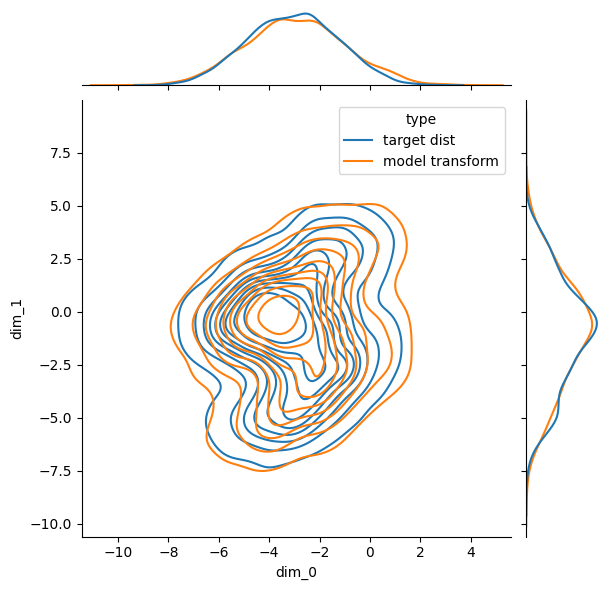

trail: 0 m step: 1 kl_test: 0.18825531005859375


  2%|▏         | 100/6000 [00:30<33:53,  2.90it/s]

trail: 0 m step: 2 Loss: 0.16570154449643468  L_n: 0.1552562713623047  kld: 0.0017652511596679688 KLD1: 0.15883754193782806 KLD2: 0.1247696503996849


  3%|▎         | 200/6000 [01:01<32:39,  2.96it/s]

trail: 0 m step: 2 Loss: 0.18108957053641594  L_n: 0.15521621704101562  kld: 0.004372596740722656 KLD1: 0.1452960968017578 KLD2: 0.11023516207933426


  5%|▌         | 300/6000 [01:32<32:13,  2.95it/s]

trail: 0 m step: 2 Loss: 0.1569843348666761  L_n: 0.14165782928466797  kld: 0.002590179443359375 KLD1: 0.154847651720047 KLD2: 0.11753886193037033


  7%|▋         | 400/6000 [02:02<31:44,  2.94it/s]

trail: 0 m step: 2 Loss: 0.1705652440088035  L_n: 0.14438152313232422  kld: 0.004425048828125 KLD1: 0.14468641579151154 KLD2: 0.11120355129241943


  8%|▊         | 500/6000 [02:33<31:00,  2.96it/s]

trail: 0 m step: 2 Loss: 0.18304909474750947  L_n: 0.1452350616455078  kld: 0.006390571594238281 KLD1: 0.1368158459663391 KLD2: 0.11569487303495407


 10%|█         | 600/6000 [03:04<30:32,  2.95it/s]

trail: 0 m step: 2 Loss: 0.16645037069828553  L_n: 0.1441659927368164  kld: 0.0037660598754882812 KLD1: 0.13949818909168243 KLD2: 0.11657682806253433


 12%|█▏        | 700/6000 [03:34<29:55,  2.95it/s]

trail: 0 m step: 2 Loss: 0.1706165505584175  L_n: 0.15627193450927734  kld: 0.0024242401123046875 KLD1: 0.15129512548446655 KLD2: 0.11388162523508072


 13%|█▎        | 800/6000 [04:05<29:28,  2.94it/s]

trail: 0 m step: 2 Loss: 0.15473345750887718  L_n: 0.13234186172485352  kld: 0.0037841796875 KLD1: 0.14257018268108368 KLD2: 0.11292997747659683


 15%|█▌        | 900/6000 [04:36<28:52,  2.94it/s]

trail: 0 m step: 2 Loss: 0.177871269587229  L_n: 0.15161418914794922  kld: 0.004437446594238281 KLD1: 0.13878053426742554 KLD2: 0.11622052639722824


 17%|█▋        | 1000/6000 [05:06<28:19,  2.94it/s]

trail: 0 m step: 2 Loss: 0.16640693619406435  L_n: 0.1417694091796875  kld: 0.0041637420654296875 KLD1: 0.13936805725097656 KLD2: 0.11129921674728394


 18%|█▊        | 1100/6000 [05:37<27:47,  2.94it/s]

trail: 0 m step: 2 Loss: 0.17772892382017957  L_n: 0.14777565002441406  kld: 0.005062103271484375 KLD1: 0.14535799622535706 KLD2: 0.10463017225265503


 20%|██        | 1200/6000 [06:08<27:12,  2.94it/s]

trail: 0 m step: 2 Loss: 0.17136867794059438  L_n: 0.15420818328857422  kld: 0.0029001235961914062 KLD1: 0.15084542334079742 KLD2: 0.12046504765748978


 22%|██▏       | 1300/6000 [06:38<26:38,  2.94it/s]

trail: 0 m step: 2 Loss: 0.16003552555332523  L_n: 0.13625574111938477  kld: 0.0040187835693359375 KLD1: 0.14226080477237701 KLD2: 0.11737316846847534


 23%|██▎       | 1400/6000 [07:09<26:04,  2.94it/s]

trail: 0 m step: 2 Loss: 0.16196520088692387  L_n: 0.13634014129638672  kld: 0.004330635070800781 KLD1: 0.14453661441802979 KLD2: 0.1157897561788559


 25%|██▌       | 1500/6000 [07:40<25:30,  2.94it/s]

trail: 0 m step: 2 Loss: 0.1630046889626768  L_n: 0.1423511505126953  kld: 0.003490447998046875 KLD1: 0.1424025446176529 KLD2: 0.10902885347604752


 27%|██▋       | 1600/6000 [08:10<24:48,  2.96it/s]

trail: 0 m step: 2 Loss: 0.17642183698846037  L_n: 0.14642906188964844  kld: 0.005068778991699219 KLD1: 0.14165033400058746 KLD2: 0.10703834146261215


 28%|██▊       | 1700/6000 [08:41<24:22,  2.94it/s]

trail: 0 m step: 2 Loss: 0.16245985313280092  L_n: 0.14525985717773438  kld: 0.00290679931640625 KLD1: 0.14254026114940643 KLD2: 0.11521665006875992


 30%|███       | 1800/6000 [09:12<23:42,  2.95it/s]

trail: 0 m step: 2 Loss: 0.17081655129878479  L_n: 0.1396951675415039  kld: 0.005259513854980469 KLD1: 0.1377038061618805 KLD2: 0.11113317310810089


 32%|███▏      | 1900/6000 [09:43<23:15,  2.94it/s]

trail: 0 m step: 2 Loss: 0.16331782707801232  L_n: 0.15202045440673828  kld: 0.0019092559814453125 KLD1: 0.15593121945858002 KLD2: 0.11432909965515137


 33%|███▎      | 2000/6000 [10:13<22:36,  2.95it/s]

trail: 0 m step: 2 Loss: 0.1776400797465849  L_n: 0.14522361755371094  kld: 0.005478382110595703 KLD1: 0.13346461951732635 KLD2: 0.10851354897022247


 35%|███▌      | 2100/6000 [10:44<22:04,  2.94it/s]

trail: 0 m step: 2 Loss: 0.15715899269961747  L_n: 0.14402198791503906  kld: 0.00222015380859375 KLD1: 0.15173640847206116 KLD2: 0.1179846003651619


 37%|███▋      | 2200/6000 [11:15<21:29,  2.95it/s]

trail: 0 m step: 2 Loss: 0.17385276252701437  L_n: 0.14809226989746094  kld: 0.004353523254394531 KLD1: 0.1413492113351822 KLD2: 0.12139804661273956


 38%|███▊      | 2300/6000 [11:45<20:59,  2.94it/s]

trail: 0 m step: 2 Loss: 0.17011591668665055  L_n: 0.1476001739501953  kld: 0.0038051605224609375 KLD1: 0.14365246891975403 KLD2: 0.11456205695867538


 40%|████      | 2400/6000 [12:16<20:23,  2.94it/s]

trail: 0 m step: 2 Loss: 0.15549983639688886  L_n: 0.14142608642578125  kld: 0.0023784637451171875 KLD1: 0.15249118208885193 KLD2: 0.1172771081328392


 42%|████▏     | 2500/6000 [12:47<19:45,  2.95it/s]

trail: 0 m step: 2 Loss: 0.16581611520439915  L_n: 0.14141559600830078  kld: 0.004123687744140625 KLD1: 0.14584049582481384 KLD2: 0.1122034415602684


 43%|████▎     | 2600/6000 [13:17<19:15,  2.94it/s]

trail: 0 m step: 2 Loss: 0.17197555903146958  L_n: 0.14686965942382812  kld: 0.004242897033691406 KLD1: 0.13734276592731476 KLD2: 0.1136021688580513


 45%|████▌     | 2700/6000 [13:48<18:38,  2.95it/s]

trail: 0 m step: 2 Loss: 0.16774618837254993  L_n: 0.1453094482421875  kld: 0.00379180908203125 KLD1: 0.14047245681285858 KLD2: 0.11276186257600784


 47%|████▋     | 2800/6000 [14:19<18:11,  2.93it/s]

trail: 0 m step: 2 Loss: 0.15227667960894883  L_n: 0.13219308853149414  kld: 0.0033941268920898438 KLD1: 0.14745794236660004 KLD2: 0.11052325367927551


 48%|████▊     | 2900/6000 [14:49<17:32,  2.94it/s]

trail: 0 m step: 2 Loss: 0.16534052515876363  L_n: 0.1469554901123047  kld: 0.0031070709228515625 KLD1: 0.1519768089056015 KLD2: 0.11100772768259048


 50%|█████     | 3000/6000 [15:20<16:56,  2.95it/s]

trail: 0 m step: 2 Loss: 0.16547873457507972  L_n: 0.1393909454345703  kld: 0.004408836364746094 KLD1: 0.14094923436641693 KLD2: 0.11812309175729752


 52%|█████▏    | 3100/6000 [15:51<16:23,  2.95it/s]

trail: 0 m step: 2 Loss: 0.17076372677052515  L_n: 0.1374359130859375  kld: 0.0056324005126953125 KLD1: 0.13876713812351227 KLD2: 0.10923278331756592


 53%|█████▎    | 3200/6000 [16:22<15:46,  2.96it/s]

trail: 0 m step: 2 Loss: 0.17267948353784324  L_n: 0.14240455627441406  kld: 0.005116462707519531 KLD1: 0.13834333419799805 KLD2: 0.11325519531965256


 55%|█████▌    | 3300/6000 [16:52<15:17,  2.94it/s]

trail: 0 m step: 2 Loss: 0.18506444558589416  L_n: 0.15775775909423828  kld: 0.004614830017089844 KLD1: 0.14382384717464447 KLD2: 0.11822087317705154


 57%|█████▋    | 3400/6000 [17:23<14:44,  2.94it/s]

trail: 0 m step: 2 Loss: 0.17057391172330055  L_n: 0.14909648895263672  kld: 0.0036296844482421875 KLD1: 0.14092262089252472 KLD2: 0.11663048714399338


 58%|█████▊    | 3500/6000 [17:54<14:10,  2.94it/s]

trail: 0 m step: 2 Loss: 0.17178659608378213  L_n: 0.1530742645263672  kld: 0.003162384033203125 KLD1: 0.1488513946533203 KLD2: 0.10806054621934891


 60%|██████    | 3600/6000 [18:24<13:37,  2.94it/s]

trail: 0 m step: 2 Loss: 0.16840053874360034  L_n: 0.13200855255126953  kld: 0.006150245666503906 KLD1: 0.12993761897087097 KLD2: 0.11165346205234528


 62%|██████▏   | 3700/6000 [18:55<13:00,  2.95it/s]

trail: 0 m step: 2 Loss: 0.17417646441939313  L_n: 0.1454477310180664  kld: 0.004855155944824219 KLD1: 0.1367911547422409 KLD2: 0.1086759865283966


 63%|██████▎   | 3800/6000 [19:26<12:28,  2.94it/s]

trail: 0 m step: 2 Loss: 0.17078464553200987  L_n: 0.14773845672607422  kld: 0.003894805908203125 KLD1: 0.1429605782032013 KLD2: 0.10709289461374283


 65%|██████▌   | 3900/6000 [19:56<11:50,  2.95it/s]

trail: 0 m step: 2 Loss: 0.16959256956563193  L_n: 0.14729690551757812  kld: 0.0037679672241210938 KLD1: 0.14095643162727356 KLD2: 0.11869724094867706


 67%|██████▋   | 4000/6000 [20:27<11:20,  2.94it/s]

trail: 0 m step: 2 Loss: 0.17207646228857998  L_n: 0.15206623077392578  kld: 0.0033817291259765625 KLD1: 0.144389808177948 KLD2: 0.11151809990406036


 68%|██████▊   | 4100/6000 [20:58<10:47,  2.93it/s]

trail: 0 m step: 2 Loss: 0.15556442102736975  L_n: 0.14467334747314453  kld: 0.0018405914306640625 KLD1: 0.15201571583747864 KLD2: 0.1090509369969368


 70%|███████   | 4200/6000 [21:29<10:11,  2.94it/s]

trail: 0 m step: 2 Loss: 0.15533235087197209  L_n: 0.1397857666015625  kld: 0.0026273727416992188 KLD1: 0.1475670486688614 KLD2: 0.10983224958181381


 72%|███████▏  | 4300/6000 [21:59<09:37,  2.94it/s]

trail: 0 m step: 2 Loss: 0.17318669719808905  L_n: 0.14746570587158203  kld: 0.0043468475341796875 KLD1: 0.14353390038013458 KLD2: 0.10996337980031967


 73%|███████▎  | 4400/6000 [22:30<09:02,  2.95it/s]

trail: 0 m step: 2 Loss: 0.1603820958786462  L_n: 0.13577842712402344  kld: 0.00415802001953125 KLD1: 0.1423403024673462 KLD2: 0.10584384202957153


 75%|███████▌  | 4500/6000 [23:01<08:30,  2.94it/s]

trail: 0 m step: 2 Loss: 0.1779997334677792  L_n: 0.14749908447265625  kld: 0.005154609680175781 KLD1: 0.13208772242069244 KLD2: 0.10717074573040009


 77%|███████▋  | 4600/6000 [23:31<07:57,  2.93it/s]

trail: 0 m step: 2 Loss: 0.17264071018738153  L_n: 0.13843822479248047  kld: 0.005780220031738281 KLD1: 0.13204284012317657 KLD2: 0.11131034791469574


 78%|███████▊  | 4700/6000 [24:02<07:20,  2.95it/s]

trail: 0 m step: 2 Loss: 0.16302842360276443  L_n: 0.1398468017578125  kld: 0.003917694091796875 KLD1: 0.14337158203125 KLD2: 0.11171874403953552


 80%|████████  | 4800/6000 [24:33<06:46,  2.95it/s]

trail: 0 m step: 2 Loss: 0.14912310718784672  L_n: 0.1243896484375  kld: 0.004179954528808594 KLD1: 0.14081598818302155 KLD2: 0.10774992406368256


 82%|████████▏ | 4900/6000 [25:03<06:13,  2.95it/s]

trail: 0 m step: 2 Loss: 0.16761264575303658  L_n: 0.14742183685302734  kld: 0.0034122467041015625 KLD1: 0.1486857831478119 KLD2: 0.10956399887800217


 83%|████████▎ | 5000/6000 [25:34<05:40,  2.94it/s]

trail: 0 m step: 2 Loss: 0.1607367442204402  L_n: 0.13660144805908203  kld: 0.004078865051269531 KLD1: 0.1385047286748886 KLD2: 0.11358832567930222


 85%|████████▌ | 5100/6000 [26:05<05:04,  2.95it/s]

trail: 0 m step: 2 Loss: 0.1572996116954194  L_n: 0.13329410552978516  kld: 0.0040569305419921875 KLD1: 0.14259964227676392 KLD2: 0.11170939356088638


 87%|████████▋ | 5200/6000 [26:36<04:32,  2.94it/s]

trail: 0 m step: 2 Loss: 0.15704665099375345  L_n: 0.1425609588623047  kld: 0.0024480819702148438 KLD1: 0.15165559947490692 KLD2: 0.11594147980213165


 88%|████████▊ | 5300/6000 [27:06<03:58,  2.94it/s]

trail: 0 m step: 2 Loss: 0.17254511139096593  L_n: 0.14111900329589844  kld: 0.005311012268066406 KLD1: 0.13032272458076477 KLD2: 0.10720434039831161


 90%|█████████ | 5400/6000 [27:37<03:24,  2.94it/s]

trail: 0 m step: 2 Loss: 0.18220955662473418  L_n: 0.14995956420898438  kld: 0.005450248718261719 KLD1: 0.1339685320854187 KLD2: 0.11087232083082199


 92%|█████████▏| 5500/6000 [28:08<02:49,  2.94it/s]

trail: 0 m step: 2 Loss: 0.16757715665377104  L_n: 0.14505577087402344  kld: 0.0038061141967773438 KLD1: 0.14816762506961823 KLD2: 0.1110396608710289


 93%|█████████▎| 5600/6000 [28:38<02:15,  2.95it/s]

trail: 0 m step: 2 Loss: 0.17684684279402332  L_n: 0.14798831939697266  kld: 0.0048770904541015625 KLD1: 0.14201010763645172 KLD2: 0.1064872071146965


 95%|█████████▌| 5700/6000 [29:09<01:41,  2.94it/s]

trail: 0 m step: 2 Loss: 0.1571858705148189  L_n: 0.14099597930908203  kld: 0.0027360916137695312 KLD1: 0.14638450741767883 KLD2: 0.11034543067216873


 97%|█████████▋| 5800/6000 [29:40<01:07,  2.95it/s]

trail: 0 m step: 2 Loss: 0.16029803710576346  L_n: 0.14113426208496094  kld: 0.003238677978515625 KLD1: 0.14837925136089325 KLD2: 0.11155624687671661


 98%|█████████▊| 5900/6000 [30:10<00:33,  2.95it/s]

trail: 0 m step: 2 Loss: 0.17044495125494058  L_n: 0.14391136169433594  kld: 0.0044841766357421875 KLD1: 0.13781720399856567 KLD2: 0.10621042549610138


100%|██████████| 6000/6000 [30:41<00:00,  3.26it/s]

trail: 0 m step: 2 Loss: 0.1547477654451449  L_n: 0.13136863708496094  kld: 0.003951072692871094 KLD1: 0.14051693677902222 KLD2: 0.1083870604634285



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


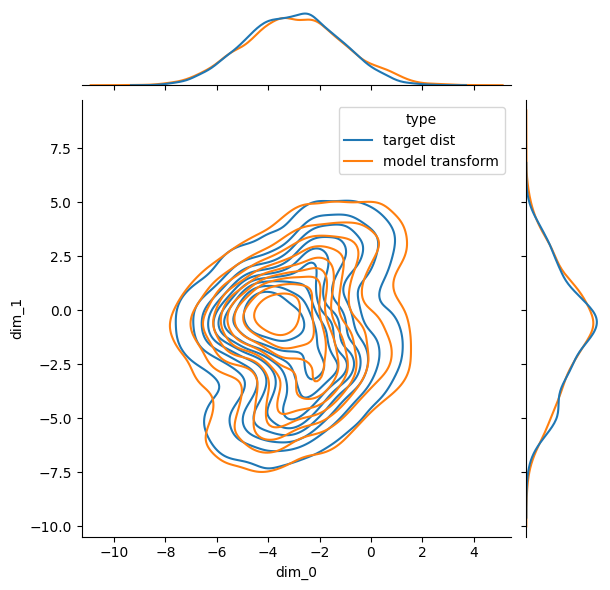

trail: 0 m step: 2 kl_test: 0.13429737091064453


  2%|▏         | 100/6000 [00:30<33:44,  2.91it/s]

trail: 0 m step: 3 Loss: 0.11589020102687136  L_n: 0.10711526870727539  kld: 0.0019278526306152344 KLD1: 0.11013419181108475 KLD2: 0.08984299004077911


  3%|▎         | 200/6000 [01:01<32:29,  2.97it/s]

trail: 0 m step: 3 Loss: 0.12931834604179093  L_n: 0.10739946365356445  kld: 0.004815578460693359 KLD1: 0.10033422708511353 KLD2: 0.07750711590051651


  5%|▌         | 300/6000 [01:31<32:12,  2.95it/s]

trail: 0 m step: 3 Loss: 0.10951046798247666  L_n: 0.09736490249633789  kld: 0.0026683807373046875 KLD1: 0.10946758836507797 KLD2: 0.08389167487621307


  7%|▋         | 400/6000 [02:02<31:42,  2.94it/s]

trail: 0 m step: 3 Loss: 0.12095180315270335  L_n: 0.10087776184082031  kld: 0.004410266876220703 KLD1: 0.09940226376056671 KLD2: 0.07781321555376053


  8%|▊         | 500/6000 [02:33<31:01,  2.95it/s]

trail: 0 m step: 3 Loss: 0.13068425508862905  L_n: 0.10286188125610352  kld: 0.006112575531005859 KLD1: 0.0944032296538353 KLD2: 0.08341150730848312


 10%|█         | 600/6000 [03:03<30:27,  2.96it/s]

trail: 0 m step: 3 Loss: 0.11457757207551869  L_n: 0.0966348648071289  kld: 0.003942012786865234 KLD1: 0.09769143909215927 KLD2: 0.08178849518299103


 12%|█▏        | 700/6000 [03:34<29:47,  2.96it/s]

trail: 0 m step: 3 Loss: 0.12061128108459111  L_n: 0.10808372497558594  kld: 0.0027523040771484375 KLD1: 0.10382217913866043 KLD2: 0.07968878000974655


 13%|█▎        | 800/6000 [04:05<29:20,  2.95it/s]

trail: 0 m step: 3 Loss: 0.10631451022912547  L_n: 0.08836746215820312  kld: 0.003942966461181641 KLD1: 0.09846635907888412 KLD2: 0.07989902049303055


 15%|█▌        | 900/6000 [04:35<28:48,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12757538815872962  L_n: 0.10663318634033203  kld: 0.004601001739501953 KLD1: 0.09641803801059723 KLD2: 0.08165951818227768


 17%|█▋        | 1000/6000 [05:06<28:09,  2.96it/s]

trail: 0 m step: 3 Loss: 0.11744313680642726  L_n: 0.09737777709960938  kld: 0.004408359527587891 KLD1: 0.09525391459465027 KLD2: 0.07814911007881165


 18%|█▊        | 1100/6000 [05:36<27:39,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12650329696627494  L_n: 0.10221433639526367  kld: 0.005336284637451172 KLD1: 0.09863171726465225 KLD2: 0.07236047089099884


 20%|██        | 1200/6000 [06:07<27:05,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12205150119814484  L_n: 0.1076812744140625  kld: 0.0031571388244628906 KLD1: 0.10653308033943176 KLD2: 0.08594385534524918


 22%|██▏       | 1300/6000 [06:38<26:32,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11056066981000037  L_n: 0.0907297134399414  kld: 0.004356861114501953 KLD1: 0.09834333509206772 KLD2: 0.08397116512060165


 23%|██▎       | 1400/6000 [07:08<25:57,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11644345237061714  L_n: 0.09492826461791992  kld: 0.004726886749267578 KLD1: 0.09799017012119293 KLD2: 0.08152206987142563


 25%|██▌       | 1500/6000 [07:39<25:25,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11341154938890113  L_n: 0.09609174728393555  kld: 0.0038051605224609375 KLD1: 0.09714647382497787 KLD2: 0.07580024003982544


 27%|██▋       | 1600/6000 [08:09<24:49,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12519024413555493  L_n: 0.1003413200378418  kld: 0.005459308624267578 KLD1: 0.09607142210006714 KLD2: 0.07488604635000229


 28%|██▊       | 1700/6000 [08:40<24:14,  2.96it/s]

trail: 0 m step: 3 Loss: 0.11270514628428137  L_n: 0.09823942184448242  kld: 0.003178119659423828 KLD1: 0.09612394869327545 KLD2: 0.08082182705402374


 30%|███       | 1800/6000 [09:11<23:40,  2.96it/s]

trail: 0 m step: 3 Loss: 0.12102208378426747  L_n: 0.09652042388916016  kld: 0.005383014678955078 KLD1: 0.09468227624893188 KLD2: 0.07812505960464478


 32%|███▏      | 1900/6000 [09:41<23:08,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11695668715805588  L_n: 0.10689687728881836  kld: 0.0022101402282714844 KLD1: 0.10513365268707275 KLD2: 0.08128999918699265


 33%|███▎      | 2000/6000 [10:12<22:33,  2.96it/s]

trail: 0 m step: 3 Loss: 0.1268121452835076  L_n: 0.10056114196777344  kld: 0.005767345428466797 KLD1: 0.09106120467185974 KLD2: 0.07643765956163406


 35%|███▌      | 2100/6000 [10:42<22:03,  2.95it/s]

trail: 0 m step: 3 Loss: 0.10904999608390159  L_n: 0.09844541549682617  kld: 0.0023298263549804688 KLD1: 0.10574423521757126 KLD2: 0.08361078798770905


 37%|███▋      | 2200/6000 [11:13<21:30,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12518477233692252  L_n: 0.1029815673828125  kld: 0.004878044128417969 KLD1: 0.0999242439866066 KLD2: 0.08592381328344345


 38%|███▊      | 2300/6000 [11:44<20:55,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12057087602645741  L_n: 0.10168838500976562  kld: 0.0041484832763671875 KLD1: 0.09631459414958954 KLD2: 0.0808706283569336


 40%|████      | 2400/6000 [12:14<20:20,  2.95it/s]

trail: 0 m step: 3 Loss: 0.1061416959350197  L_n: 0.09520721435546875  kld: 0.0024023056030273438 KLD1: 0.10472803562879562 KLD2: 0.08318723738193512


 42%|████▏     | 2500/6000 [12:45<19:44,  2.96it/s]

trail: 0 m step: 3 Loss: 0.11784730914727524  L_n: 0.09744119644165039  kld: 0.004483222961425781 KLD1: 0.09773053973913193 KLD2: 0.07858439534902573


 43%|████▎     | 2600/6000 [13:16<19:11,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12121230751805051  L_n: 0.10137701034545898  kld: 0.004357814788818359 KLD1: 0.09161867201328278 KLD2: 0.08043289184570312


 45%|████▌     | 2700/6000 [13:46<18:37,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11959676976957048  L_n: 0.10117006301879883  kld: 0.004048347473144531 KLD1: 0.09807240962982178 KLD2: 0.07948428392410278


 47%|████▋     | 2800/6000 [14:17<18:02,  2.96it/s]

trail: 0 m step: 3 Loss: 0.10392659308425285  L_n: 0.08725357055664062  kld: 0.0036630630493164062 KLD1: 0.10178866982460022 KLD2: 0.07795754075050354


 48%|████▊     | 2900/6000 [14:48<17:30,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11573135283083388  L_n: 0.10131120681762695  kld: 0.0031681060791015625 KLD1: 0.1065613254904747 KLD2: 0.07759346812963486


 50%|█████     | 3000/6000 [15:18<16:58,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11587794889468304  L_n: 0.09501171112060547  kld: 0.004584312438964844 KLD1: 0.09676998108625412 KLD2: 0.08419971913099289


 52%|█████▏    | 3100/6000 [15:49<16:24,  2.94it/s]

trail: 0 m step: 3 Loss: 0.12035482712208709  L_n: 0.09368276596069336  kld: 0.005859851837158203 KLD1: 0.09272860735654831 KLD2: 0.07653145492076874


 53%|█████▎    | 3200/6000 [16:19<15:48,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11899321894239825  L_n: 0.09532499313354492  kld: 0.005199909210205078 KLD1: 0.0956474244594574 KLD2: 0.07938338071107864


 55%|█████▌    | 3300/6000 [16:50<15:15,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12941867349144542  L_n: 0.10828113555908203  kld: 0.004643917083740234 KLD1: 0.10117357224225998 KLD2: 0.0834088996052742


 57%|█████▋    | 3400/6000 [17:21<14:43,  2.94it/s]

trail: 0 m step: 3 Loss: 0.12040731957895298  L_n: 0.10381460189819336  kld: 0.0036454200744628906 KLD1: 0.09731195122003555 KLD2: 0.0826941728591919


 58%|█████▊    | 3500/6000 [17:51<14:07,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11943368277985994  L_n: 0.10514593124389648  kld: 0.003139019012451172 KLD1: 0.10203489661216736 KLD2: 0.07522987574338913


 60%|██████    | 3600/6000 [18:22<13:33,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11685628808515963  L_n: 0.08890151977539062  kld: 0.00614166259765625 KLD1: 0.08639936149120331 KLD2: 0.07935125380754471


 62%|██████▏   | 3700/6000 [18:52<12:58,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12226243555193117  L_n: 0.09892845153808594  kld: 0.005126476287841797 KLD1: 0.09394539892673492 KLD2: 0.07593684643507004


 63%|██████▎   | 3800/6000 [19:23<12:24,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11914514160503514  L_n: 0.1008920669555664  kld: 0.004010200500488281 KLD1: 0.09700459986925125 KLD2: 0.074310302734375


 65%|██████▌   | 3900/6000 [19:54<11:52,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12001840993388979  L_n: 0.10166549682617188  kld: 0.004032135009765625 KLD1: 0.09553178399801254 KLD2: 0.08470652997493744


 67%|██████▋   | 4000/6000 [20:24<11:16,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12380644533923935  L_n: 0.10723543167114258  kld: 0.0036406517028808594 KLD1: 0.10047238320112228 KLD2: 0.07828409969806671


 68%|██████▊   | 4100/6000 [20:55<10:42,  2.96it/s]

trail: 0 m step: 3 Loss: 0.10835152970263238  L_n: 0.09904050827026367  kld: 0.0020456314086914062 KLD1: 0.10325949639081955 KLD2: 0.07628101110458374


 70%|███████   | 4200/6000 [21:26<10:09,  2.96it/s]

trail: 0 m step: 3 Loss: 0.10983515653927108  L_n: 0.09615945816040039  kld: 0.0030045509338378906 KLD1: 0.10013452172279358 KLD2: 0.07640127092599869


 72%|███████▏  | 4300/6000 [21:56<09:34,  2.96it/s]

trail: 0 m step: 3 Loss: 0.12141941350104324  L_n: 0.09997367858886719  kld: 0.004711627960205078 KLD1: 0.09735865890979767 KLD2: 0.07671765238046646


 73%|███████▎  | 4400/6000 [22:27<09:01,  2.96it/s]

trail: 0 m step: 3 Loss: 0.10930521378584433  L_n: 0.08997344970703125  kld: 0.004247188568115234 KLD1: 0.09565369784832001 KLD2: 0.07410439103841782


 75%|███████▌  | 4500/6000 [22:58<08:27,  2.96it/s]

trail: 0 m step: 3 Loss: 0.12685365529292597  L_n: 0.10242795944213867  kld: 0.005366325378417969 KLD1: 0.08946454524993896 KLD2: 0.07486468553543091


 77%|███████▋  | 4600/6000 [23:28<07:54,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12203890701071696  L_n: 0.0946202278137207  kld: 0.006023883819580078 KLD1: 0.08829127252101898 KLD2: 0.0779937282204628


 78%|███████▊  | 4700/6000 [23:59<07:19,  2.96it/s]

trail: 0 m step: 3 Loss: 0.11349757280901013  L_n: 0.09584569931030273  kld: 0.0038781166076660156 KLD1: 0.09768831729888916 KLD2: 0.07871685922145844


 80%|████████  | 4800/6000 [24:29<06:47,  2.95it/s]

trail: 0 m step: 3 Loss: 0.10360149475569935  L_n: 0.08259201049804688  kld: 0.00461578369140625 KLD1: 0.09650222957134247 KLD2: 0.07493850588798523


 82%|████████▏ | 4900/6000 [25:00<06:12,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11832405232710355  L_n: 0.10183334350585938  kld: 0.0036230087280273438 KLD1: 0.10227426141500473 KLD2: 0.07637038081884384


 83%|████████▎ | 5000/6000 [25:31<05:39,  2.95it/s]

trail: 0 m step: 3 Loss: 0.10996985793602049  L_n: 0.0905599594116211  kld: 0.004264354705810547 KLD1: 0.09386038780212402 KLD2: 0.07954030483961105


 85%|████████▌ | 5100/6000 [26:01<05:04,  2.95it/s]

trail: 0 m step: 3 Loss: 0.10808112526894918  L_n: 0.08887958526611328  kld: 0.004218578338623047 KLD1: 0.09792538732290268 KLD2: 0.07820997387170792


 87%|████████▋ | 5200/6000 [26:32<04:31,  2.95it/s]

trail: 0 m step: 3 Loss: 0.10775959486303734  L_n: 0.09613275527954102  kld: 0.0025544166564941406 KLD1: 0.10427059233188629 KLD2: 0.08148879557847977


 88%|████████▊ | 5300/6000 [27:02<03:57,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12344645173320674  L_n: 0.09748411178588867  kld: 0.005703926086425781 KLD1: 0.08661357313394547 KLD2: 0.07456178963184357


 90%|█████████ | 5400/6000 [27:33<03:23,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12795566069195366  L_n: 0.10127925872802734  kld: 0.005860805511474609 KLD1: 0.089728944003582 KLD2: 0.07753679901361465


 92%|█████████▏| 5500/6000 [28:04<02:48,  2.96it/s]

trail: 0 m step: 3 Loss: 0.11881195462504245  L_n: 0.1010732650756836  kld: 0.0038971900939941406 KLD1: 0.1015009880065918 KLD2: 0.07818002253770828


 93%|█████████▎| 5600/6000 [28:34<02:15,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12576558473818836  L_n: 0.10297203063964844  kld: 0.005007743835449219 KLD1: 0.09766004234552383 KLD2: 0.07367061823606491


 95%|█████████▌| 5700/6000 [29:05<01:41,  2.95it/s]

trail: 0 m step: 3 Loss: 0.11186456680297852  L_n: 0.09755945205688477  kld: 0.003142833709716797 KLD1: 0.10028204321861267 KLD2: 0.07700076699256897


 97%|█████████▋| 5800/6000 [29:36<01:08,  2.94it/s]

trail: 0 m step: 3 Loss: 0.11171260029823606  L_n: 0.09596633911132812  kld: 0.003459453582763672 KLD1: 0.1006803810596466 KLD2: 0.07860595732927322


 98%|█████████▊| 5900/6000 [30:06<00:33,  2.95it/s]

trail: 0 m step: 3 Loss: 0.12075497792642878  L_n: 0.09901189804077148  kld: 0.004776954650878906 KLD1: 0.09304312616586685 KLD2: 0.07359372079372406


100%|██████████| 6000/6000 [30:37<00:00,  3.27it/s]

trail: 0 m step: 3 Loss: 0.108432986381437  L_n: 0.08837413787841797  kld: 0.004406929016113281 KLD1: 0.09485629945993423 KLD2: 0.07535742223262787



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


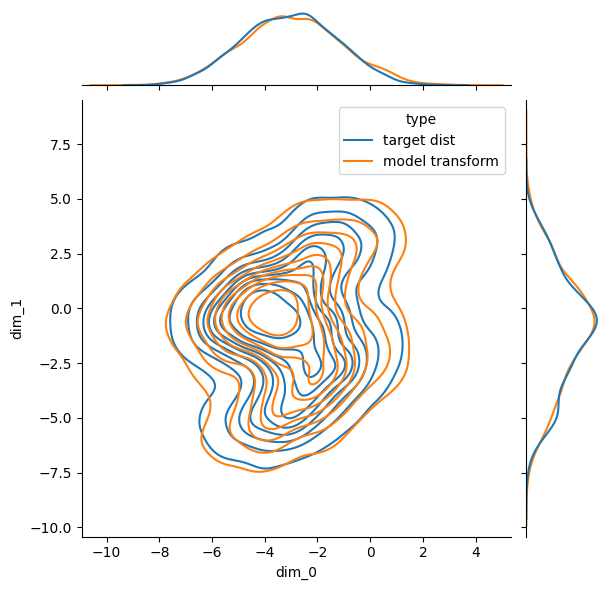

trail: 0 m step: 3 kl_test: 0.08961868286132812


  2%|▏         | 100/6000 [00:30<33:44,  2.91it/s]

trail: 0 m step: 4 Loss: 0.0753796650813176  L_n: 0.06804370880126953  kld: 0.0020952224731445312 KLD1: 0.07290337234735489 KLD2: 0.06107449159026146


  3%|▎         | 200/6000 [01:01<32:33,  2.97it/s]

trail: 0 m step: 4 Loss: 0.08678078961127787  L_n: 0.07109546661376953  kld: 0.004479885101318359 KLD1: 0.06774955987930298 KLD2: 0.051410045474767685


  5%|▌         | 300/6000 [01:31<32:07,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07180814959080395  L_n: 0.06317996978759766  kld: 0.00246429443359375 KLD1: 0.07437514513731003 KLD2: 0.056248247623443604


  7%|▋         | 400/6000 [02:02<31:32,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07948244863905278  L_n: 0.06605768203735352  kld: 0.003834247589111328 KLD1: 0.06393622606992722 KLD2: 0.05048203468322754


  8%|▊         | 500/6000 [02:32<30:57,  2.96it/s]

trail: 0 m step: 4 Loss: 0.0860176702485833  L_n: 0.06755924224853516  kld: 0.00527191162109375 KLD1: 0.0607009157538414 KLD2: 0.056864116340875626


 10%|█         | 600/6000 [03:03<30:31,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07506208881260504  L_n: 0.06120157241821289  kld: 0.003958702087402344 KLD1: 0.06248386204242706 KLD2: 0.053947966545820236


 12%|█▏        | 700/6000 [03:34<29:55,  2.95it/s]

trail: 0 m step: 4 Loss: 0.08135517431296352  L_n: 0.07133960723876953  kld: 0.002860546112060547 KLD1: 0.06892500817775726 KLD2: 0.05287301540374756


 13%|█▎        | 800/6000 [04:04<29:21,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07065610402121496  L_n: 0.05812788009643555  kld: 0.00357818603515625 KLD1: 0.06396427005529404 KLD2: 0.05333838239312172


 15%|█▌        | 900/6000 [04:35<28:51,  2.95it/s]

trail: 0 m step: 4 Loss: 0.08531549964347292  L_n: 0.07019948959350586  kld: 0.004317283630371094 KLD1: 0.06413532793521881 KLD2: 0.05396244302392006


 17%|█▋        | 1000/6000 [05:05<28:13,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07899945876055842  L_n: 0.06479501724243164  kld: 0.0040569305419921875 KLD1: 0.06144564226269722 KLD2: 0.05182742327451706


 18%|█▊        | 1100/6000 [05:36<27:35,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08451901996116094  L_n: 0.06657981872558594  kld: 0.005123615264892578 KLD1: 0.06635364890098572 KLD2: 0.046933725476264954


 20%|██        | 1200/6000 [06:07<27:06,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07980539504814155  L_n: 0.06995010375976562  kld: 0.002814769744873047 KLD1: 0.07101228088140488 KLD2: 0.05744119733572006


 22%|██▏       | 1300/6000 [06:37<26:36,  2.94it/s]

trail: 0 m step: 4 Loss: 0.07240047139624939  L_n: 0.057646751403808594  kld: 0.004213809967041016 KLD1: 0.06538292020559311 KLD2: 0.056814685463905334


 23%|██▎       | 1400/6000 [07:08<25:54,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07653385539135175  L_n: 0.06068992614746094  kld: 0.004525184631347656 KLD1: 0.06228720396757126 KLD2: 0.05412330850958824


 25%|██▌       | 1500/6000 [07:38<25:19,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07233967176192757  L_n: 0.05824708938598633  kld: 0.004024982452392578 KLD1: 0.06432512402534485 KLD2: 0.049120329320430756


 27%|██▋       | 1600/6000 [08:09<24:50,  2.95it/s]

trail: 0 m step: 4 Loss: 0.08311632348101979  L_n: 0.0647430419921875  kld: 0.005247592926025391 KLD1: 0.06338508427143097 KLD2: 0.049752458930015564


 28%|██▊       | 1700/6000 [08:39<24:12,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07434939351436959  L_n: 0.06327199935913086  kld: 0.0031638145446777344 KLD1: 0.05860728770494461 KLD2: 0.053222689777612686


 30%|███       | 1800/6000 [09:10<23:40,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08185260248536476  L_n: 0.06310701370239258  kld: 0.0053539276123046875 KLD1: 0.06081712618470192 KLD2: 0.05083358660340309


 32%|███▏      | 1900/6000 [09:41<23:05,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08191283642963962  L_n: 0.07385396957397461  kld: 0.0023016929626464844 KLD1: 0.07084237784147263 KLD2: 0.05439860746264458


 33%|███▎      | 2000/6000 [10:11<22:31,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08554793674694315  L_n: 0.06657028198242188  kld: 0.005420207977294922 KLD1: 0.0574953593313694 KLD2: 0.051032111048698425


 35%|███▌      | 2100/6000 [10:42<22:00,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07264700151617581  L_n: 0.0650639533996582  kld: 0.0021657943725585938 KLD1: 0.06842304021120071 KLD2: 0.05578143894672394


 37%|███▋      | 2200/6000 [11:12<21:27,  2.95it/s]

trail: 0 m step: 4 Loss: 0.08625124031820991  L_n: 0.06931877136230469  kld: 0.004836082458496094 KLD1: 0.06568591296672821 KLD2: 0.05723164603114128


 38%|███▊      | 2300/6000 [11:43<20:49,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08160903374440304  L_n: 0.06782865524291992  kld: 0.003935813903808594 KLD1: 0.06279198825359344 KLD2: 0.054044995456933975


 40%|████      | 2400/6000 [12:14<20:16,  2.96it/s]

trail: 0 m step: 4 Loss: 0.06659071836387746  L_n: 0.05893754959106445  kld: 0.002185821533203125 KLD1: 0.06929557770490646 KLD2: 0.05573900789022446


 42%|████▏     | 2500/6000 [12:44<19:43,  2.96it/s]

trail: 0 m step: 4 Loss: 0.0783859654086623  L_n: 0.06299114227294922  kld: 0.004396915435791016 KLD1: 0.06388895213603973 KLD2: 0.051409922540187836


 43%|████▎     | 2600/6000 [13:15<19:10,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07928015725718907  L_n: 0.06485700607299805  kld: 0.004119396209716797 KLD1: 0.060391686856746674 KLD2: 0.05384642258286476


 45%|████▌     | 2700/6000 [13:45<18:38,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07911053759340253  L_n: 0.06562566757202148  kld: 0.0038514137268066406 KLD1: 0.06339854747056961 KLD2: 0.052955511957407


 47%|████▋     | 2800/6000 [14:16<18:06,  2.95it/s]

trail: 0 m step: 4 Loss: 0.06771514198784317  L_n: 0.05537557601928711  kld: 0.003524303436279297 KLD1: 0.06613393127918243 KLD2: 0.051860708743333817


 48%|████▊     | 2900/6000 [14:47<17:29,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07520405404153088  L_n: 0.06431865692138672  kld: 0.003108978271484375 KLD1: 0.06920827180147171 KLD2: 0.050304632633924484


 50%|█████     | 3000/6000 [15:17<16:55,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07574121187658253  L_n: 0.06028127670288086  kld: 0.0044155120849609375 KLD1: 0.06359846889972687 KLD2: 0.05646881088614464


 52%|█████▏    | 3100/6000 [15:48<16:20,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08058548985373709  L_n: 0.06096172332763672  kld: 0.005604743957519531 KLD1: 0.05710409954190254 KLD2: 0.0505221001803875


 53%|█████▎    | 3200/6000 [16:18<15:46,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07525771789735097  L_n: 0.05713319778442383  kld: 0.005176544189453125 KLD1: 0.06438267230987549 KLD2: 0.05211275443434715


 55%|█████▌    | 3300/6000 [16:49<15:11,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08492845061663373  L_n: 0.07007455825805664  kld: 0.004242420196533203 KLD1: 0.06481152027845383 KLD2: 0.055226512253284454


 57%|█████▋    | 3400/6000 [17:20<14:39,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08025767052650686  L_n: 0.06910848617553711  kld: 0.0031843185424804688 KLD1: 0.06330350786447525 KLD2: 0.055348947644233704


 58%|█████▊    | 3500/6000 [17:50<14:04,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08016655592936593  L_n: 0.07042980194091797  kld: 0.002780914306640625 KLD1: 0.0660310685634613 KLD2: 0.04926137998700142


 60%|██████    | 3600/6000 [18:21<13:31,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07750782043859322  L_n: 0.0570225715637207  kld: 0.005850791931152344 KLD1: 0.05332297831773758 KLD2: 0.05297159403562546


 62%|██████▏   | 3700/6000 [18:51<12:56,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08134142101439168  L_n: 0.06328201293945312  kld: 0.005157947540283203 KLD1: 0.05966832861304283 KLD2: 0.049630336463451385


 63%|██████▎   | 3800/6000 [19:22<12:24,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07995865890189323  L_n: 0.06629180908203125  kld: 0.0039033889770507812 KLD1: 0.06397029757499695 KLD2: 0.048173632472753525


 65%|██████▌   | 3900/6000 [19:53<11:50,  2.95it/s]

trail: 0 m step: 4 Loss: 0.08007349256231881  L_n: 0.06663703918457031  kld: 0.00383758544921875 KLD1: 0.06024061143398285 KLD2: 0.05704507976770401


 67%|██████▋   | 4000/6000 [20:23<11:16,  2.96it/s]

trail: 0 m step: 4 Loss: 0.0825544729406754  L_n: 0.0704336166381836  kld: 0.0034618377685546875 KLD1: 0.06706022471189499 KLD2: 0.05158840864896774


 68%|██████▊   | 4100/6000 [20:54<10:44,  2.95it/s]

trail: 0 m step: 4 Loss: 0.06980725693054081  L_n: 0.06206226348876953  kld: 0.002212047576904297 KLD1: 0.0632493868470192 KLD2: 0.05016138777136803


 70%|███████   | 4200/6000 [21:24<10:09,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07056665058242169  L_n: 0.06012535095214844  kld: 0.0029821395874023438 KLD1: 0.06540396809577942 KLD2: 0.049402378499507904


 72%|███████▏  | 4300/6000 [21:55<09:36,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07931308553339131  L_n: 0.06351089477539062  kld: 0.004513263702392578 KLD1: 0.0620088130235672 KLD2: 0.05003543570637703


 73%|███████▎  | 4400/6000 [22:26<09:01,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07167224979864767  L_n: 0.05782175064086914  kld: 0.003955841064453125 KLD1: 0.06321527808904648 KLD2: 0.04866412281990051


 75%|███████▌  | 4500/6000 [22:56<08:26,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08374088402618518  L_n: 0.0662841796875  kld: 0.004985809326171875 KLD1: 0.05688571184873581 KLD2: 0.0490693636238575


 77%|███████▋  | 4600/6000 [23:27<07:53,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08121130739514355  L_n: 0.0610198974609375  kld: 0.005766868591308594 KLD1: 0.05487745255231857 KLD2: 0.05138680338859558


 78%|███████▊  | 4700/6000 [23:57<07:18,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07726329847409075  L_n: 0.06370162963867188  kld: 0.0038733482360839844 KLD1: 0.060804449021816254 KLD2: 0.052463121712207794


 80%|████████  | 4800/6000 [24:28<06:44,  2.97it/s]

trail: 0 m step: 4 Loss: 0.06661654026216746  L_n: 0.05157899856567383  kld: 0.004294872283935547 KLD1: 0.0619482584297657 KLD2: 0.04878439009189606


 82%|████████▏ | 4900/6000 [24:59<06:11,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07897891728159534  L_n: 0.06618356704711914  kld: 0.00365447998046875 KLD1: 0.06409741938114166 KLD2: 0.049790702760219574


 83%|████████▎ | 5000/6000 [25:29<05:37,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07101105216220541  L_n: 0.056679725646972656  kld: 0.004093170166015625 KLD1: 0.06107625737786293 KLD2: 0.052417248487472534


 85%|████████▌ | 5100/6000 [26:00<05:04,  2.96it/s]

trail: 0 m step: 4 Loss: 0.07023147718440852  L_n: 0.05640602111816406  kld: 0.003948688507080078 KLD1: 0.0633881539106369 KLD2: 0.05165909230709076


 87%|████████▋ | 5200/6000 [26:30<04:30,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07098754224212583  L_n: 0.06293201446533203  kld: 0.002300739288330078 KLD1: 0.06788194924592972 KLD2: 0.05356528237462044


 88%|████████▊ | 5300/6000 [27:01<03:57,  2.95it/s]

trail: 0 m step: 4 Loss: 0.08345345436393503  L_n: 0.06375455856323242  kld: 0.005626201629638672 KLD1: 0.05453771725296974 KLD2: 0.048829466104507446


 90%|█████████ | 5400/6000 [27:32<03:23,  2.95it/s]

trail: 0 m step: 4 Loss: 0.08617407131719303  L_n: 0.06641340255737305  kld: 0.0056438446044921875 KLD1: 0.05476458743214607 KLD2: 0.05114300921559334


 92%|█████████▏| 5500/6000 [28:02<02:49,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07788481625024396  L_n: 0.06508445739746094  kld: 0.0036559104919433594 KLD1: 0.06735589355230331 KLD2: 0.051590271294116974


 93%|█████████▎| 5600/6000 [28:33<02:15,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08235410643760857  L_n: 0.06592082977294922  kld: 0.004693508148193359 KLD1: 0.06326596438884735 KLD2: 0.04764574021100998


 95%|█████████▌| 5700/6000 [29:04<01:41,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07449054965109414  L_n: 0.06403255462646484  kld: 0.002986907958984375 KLD1: 0.06343887001276016 KLD2: 0.050352297723293304


 97%|█████████▋| 5800/6000 [29:34<01:07,  2.95it/s]

trail: 0 m step: 4 Loss: 0.07418272841782685  L_n: 0.062480926513671875  kld: 0.003342151641845703 KLD1: 0.06331998109817505 KLD2: 0.05231700837612152


 98%|█████████▊| 5900/6000 [30:05<00:33,  2.96it/s]

trail: 0 m step: 4 Loss: 0.08018055104402963  L_n: 0.06410789489746094  kld: 0.004590511322021484 KLD1: 0.0584670715034008 KLD2: 0.04763010889291763


100%|██████████| 6000/6000 [30:35<00:00,  3.27it/s]

trail: 0 m step: 4 Loss: 0.07131408385413061  L_n: 0.05632495880126953  kld: 0.004281044006347656 KLD1: 0.06074767932295799 KLD2: 0.04922821745276451



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


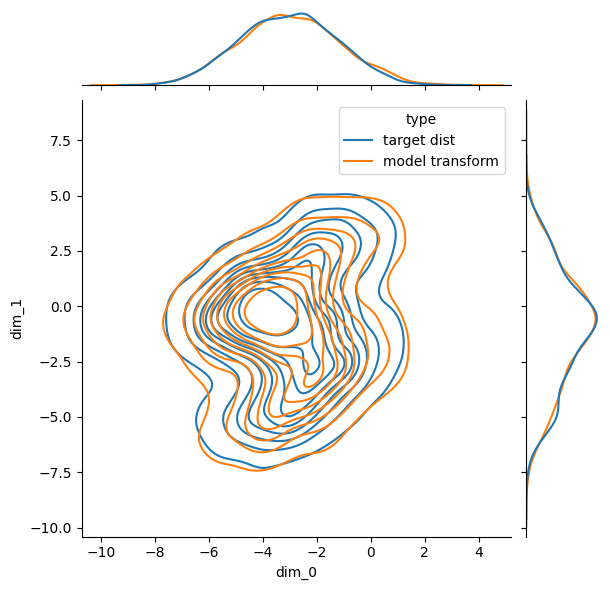

trail: 0 m step: 4 kl_test: 0.05884075164794922


  2%|▏         | 100/6000 [00:30<33:43,  2.92it/s]

trail: 0 m step: 5 Loss: 0.0472801120282767  L_n: 0.04270172119140625  kld: 0.0016999244689941406 KLD1: 0.04564407095313072 KLD2: 0.04044632613658905


  3%|▎         | 200/6000 [01:01<32:32,  2.97it/s]

trail: 0 m step: 5 Loss: 0.055937265851049675  L_n: 0.0451507568359375  kld: 0.004004955291748047 KLD1: 0.041786979883909225 KLD2: 0.032741595059633255


  5%|▌         | 300/6000 [01:31<32:13,  2.95it/s]

trail: 0 m step: 5 Loss: 0.045746545839426174  L_n: 0.04032182693481445  kld: 0.00201416015625 KLD1: 0.04717468470335007 KLD2: 0.03624247387051582


  7%|▋         | 400/6000 [02:02<31:33,  2.96it/s]

trail: 0 m step: 5 Loss: 0.053073077186650455  L_n: 0.043523311614990234  kld: 0.0035457611083984375 KLD1: 0.04061887785792351 KLD2: 0.031003249809145927


  8%|▊         | 500/6000 [02:33<30:58,  2.96it/s]

trail: 0 m step: 5 Loss: 0.05402334356852638  L_n: 0.0432586669921875  kld: 0.003996849060058594 KLD1: 0.037173084914684296 KLD2: 0.0368901789188385


 10%|█         | 600/6000 [03:03<30:25,  2.96it/s]

trail: 0 m step: 5 Loss: 0.048543096763461926  L_n: 0.03846549987792969  kld: 0.003741741180419922 KLD1: 0.0412193164229393 KLD2: 0.03393181413412094


 12%|█▏        | 700/6000 [03:34<29:51,  2.96it/s]

trail: 0 m step: 5 Loss: 0.05380547010541533  L_n: 0.04765129089355469  kld: 0.002285003662109375 KLD1: 0.0431581549346447 KLD2: 0.03390749543905258


 13%|█▎        | 800/6000 [04:05<29:26,  2.94it/s]

trail: 0 m step: 5 Loss: 0.045087267442590284  L_n: 0.0366368293762207  kld: 0.0031375885009765625 KLD1: 0.04205791652202606 KLD2: 0.03397644683718681


 15%|█▌        | 900/6000 [04:35<28:51,  2.95it/s]

trail: 0 m step: 5 Loss: 0.05325572866781582  L_n: 0.04434680938720703  kld: 0.003307819366455078 KLD1: 0.041191354393959045 KLD2: 0.033745624125003815


 17%|█▋        | 1000/6000 [05:06<28:18,  2.94it/s]

trail: 0 m step: 5 Loss: 0.04904613101812093  L_n: 0.0395503044128418  kld: 0.0035257339477539062 KLD1: 0.03893154114484787 KLD2: 0.032297953963279724


 18%|█▊        | 1100/6000 [05:36<27:34,  2.96it/s]

trail: 0 m step: 5 Loss: 0.05435189199133373  L_n: 0.04246091842651367  kld: 0.004415035247802734 KLD1: 0.04378953203558922 KLD2: 0.029252462089061737


 20%|██        | 1200/6000 [06:07<27:02,  2.96it/s]

trail: 0 m step: 5 Loss: 0.053096323367016855  L_n: 0.04728889465332031  kld: 0.0021562576293945312 KLD1: 0.045325879007577896 KLD2: 0.03677717223763466


 22%|██▏       | 1300/6000 [06:38<26:35,  2.95it/s]

trail: 0 m step: 5 Loss: 0.04435033771094179  L_n: 0.033879756927490234  kld: 0.003887653350830078 KLD1: 0.0403861403465271 KLD2: 0.03769344091415405


 23%|██▎       | 1400/6000 [07:08<25:57,  2.95it/s]

trail: 0 m step: 5 Loss: 0.04909080746575877  L_n: 0.037985801696777344  kld: 0.004123210906982422 KLD1: 0.04072213172912598 KLD2: 0.03445560112595558


 25%|██▌       | 1500/6000 [07:39<25:27,  2.95it/s]

trail: 0 m step: 5 Loss: 0.04628019823499169  L_n: 0.03653907775878906  kld: 0.003616809844970703 KLD1: 0.041973792016506195 KLD2: 0.030475420877337456


 27%|██▋       | 1600/6000 [08:10<24:53,  2.95it/s]

trail: 0 m step: 5 Loss: 0.05263629588314415  L_n: 0.03996706008911133  kld: 0.004703998565673828 KLD1: 0.04185543581843376 KLD2: 0.03175590559840202


 28%|██▊       | 1700/6000 [08:40<24:16,  2.95it/s]

trail: 0 m step: 5 Loss: 0.046990007662394084  L_n: 0.03940773010253906  kld: 0.00281524658203125 KLD1: 0.03789879009127617 KLD2: 0.03343049809336662


 30%|███       | 1800/6000 [09:11<23:37,  2.96it/s]

trail: 0 m step: 5 Loss: 0.05414795346754807  L_n: 0.0403447151184082  kld: 0.0051250457763671875 KLD1: 0.037217240780591965 KLD2: 0.03150150552392006


 32%|███▏      | 1900/6000 [09:41<23:10,  2.95it/s]

trail: 0 m step: 5 Loss: 0.05217198596126901  L_n: 0.04648399353027344  kld: 0.0021119117736816406 KLD1: 0.04455072432756424 KLD2: 0.03458842262625694


 33%|███▎      | 2000/6000 [10:12<22:34,  2.95it/s]

trail: 0 m step: 5 Loss: 0.05447515820648981  L_n: 0.042222023010253906  kld: 0.004549503326416016 KLD1: 0.03517637029290199 KLD2: 0.0330258309841156


 35%|███▌      | 2100/6000 [10:43<22:01,  2.95it/s]

trail: 0 m step: 5 Loss: 0.04409238402556372  L_n: 0.039006710052490234  kld: 0.001888275146484375 KLD1: 0.042737651616334915 KLD2: 0.03561551123857498


 37%|███▋      | 2200/6000 [11:13<21:27,  2.95it/s]

trail: 0 m step: 5 Loss: 0.054950852781989384  L_n: 0.043215274810791016  kld: 0.004357337951660156 KLD1: 0.03982916474342346 KLD2: 0.03627073019742966


 38%|███▊      | 2300/6000 [11:44<20:54,  2.95it/s]

trail: 0 m step: 5 Loss: 0.05180094115487066  L_n: 0.04277515411376953  kld: 0.0033512115478515625 KLD1: 0.037620965391397476 KLD2: 0.034337326884269714


 40%|████      | 2400/6000 [12:15<20:17,  2.96it/s]

trail: 0 m step: 5 Loss: 0.04135853339091373  L_n: 0.03726816177368164  kld: 0.0015187263488769531 KLD1: 0.04406188800930977 KLD2: 0.035548340529203415


 42%|████▏     | 2500/6000 [12:45<19:47,  2.95it/s]

trail: 0 m step: 5 Loss: 0.04817730020179706  L_n: 0.03817033767700195  kld: 0.00371551513671875 KLD1: 0.03812837600708008 KLD2: 0.031779415905475616


 43%|████▎     | 2600/6000 [13:16<19:16,  2.94it/s]

trail: 0 m step: 5 Loss: 0.05077610384375022  L_n: 0.04176187515258789  kld: 0.0033469200134277344 KLD1: 0.03771110624074936 KLD2: 0.034538283944129944


 45%|████▌     | 2700/6000 [13:47<18:40,  2.95it/s]

trail: 0 m step: 5 Loss: 0.052169237682317876  L_n: 0.04355955123901367  kld: 0.00319671630859375 KLD1: 0.0394120030105114 KLD2: 0.03393266350030899


 47%|████▋     | 2800/6000 [14:17<18:03,  2.95it/s]

trail: 0 m step: 5 Loss: 0.04371752147306388  L_n: 0.03590536117553711  kld: 0.0029006004333496094 KLD1: 0.04054834321141243 KLD2: 0.03333458676934242


 48%|████▊     | 2900/6000 [14:48<17:32,  2.94it/s]

trail: 0 m step: 5 Loss: 0.0456746378833732  L_n: 0.03979015350341797  kld: 0.0021848678588867188 KLD1: 0.04510532319545746 KLD2: 0.03078022040426731


 50%|█████     | 3000/6000 [15:19<16:57,  2.95it/s]

trail: 0 m step: 5 Loss: 0.04653551635074166  L_n: 0.03641939163208008  kld: 0.0037560462951660156 KLD1: 0.03954719007015228 KLD2: 0.03621881082653999


 52%|█████▏    | 3100/6000 [15:49<16:26,  2.94it/s]

trail: 0 m step: 5 Loss: 0.05146256350485405  L_n: 0.03833484649658203  kld: 0.004874229431152344 KLD1: 0.03571794554591179 KLD2: 0.03196502476930618


 53%|█████▎    | 3200/6000 [16:20<15:50,  2.95it/s]

trail: 0 m step: 5 Loss: 0.04486873739970539  L_n: 0.033682823181152344  kld: 0.004153251647949219 KLD1: 0.04023123160004616 KLD2: 0.03251498192548752


 55%|█████▌    | 3300/6000 [16:50<15:11,  2.96it/s]

trail: 0 m step: 5 Loss: 0.05385319191755704  L_n: 0.0444793701171875  kld: 0.0034804344177246094 KLD1: 0.03948701545596123 KLD2: 0.034770041704177856


 57%|█████▋    | 3400/6000 [17:21<14:37,  2.96it/s]

trail: 0 m step: 5 Loss: 0.04917432708528177  L_n: 0.04068279266357422  kld: 0.0031528472900390625 KLD1: 0.03740352764725685 KLD2: 0.03498870134353638


 58%|█████▊    | 3500/6000 [17:52<14:09,  2.94it/s]

trail: 0 m step: 5 Loss: 0.04969361188551421  L_n: 0.04298591613769531  kld: 0.002490520477294922 KLD1: 0.03953490033745766 KLD2: 0.031038781628012657


 60%|██████    | 3600/6000 [18:22<13:31,  2.96it/s]

trail: 0 m step: 5 Loss: 0.048667330372695786  L_n: 0.0354766845703125  kld: 0.004897594451904297 KLD1: 0.033710721880197525 KLD2: 0.03416191786527634


 62%|██████▏   | 3700/6000 [18:53<13:00,  2.95it/s]

trail: 0 m step: 5 Loss: 0.05144065489013335  L_n: 0.039548397064208984  kld: 0.0044155120849609375 KLD1: 0.037483394145965576 KLD2: 0.031541090458631516


 63%|██████▎   | 3800/6000 [19:24<12:26,  2.95it/s]

trail: 0 m step: 5 Loss: 0.049538214777748675  L_n: 0.04007577896118164  kld: 0.003513336181640625 KLD1: 0.03826296329498291 KLD2: 0.029656367376446724


 65%|██████▌   | 3900/6000 [19:54<11:52,  2.95it/s]

trail: 0 m step: 5 Loss: 0.05073865003561388  L_n: 0.04213666915893555  kld: 0.0031938552856445312 KLD1: 0.03564457967877388 KLD2: 0.03648970276117325


 67%|██████▋   | 4000/6000 [20:25<11:18,  2.95it/s]

trail: 0 m step: 5 Loss: 0.052125077684872005  L_n: 0.04401111602783203  kld: 0.0030126571655273438 KLD1: 0.04253073036670685 KLD2: 0.032586369663476944


 68%|██████▊   | 4100/6000 [20:56<10:45,  2.94it/s]

trail: 0 m step: 5 Loss: 0.04468334065631823  L_n: 0.039372920989990234  kld: 0.001971721649169922 KLD1: 0.03915724530816078 KLD2: 0.0316762700676918


 70%|███████   | 4200/6000 [21:26<10:10,  2.95it/s]

trail: 0 m step: 5 Loss: 0.0457938197539494  L_n: 0.038979530334472656  kld: 0.0025300979614257812 KLD1: 0.04042360559105873 KLD2: 0.030272703617811203


 72%|███████▏  | 4300/6000 [21:57<09:36,  2.95it/s]

trail: 0 m step: 5 Loss: 0.052757202278795136  L_n: 0.04247283935546875  kld: 0.003818511962890625 KLD1: 0.03952718526124954 KLD2: 0.03100818395614624


 73%|███████▎  | 4400/6000 [22:28<09:01,  2.95it/s]

trail: 0 m step: 5 Loss: 0.04419683117935905  L_n: 0.03553962707519531  kld: 0.0032143592834472656 KLD1: 0.03836214169859886 KLD2: 0.03064608760178089


 75%|███████▌  | 4500/6000 [22:58<08:28,  2.95it/s]

trail: 0 m step: 5 Loss: 0.052195699869529606  L_n: 0.04042673110961914  kld: 0.0043697357177734375 KLD1: 0.03375164046883583 KLD2: 0.030797796323895454


 77%|███████▋  | 4600/6000 [23:29<07:53,  2.96it/s]

trail: 0 m step: 5 Loss: 0.05326950059459497  L_n: 0.03918886184692383  kld: 0.0052280426025390625 KLD1: 0.030624251812696457 KLD2: 0.03233196958899498


 78%|███████▊  | 4700/6000 [24:00<07:21,  2.94it/s]

trail: 0 m step: 5 Loss: 0.04768318721330492  L_n: 0.03918266296386719  kld: 0.0031561851501464844 KLD1: 0.036973096430301666 KLD2: 0.03322092816233635


 80%|████████  | 4800/6000 [24:30<06:46,  2.95it/s]

trail: 0 m step: 5 Loss: 0.038098221038793616  L_n: 0.02846240997314453  kld: 0.003577709197998047 KLD1: 0.036747537553310394 KLD2: 0.030397038906812668


 82%|████████▏ | 4900/6000 [25:01<06:13,  2.95it/s]

trail: 0 m step: 5 Loss: 0.04941587024339638  L_n: 0.04070472717285156  kld: 0.003234386444091797 KLD1: 0.03937916457653046 KLD2: 0.03076392225921154


 83%|████████▎ | 5000/6000 [25:32<05:38,  2.96it/s]

trail: 0 m step: 5 Loss: 0.04326319468810154  L_n: 0.034476280212402344  kld: 0.0032625198364257812 KLD1: 0.03818020597100258 KLD2: 0.03275848180055618


 85%|████████▌ | 5100/6000 [26:02<05:04,  2.95it/s]

trail: 0 m step: 5 Loss: 0.04321647074041657  L_n: 0.03441286087036133  kld: 0.003268718719482422 KLD1: 0.04051180183887482 KLD2: 0.03235939145088196


 87%|████████▋ | 5200/6000 [26:33<04:30,  2.95it/s]

trail: 0 m step: 5 Loss: 0.045109675731200144  L_n: 0.0400843620300293  kld: 0.0018658638000488281 KLD1: 0.04262799024581909 KLD2: 0.03371096029877663


 88%|████████▊ | 5300/6000 [27:03<03:57,  2.95it/s]

trail: 0 m step: 5 Loss: 0.053755236171959916  L_n: 0.04031801223754883  kld: 0.004989147186279297 KLD1: 0.032969556748867035 KLD2: 0.03038913570344448


 90%|█████████ | 5400/6000 [27:34<03:23,  2.95it/s]

trail: 0 m step: 5 Loss: 0.054951133102797665  L_n: 0.04083967208862305  kld: 0.0052394866943359375 KLD1: 0.032714031636714935 KLD2: 0.03191827982664108


 92%|█████████▏| 5500/6000 [28:05<02:49,  2.95it/s]

trail: 0 m step: 5 Loss: 0.05124206667773244  L_n: 0.042073726654052734  kld: 0.0034041404724121094 KLD1: 0.04031036049127579 KLD2: 0.03253915160894394


 93%|█████████▎| 5600/6000 [28:35<02:15,  2.95it/s]

trail: 0 m step: 5 Loss: 0.052344054112515796  L_n: 0.041823387145996094  kld: 0.00390625 KLD1: 0.03939872980117798 KLD2: 0.02919011190533638


 95%|█████████▌| 5700/6000 [29:06<01:41,  2.96it/s]

trail: 0 m step: 5 Loss: 0.04703900305572476  L_n: 0.04118919372558594  kld: 0.0021719932556152344 KLD1: 0.04057927057147026 KLD2: 0.03130732476711273


 97%|█████████▋| 5800/6000 [29:37<01:07,  2.94it/s]

trail: 0 m step: 5 Loss: 0.04628474874837277  L_n: 0.038446903228759766  kld: 0.002910137176513672 KLD1: 0.03884324058890343 KLD2: 0.03349359706044197


 98%|█████████▊| 5900/6000 [30:07<00:33,  2.95it/s]

trail: 0 m step: 5 Loss: 0.0501470611836659  L_n: 0.03958272933959961  kld: 0.003922462463378906 KLD1: 0.03623441234230995 KLD2: 0.02937089093029499


100%|██████████| 6000/6000 [30:38<00:00,  3.26it/s]

trail: 0 m step: 5 Loss: 0.042599778617743424  L_n: 0.03287792205810547  kld: 0.0036096572875976562 KLD1: 0.036466196179389954 KLD2: 0.030815623700618744



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


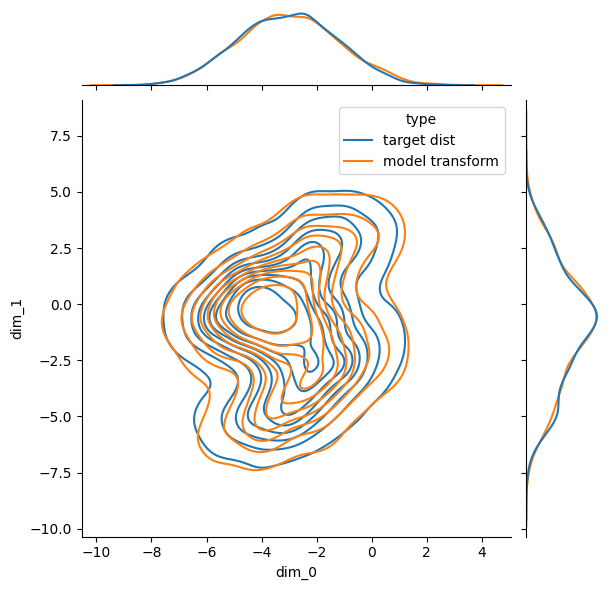

trail: 0 m step: 5 kl_test: 0.03576087951660156


  2%|▏         | 100/6000 [00:30<33:51,  2.90it/s]

trail: 0 m step: 6 Loss: 0.030447207562953254  L_n: 0.027715682983398438  kld: 0.0013184547424316406 KLD1: 0.027348164469003677 KLD2: 0.0261650662869215


  3%|▎         | 200/6000 [01:01<32:30,  2.97it/s]

trail: 0 m step: 6 Loss: 0.0320362047667097  L_n: 0.025885581970214844  kld: 0.0029687881469726562 KLD1: 0.02751949056982994 KLD2: 0.02051311917603016


  5%|▌         | 300/6000 [01:32<32:17,  2.94it/s]

trail: 0 m step: 6 Loss: 0.026850541482126157  L_n: 0.023606300354003906  kld: 0.0015659332275390625 KLD1: 0.029324669390916824 KLD2: 0.022846350446343422


  7%|▋         | 400/6000 [02:02<31:34,  2.96it/s]

trail: 0 m step: 6 Loss: 0.03208188702887447  L_n: 0.026938915252685547  kld: 0.0024824142456054688 KLD1: 0.024154765531420708 KLD2: 0.018798934295773506


  8%|▊         | 500/6000 [02:33<31:02,  2.95it/s]

trail: 0 m step: 6 Loss: 0.03254486427221135  L_n: 0.02632904052734375  kld: 0.0030002593994140625 KLD1: 0.023706883192062378 KLD2: 0.02348831668496132


 10%|█         | 600/6000 [03:04<30:36,  2.94it/s]

trail: 0 m step: 6 Loss: 0.028873421240479438  L_n: 0.02266550064086914  kld: 0.0029964447021484375 KLD1: 0.025057710707187653 KLD2: 0.02102218009531498


 12%|█▏        | 700/6000 [03:34<29:58,  2.95it/s]

trail: 0 m step: 6 Loss: 0.031994554454729374  L_n: 0.028987407684326172  kld: 0.0014514923095703125 KLD1: 0.027297137305140495 KLD2: 0.02123434841632843


 13%|█▎        | 800/6000 [04:05<29:25,  2.94it/s]

trail: 0 m step: 6 Loss: 0.02708578732538694  L_n: 0.021758079528808594  kld: 0.002571582794189453 KLD1: 0.02735697478055954 KLD2: 0.021717334166169167


 15%|█▌        | 900/6000 [04:36<28:52,  2.94it/s]

trail: 0 m step: 6 Loss: 0.031030009570269586  L_n: 0.02594137191772461  kld: 0.002456188201904297 KLD1: 0.024789981544017792 KLD2: 0.020179376006126404


 17%|█▋        | 1000/6000 [05:06<28:14,  2.95it/s]

trail: 0 m step: 6 Loss: 0.03229352819690047  L_n: 0.026767253875732422  kld: 0.0026674270629882812 KLD1: 0.02441929094493389 KLD2: 0.019739026203751564


 18%|█▊        | 1100/6000 [05:37<27:49,  2.94it/s]

trail: 0 m step: 6 Loss: 0.0353501927859005  L_n: 0.027906417846679688  kld: 0.003592967987060547 KLD1: 0.026948582381010056 KLD2: 0.018567949533462524


 20%|██        | 1200/6000 [06:08<27:07,  2.95it/s]

trail: 0 m step: 6 Loss: 0.03265751419985127  L_n: 0.029315471649169922  kld: 0.0016131401062011719 KLD1: 0.028283214196562767 KLD2: 0.023387106135487556


 22%|██▏       | 1300/6000 [06:38<26:32,  2.95it/s]

trail: 0 m step: 6 Loss: 0.026574159222484094  L_n: 0.02007579803466797  kld: 0.0031366348266601562 KLD1: 0.0266269464045763 KLD2: 0.025015814229846


 23%|██▎       | 1400/6000 [07:09<25:50,  2.97it/s]

trail: 0 m step: 6 Loss: 0.029499934641575926  L_n: 0.023183345794677734  kld: 0.0030488967895507812 KLD1: 0.025912340730428696 KLD2: 0.021919451653957367


 25%|██▌       | 1500/6000 [07:40<25:26,  2.95it/s]

trail: 0 m step: 6 Loss: 0.03021390646887353  L_n: 0.024044513702392578  kld: 0.0029778480529785156 KLD1: 0.028039364144206047 KLD2: 0.019107457250356674


 27%|██▋       | 1600/6000 [08:10<24:54,  2.94it/s]

trail: 0 m step: 6 Loss: 0.03135481513599443  L_n: 0.023868560791015625  kld: 0.0036134719848632812 KLD1: 0.026331298053264618 KLD2: 0.019948726519942284


 28%|██▊       | 1700/6000 [08:41<24:19,  2.95it/s]

trail: 0 m step: 6 Loss: 0.028276874979543436  L_n: 0.02432727813720703  kld: 0.0019063949584960938 KLD1: 0.019653618335723877 KLD2: 0.020496360957622528


 30%|███       | 1800/6000 [09:12<23:49,  2.94it/s]

trail: 0 m step: 6 Loss: 0.0344409954629855  L_n: 0.02554798126220703  kld: 0.004292488098144531 KLD1: 0.02125031314790249 KLD2: 0.019433077424764633


 32%|███▏      | 1900/6000 [09:42<23:15,  2.94it/s]

trail: 0 m step: 6 Loss: 0.03382222206429697  L_n: 0.030486106872558594  kld: 0.0016102790832519531 KLD1: 0.027313418686389923 KLD2: 0.021675104275345802


 33%|███▎      | 2000/6000 [10:13<22:40,  2.94it/s]

trail: 0 m step: 6 Loss: 0.032158000863778714  L_n: 0.024748802185058594  kld: 0.0035762786865234375 KLD1: 0.022544819861650467 KLD2: 0.021306924521923065


 35%|███▌      | 2100/6000 [10:44<22:03,  2.95it/s]

trail: 0 m step: 6 Loss: 0.025710903132985543  L_n: 0.023086071014404297  kld: 0.0012669563293457031 KLD1: 0.026365946978330612 KLD2: 0.022016417235136032


 37%|███▋      | 2200/6000 [11:15<21:27,  2.95it/s]

trail: 0 m step: 6 Loss: 0.034158073403396515  L_n: 0.027513504028320312  kld: 0.0032072067260742188 KLD1: 0.024661319330334663 KLD2: 0.022668257355690002


 38%|███▊      | 2300/6000 [11:45<20:57,  2.94it/s]

trail: 0 m step: 6 Loss: 0.032950600894454826  L_n: 0.02747964859008789  kld: 0.0026407241821289062 KLD1: 0.022204512730240822 KLD2: 0.021482128649950027


 40%|████      | 2400/6000 [12:16<20:22,  2.95it/s]

trail: 0 m step: 6 Loss: 0.026032952081348273  L_n: 0.023746967315673828  kld: 0.0011034011840820312 KLD1: 0.027610626071691513 KLD2: 0.02281017228960991


 42%|████▏     | 2500/6000 [12:47<19:46,  2.95it/s]

trail: 0 m step: 6 Loss: 0.028447828196845198  L_n: 0.022550106048583984  kld: 0.0028467178344726562 KLD1: 0.023746440187096596 KLD2: 0.01923271454870701


 43%|████▎     | 2600/6000 [13:17<19:14,  2.94it/s]

trail: 0 m step: 6 Loss: 0.031373406034737074  L_n: 0.02646160125732422  kld: 0.0023708343505859375 KLD1: 0.024490240961313248 KLD2: 0.022480636835098267


 45%|████▌     | 2700/6000 [13:48<18:40,  2.95it/s]

trail: 0 m step: 6 Loss: 0.031488642072837816  L_n: 0.02629232406616211  kld: 0.0025081634521484375 KLD1: 0.023577988147735596 KLD2: 0.021823672577738762


 47%|████▋     | 2800/6000 [14:19<18:08,  2.94it/s]

trail: 0 m step: 6 Loss: 0.02821372224368637  L_n: 0.023031234741210938  kld: 0.0025014877319335938 KLD1: 0.023386230692267418 KLD2: 0.021282780915498734


 48%|████▊     | 2900/6000 [14:49<17:29,  2.95it/s]

trail: 0 m step: 6 Loss: 0.029853745108802704  L_n: 0.026304244995117188  kld: 0.0017132759094238281 KLD1: 0.029053328558802605 KLD2: 0.0181271992623806


 50%|█████     | 3000/6000 [15:20<17:00,  2.94it/s]

trail: 0 m step: 6 Loss: 0.027632191851552832  L_n: 0.021562576293945312  kld: 0.0029296875 KLD1: 0.022503962740302086 KLD2: 0.022999610751867294


 52%|█████▏    | 3100/6000 [15:51<16:25,  2.94it/s]

trail: 0 m step: 6 Loss: 0.02947369758741036  L_n: 0.02153301239013672  kld: 0.0038328170776367188 KLD1: 0.02271135337650776 KLD2: 0.02018383890390396


 53%|█████▎    | 3200/6000 [16:21<15:49,  2.95it/s]

trail: 0 m step: 6 Loss: 0.026776076966855536  L_n: 0.019996166229248047  kld: 0.003272533416748047 KLD1: 0.022946109995245934 KLD2: 0.019752996042370796


 55%|█████▌    | 3300/6000 [16:52<15:15,  2.95it/s]

trail: 0 m step: 6 Loss: 0.03452754672853525  L_n: 0.028986454010009766  kld: 0.002674579620361328 KLD1: 0.026221344247460365 KLD2: 0.02149740420281887


 57%|█████▋    | 3400/6000 [17:23<14:41,  2.95it/s]

trail: 0 m step: 6 Loss: 0.029601168371372586  L_n: 0.02513885498046875  kld: 0.0021538734436035156 KLD1: 0.023016782477498055 KLD2: 0.021941320970654488


 58%|█████▊    | 3500/6000 [17:53<14:09,  2.94it/s]

trail: 0 m step: 6 Loss: 0.02921513359201268  L_n: 0.025393962860107422  kld: 0.0018444061279296875 KLD1: 0.023649975657463074 KLD2: 0.019473452121019363


 60%|██████    | 3600/6000 [18:24<13:33,  2.95it/s]

trail: 0 m step: 6 Loss: 0.031697326951129506  L_n: 0.02395915985107422  kld: 0.003735065460205078 KLD1: 0.01941302791237831 KLD2: 0.02225848101079464


 62%|██████▏   | 3700/6000 [18:54<13:01,  2.94it/s]

trail: 0 m step: 6 Loss: 0.029876982993138745  L_n: 0.022462844848632812  kld: 0.003578662872314453 KLD1: 0.02495010383427143 KLD2: 0.019805846735835075


 63%|██████▎   | 3800/6000 [19:25<12:26,  2.95it/s]

trail: 0 m step: 6 Loss: 0.028190026754891268  L_n: 0.022521495819091797  kld: 0.0027360916137695312 KLD1: 0.02363181859254837 KLD2: 0.017846914008259773


 65%|██████▌   | 3900/6000 [19:56<11:53,  2.94it/s]

trail: 0 m step: 6 Loss: 0.03141133386996953  L_n: 0.02532196044921875  kld: 0.0029392242431640625 KLD1: 0.02002577856183052 KLD2: 0.023072166368365288


 67%|██████▋   | 4000/6000 [20:27<11:16,  2.96it/s]

trail: 0 m step: 6 Loss: 0.033505010280147796  L_n: 0.028768062591552734  kld: 0.0022864341735839844 KLD1: 0.025562848895788193 KLD2: 0.0204320065677166


 68%|██████▊   | 4100/6000 [20:57<10:45,  2.94it/s]

trail: 0 m step: 6 Loss: 0.027919202578643353  L_n: 0.0242462158203125  kld: 0.0017728805541992188 KLD1: 0.024307850748300552 KLD2: 0.019921505823731422


 70%|███████   | 4200/6000 [21:28<10:11,  2.94it/s]

trail: 0 m step: 6 Loss: 0.02812227685141088  L_n: 0.023542404174804688  kld: 0.0022106170654296875 KLD1: 0.02354537323117256 KLD2: 0.018180642277002335


 72%|███████▏  | 4300/6000 [21:58<09:34,  2.96it/s]

trail: 0 m step: 6 Loss: 0.028934096395422777  L_n: 0.022846698760986328  kld: 0.0029382705688476562 KLD1: 0.025953082367777824 KLD2: 0.01867113821208477


 73%|███████▎  | 4400/6000 [22:29<09:01,  2.95it/s]

trail: 0 m step: 6 Loss: 0.0263021162952908  L_n: 0.021118640899658203  kld: 0.002501964569091797 KLD1: 0.024222277104854584 KLD2: 0.019383365288376808


 75%|███████▌  | 4500/6000 [23:00<08:29,  2.94it/s]

trail: 0 m step: 6 Loss: 0.03097297790863316  L_n: 0.02344226837158203  kld: 0.003634929656982422 KLD1: 0.01826794072985649 KLD2: 0.019260989502072334


 77%|███████▋  | 4600/6000 [23:30<07:53,  2.96it/s]

trail: 0 m step: 6 Loss: 0.03586569981572079  L_n: 0.026231765747070312  kld: 0.004650115966796875 KLD1: 0.017410021275281906 KLD2: 0.02008098177611828


 78%|███████▊  | 4700/6000 [24:01<07:19,  2.96it/s]

trail: 0 m step: 6 Loss: 0.028127796398179652  L_n: 0.023113250732421875  kld: 0.0024204254150390625 KLD1: 0.02122776210308075 KLD2: 0.020860040560364723


 80%|████████  | 4800/6000 [24:32<06:47,  2.94it/s]

trail: 0 m step: 6 Loss: 0.02218822099978872  L_n: 0.016474246978759766  kld: 0.002758026123046875 KLD1: 0.02201807126402855 KLD2: 0.018686067312955856


 82%|████████▏ | 4900/6000 [25:02<06:12,  2.95it/s]

trail: 0 m step: 6 Loss: 0.0293914980717312  L_n: 0.024071693420410156  kld: 0.002567768096923828 KLD1: 0.022320225834846497 KLD2: 0.018573595210909843


 83%|████████▎ | 5000/6000 [25:33<05:38,  2.95it/s]

trail: 0 m step: 6 Loss: 0.02591360334771468  L_n: 0.020685672760009766  kld: 0.0025234222412109375 KLD1: 0.023473968729376793 KLD2: 0.020265541970729828


 85%|████████▌ | 5100/6000 [26:03<05:04,  2.96it/s]

trail: 0 m step: 6 Loss: 0.025277741290902055  L_n: 0.01983642578125  kld: 0.0026264190673828125 KLD1: 0.023770024999976158 KLD2: 0.02038944698870182


 87%|████████▋ | 5200/6000 [26:34<04:30,  2.95it/s]

trail: 0 m step: 6 Loss: 0.027326174533418113  L_n: 0.024791240692138672  kld: 0.0012235641479492188 KLD1: 0.024924520403146744 KLD2: 0.021207589656114578


 88%|████████▊ | 5300/6000 [27:05<03:57,  2.95it/s]

trail: 0 m step: 6 Loss: 0.032842672579536804  L_n: 0.024788379669189453  kld: 0.003887653350830078 KLD1: 0.022206246852874756 KLD2: 0.019165968522429466


 90%|█████████ | 5400/6000 [27:35<03:23,  2.95it/s]

trail: 0 m step: 6 Loss: 0.03459183573376706  L_n: 0.02512979507446289  kld: 0.004567146301269531 KLD1: 0.019422946497797966 KLD2: 0.01936188153922558


 92%|█████████▏| 5500/6000 [28:06<02:49,  2.94it/s]

trail: 0 m step: 6 Loss: 0.03380293424871983  L_n: 0.028201580047607422  kld: 0.0027036666870117188 KLD1: 0.025412291288375854 KLD2: 0.020343095064163208


 93%|█████████▎| 5600/6000 [28:36<02:15,  2.95it/s]

trail: 0 m step: 6 Loss: 0.03021914722438899  L_n: 0.024077415466308594  kld: 0.002964496612548828 KLD1: 0.025078972801566124 KLD2: 0.01772207021713257


 95%|█████████▌| 5700/6000 [29:07<01:41,  2.94it/s]

trail: 0 m step: 6 Loss: 0.028500113165720983  L_n: 0.025332927703857422  kld: 0.0015287399291992188 KLD1: 0.026193400844931602 KLD2: 0.019032519310712814


 97%|█████████▋| 5800/6000 [29:38<01:07,  2.94it/s]

trail: 0 m step: 6 Loss: 0.02724838316850447  L_n: 0.022801876068115234  kld: 0.0021462440490722656 KLD1: 0.022624662145972252 KLD2: 0.021730734035372734


 98%|█████████▊| 5900/6000 [30:09<00:33,  2.95it/s]

trail: 0 m step: 6 Loss: 0.030519753854566817  L_n: 0.02398681640625  kld: 0.0031533241271972656 KLD1: 0.02141629531979561 KLD2: 0.01811390370130539


100%|██████████| 6000/6000 [30:39<00:00,  3.26it/s]

trail: 0 m step: 6 Loss: 0.02479912979350685  L_n: 0.018954753875732422  kld: 0.0028209686279296875 KLD1: 0.021247129887342453 KLD2: 0.019334448501467705



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


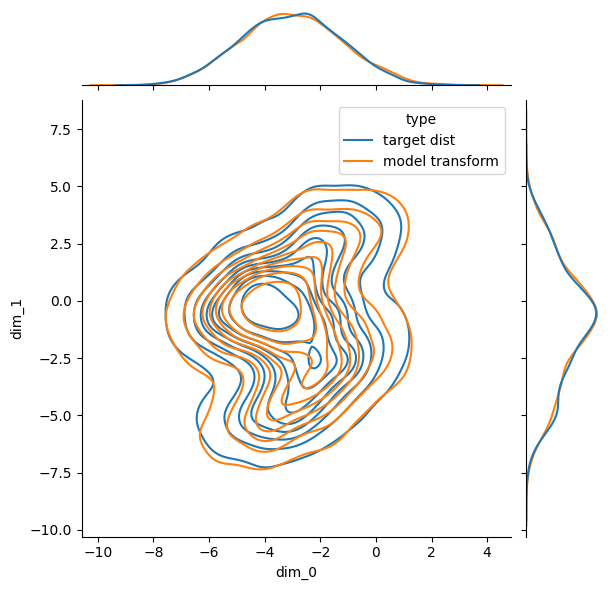

trail: 0 m step: 6 kl_test: 0.02365255355834961


  2%|▏         | 100/6000 [00:30<33:47,  2.91it/s]

trail: 0 m step: 7 Loss: 0.01928792841394792  L_n: 0.01791095733642578  kld: 0.0008640289306640625 KLD1: 0.016077185049653053 KLD2: 0.018150802701711655


  3%|▎         | 200/6000 [01:01<32:40,  2.96it/s]

trail: 0 m step: 7 Loss: 0.02030131262659638  L_n: 0.016480445861816406  kld: 0.0023975372314453125 KLD1: 0.016541557386517525 KLD2: 0.013940971344709396


  5%|▌         | 300/6000 [01:31<32:18,  2.94it/s]

trail: 0 m step: 7 Loss: 0.015807195807368696  L_n: 0.01442718505859375  kld: 0.000865936279296875 KLD1: 0.018961120396852493 KLD2: 0.015003838576376438


  7%|▋         | 400/6000 [02:02<31:42,  2.94it/s]

trail: 0 m step: 7 Loss: 0.01941351392319519  L_n: 0.016642093658447266  kld: 0.0017390251159667969 KLD1: 0.01696031726896763 KLD2: 0.01189572922885418


  8%|▊         | 500/6000 [02:33<30:58,  2.96it/s]

trail: 0 m step: 7 Loss: 0.021279161973655415  L_n: 0.01782989501953125  kld: 0.0021643638610839844 KLD1: 0.015721071511507034 KLD2: 0.015714840963482857


 10%|█         | 600/6000 [03:03<30:24,  2.96it/s]

trail: 0 m step: 7 Loss: 0.018338948539592143  L_n: 0.014784812927246094  kld: 0.0022301673889160156 KLD1: 0.014477556571364403 KLD2: 0.013555294834077358


 12%|█▏        | 700/6000 [03:34<29:51,  2.96it/s]

trail: 0 m step: 7 Loss: 0.01907957760942581  L_n: 0.017925262451171875  kld: 0.0007243156433105469 KLD1: 0.017686186358332634 KLD2: 0.013817289844155312


 13%|█▎        | 800/6000 [04:05<29:20,  2.95it/s]

trail: 0 m step: 7 Loss: 0.017612122804366408  L_n: 0.01448202133178711  kld: 0.001964092254638672 KLD1: 0.01717109978199005 KLD2: 0.014905547723174095


 15%|█▌        | 900/6000 [04:35<28:46,  2.95it/s]

trail: 0 m step: 7 Loss: 0.017342991292552276  L_n: 0.015003204345703125  kld: 0.0014681816101074219 KLD1: 0.015533027239143848 KLD2: 0.01244173850864172


 17%|█▋        | 1000/6000 [05:06<28:10,  2.96it/s]

trail: 0 m step: 7 Loss: 0.02024859096865429  L_n: 0.017223358154296875  kld: 0.0018982887268066406 KLD1: 0.013098657131195068 KLD2: 0.012295879423618317


 18%|█▊        | 1100/6000 [05:37<27:42,  2.95it/s]

trail: 0 m step: 7 Loss: 0.02152491282382319  L_n: 0.017545223236083984  kld: 0.0024971961975097656 KLD1: 0.017517609521746635 KLD2: 0.012473777867853642


 20%|██        | 1200/6000 [06:07<27:10,  2.94it/s]

trail: 0 m step: 7 Loss: 0.020144566511870146  L_n: 0.017676353454589844  kld: 0.00154876708984375 KLD1: 0.019237739965319633 KLD2: 0.01628156006336212


 22%|██▏       | 1300/6000 [06:38<26:32,  2.95it/s]

trail: 0 m step: 7 Loss: 0.01798242198480946  L_n: 0.014129638671875  kld: 0.0024175643920898438 KLD1: 0.01867019385099411 KLD2: 0.017854269593954086


 23%|██▎       | 1400/6000 [07:09<26:02,  2.94it/s]

trail: 0 m step: 7 Loss: 0.018739680208802397  L_n: 0.015089035034179688  kld: 0.0022907257080078125 KLD1: 0.0163591131567955 KLD2: 0.014608632773160934


 25%|██▌       | 1500/6000 [07:39<25:28,  2.94it/s]

trail: 0 m step: 7 Loss: 0.01894118566047101  L_n: 0.014689445495605469  kld: 0.0026679039001464844 KLD1: 0.018797840923070908 KLD2: 0.012998800724744797


 27%|██▋       | 1600/6000 [08:10<24:54,  2.94it/s]

trail: 0 m step: 7 Loss: 0.01776136224789899  L_n: 0.013069629669189453  kld: 0.0029439926147460938 KLD1: 0.017324818298220634 KLD2: 0.013527593575417995


 28%|██▊       | 1700/6000 [08:41<24:16,  2.95it/s]

trail: 0 m step: 7 Loss: 0.018834084677423212  L_n: 0.01638031005859375  kld: 0.0015397071838378906 KLD1: 0.014030062593519688 KLD2: 0.012699722312390804


 30%|███       | 1800/6000 [09:11<23:46,  2.94it/s]

trail: 0 m step: 7 Loss: 0.019648457370111207  L_n: 0.014084339141845703  kld: 0.0034914016723632812 KLD1: 0.01308040414005518 KLD2: 0.013041635043919086


 32%|███▏      | 1900/6000 [09:42<23:11,  2.95it/s]

trail: 0 m step: 7 Loss: 0.02211682092316426  L_n: 0.01985454559326172  kld: 0.0014195442199707031 KLD1: 0.016146771609783173 KLD2: 0.014424731023609638


 33%|███▎      | 2000/6000 [10:12<22:38,  2.95it/s]

trail: 0 m step: 7 Loss: 0.020128345046208456  L_n: 0.016674518585205078  kld: 0.002167224884033203 KLD1: 0.01600327156484127 KLD2: 0.014645754359662533


 35%|███▌      | 2100/6000 [10:43<22:03,  2.95it/s]

trail: 0 m step: 7 Loss: 0.015000233070906288  L_n: 0.013797283172607422  kld: 0.0007548332214355469 KLD1: 0.017845168709754944 KLD2: 0.014198528602719307


 37%|███▋      | 2200/6000 [11:14<21:28,  2.95it/s]

trail: 0 m step: 7 Loss: 0.022369641645164907  L_n: 0.018332958221435547  kld: 0.002532958984375 KLD1: 0.016875404864549637 KLD2: 0.014790496788918972


 38%|███▊      | 2300/6000 [11:44<20:53,  2.95it/s]

trail: 0 m step: 7 Loss: 0.020699056834038457  L_n: 0.017469406127929688  kld: 0.0020265579223632812 KLD1: 0.015095171518623829 KLD2: 0.014182389713823795


 40%|████      | 2400/6000 [12:15<20:26,  2.94it/s]

trail: 0 m step: 7 Loss: 0.015314891787751358  L_n: 0.014218330383300781  kld: 0.0006880760192871094 KLD1: 0.016892798244953156 KLD2: 0.014987627975642681


 42%|████▏     | 2500/6000 [12:46<19:50,  2.94it/s]

trail: 0 m step: 7 Loss: 0.017381229187444686  L_n: 0.014248847961425781  kld: 0.0019655227661132812 KLD1: 0.014719659462571144 KLD2: 0.01199774444103241


 43%|████▎     | 2600/6000 [13:16<19:12,  2.95it/s]

trail: 0 m step: 7 Loss: 0.018717727135500396  L_n: 0.016093730926513672  kld: 0.0016465187072753906 KLD1: 0.015479577705264091 KLD2: 0.015381954610347748


 45%|████▌     | 2700/6000 [13:47<18:39,  2.95it/s]

trail: 0 m step: 7 Loss: 0.021646042439427245  L_n: 0.018724918365478516  kld: 0.0018329620361328125 KLD1: 0.014904393814504147 KLD2: 0.014741518534719944


 47%|████▋     | 2800/6000 [14:18<18:06,  2.95it/s]

trail: 0 m step: 7 Loss: 0.015715593253944535  L_n: 0.013147830963134766  kld: 0.0016112327575683594 KLD1: 0.01677788607776165 KLD2: 0.01456589624285698


 48%|████▊     | 2900/6000 [14:48<17:34,  2.94it/s]

trail: 0 m step: 7 Loss: 0.020753872685466475  L_n: 0.018790245056152344  kld: 0.001232147216796875 KLD1: 0.018329408019781113 KLD2: 0.010739985853433609


 50%|█████     | 3000/6000 [15:19<16:59,  2.94it/s]

trail: 0 m step: 7 Loss: 0.018328798985473346  L_n: 0.014740467071533203  kld: 0.0022516250610351562 KLD1: 0.01566750928759575 KLD2: 0.015355105511844158


 52%|█████▏    | 3100/6000 [15:50<16:26,  2.94it/s]

trail: 0 m step: 7 Loss: 0.020419644055867298  L_n: 0.015802383422851562  kld: 0.0028972625732421875 KLD1: 0.013374566100537777 KLD2: 0.013492568396031857


 53%|█████▎    | 3200/6000 [16:21<15:50,  2.94it/s]

trail: 0 m step: 7 Loss: 0.01702496955310996  L_n: 0.012749671936035156  kld: 0.0026826858520507812 KLD1: 0.014605745673179626 KLD2: 0.012752579525113106


 55%|█████▌    | 3300/6000 [16:51<15:17,  2.94it/s]

trail: 0 m step: 7 Loss: 0.02089614670289975  L_n: 0.01725006103515625  kld: 0.0022878646850585938 KLD1: 0.014053366146981716 KLD2: 0.013779724016785622


 57%|█████▋    | 3400/6000 [17:22<14:43,  2.94it/s]

trail: 0 m step: 7 Loss: 0.017653269683516513  L_n: 0.015157699584960938  kld: 0.0015659332275390625 KLD1: 0.015943678095936775 KLD2: 0.014120565727353096


 58%|█████▊    | 3500/6000 [17:52<14:08,  2.95it/s]

trail: 0 m step: 7 Loss: 0.01713996998039494  L_n: 0.015475749969482422  kld: 0.0010442733764648438 KLD1: 0.016487011685967445 KLD2: 0.013123815879225731


 60%|██████    | 3600/6000 [18:23<13:34,  2.95it/s]

trail: 0 m step: 7 Loss: 0.0186848823753221  L_n: 0.01437234878540039  kld: 0.0027060508728027344 KLD1: 0.012497148476541042 KLD2: 0.01502294559031725


 62%|██████▏   | 3700/6000 [18:54<13:00,  2.95it/s]

trail: 0 m step: 7 Loss: 0.018029365931543438  L_n: 0.01372671127319336  kld: 0.0026998519897460938 KLD1: 0.015121188014745712 KLD2: 0.013178450055420399


 63%|██████▎   | 3800/6000 [19:24<12:23,  2.96it/s]

trail: 0 m step: 7 Loss: 0.01907210090835722  L_n: 0.01579761505126953  kld: 0.0020546913146972656 KLD1: 0.014666383154690266 KLD2: 0.011751765385270119


 65%|██████▌   | 3900/6000 [19:55<11:53,  2.94it/s]

trail: 0 m step: 7 Loss: 0.018992620444589763  L_n: 0.016307830810546875  kld: 0.0016846656799316406 KLD1: 0.013078584335744381 KLD2: 0.015336565673351288


 67%|██████▋   | 4000/6000 [20:26<11:18,  2.95it/s]

trail: 0 m step: 7 Loss: 0.02036306103763269  L_n: 0.01787281036376953  kld: 0.0015625953674316406 KLD1: 0.017262209206819534 KLD2: 0.013913865201175213


 68%|██████▊   | 4100/6000 [20:56<10:45,  2.95it/s]

trail: 0 m step: 7 Loss: 0.015482354410257495  L_n: 0.013353824615478516  kld: 0.0013356208801269531 KLD1: 0.012294884771108627 KLD2: 0.013520215637981892


 70%|███████   | 4200/6000 [21:27<10:12,  2.94it/s]

trail: 0 m step: 7 Loss: 0.018285403348251815  L_n: 0.015727519989013672  kld: 0.0016050338745117188 KLD1: 0.016061067581176758 KLD2: 0.011378084309399128


 72%|███████▏  | 4300/6000 [21:57<09:36,  2.95it/s]

trail: 0 m step: 7 Loss: 0.019027051319453436  L_n: 0.016510963439941406  kld: 0.0015788078308105469 KLD1: 0.016250358894467354 KLD2: 0.01191026158630848


 73%|███████▎  | 4400/6000 [22:28<09:02,  2.95it/s]

trail: 0 m step: 7 Loss: 0.014292359710137594  L_n: 0.011564254760742188  kld: 0.0017118453979492188 KLD1: 0.014174731448292732 KLD2: 0.012899791821837425


 75%|███████▌  | 4500/6000 [22:59<08:28,  2.95it/s]

trail: 0 m step: 7 Loss: 0.018788926175099856  L_n: 0.01454782485961914  kld: 0.0026612281799316406 KLD1: 0.0108134550973773 KLD2: 0.012758332304656506


 77%|███████▋  | 4600/6000 [23:29<07:55,  2.95it/s]

trail: 0 m step: 7 Loss: 0.021749789402160585  L_n: 0.016187191009521484  kld: 0.003490447998046875 KLD1: 0.01047621387988329 KLD2: 0.01318737119436264


 78%|███████▊  | 4700/6000 [24:00<07:21,  2.95it/s]

trail: 0 m step: 7 Loss: 0.01901622587148966  L_n: 0.01636791229248047  kld: 0.0016617774963378906 KLD1: 0.01601042039692402 KLD2: 0.014291206374764442


 80%|████████  | 4800/6000 [24:31<06:46,  2.95it/s]

trail: 0 m step: 7 Loss: 0.013440620138097723  L_n: 0.010637283325195312  kld: 0.0017590522766113281 KLD1: 0.012822570279240608 KLD2: 0.012668982148170471


 82%|████████▏ | 4900/6000 [25:02<06:12,  2.95it/s]

trail: 0 m step: 7 Loss: 0.018465684116368657  L_n: 0.014933586120605469  kld: 0.002216339111328125 KLD1: 0.013695258647203445 KLD2: 0.011739351786673069


 83%|████████▎ | 5000/6000 [25:32<05:38,  2.96it/s]

trail: 0 m step: 7 Loss: 0.0167666682567484  L_n: 0.013774871826171875  kld: 0.0018773078918457031 KLD1: 0.015076049603521824 KLD2: 0.01298670656979084


 85%|████████▌ | 5100/6000 [26:03<05:05,  2.95it/s]

trail: 0 m step: 7 Loss: 0.013877668297375384  L_n: 0.011021137237548828  kld: 0.0017924308776855469 KLD1: 0.013716592453420162 KLD2: 0.013536922633647919


 87%|████████▋ | 5200/6000 [26:34<04:31,  2.95it/s]

trail: 0 m step: 7 Loss: 0.016128887008341003  L_n: 0.015112876892089844  kld: 0.0006375312805175781 KLD1: 0.018075034022331238 KLD2: 0.014131642878055573


 88%|████████▊ | 5300/6000 [27:04<03:57,  2.94it/s]

trail: 0 m step: 7 Loss: 0.019666948781196465  L_n: 0.015179634094238281  kld: 0.002815723419189453 KLD1: 0.01557721383869648 KLD2: 0.012549982406198978


 90%|█████████ | 5400/6000 [27:35<03:23,  2.95it/s]

trail: 0 m step: 7 Loss: 0.020046149900763442  L_n: 0.014124870300292969  kld: 0.00371551513671875 KLD1: 0.011365585029125214 KLD2: 0.012307066470384598


 92%|█████████▏| 5500/6000 [28:05<02:49,  2.95it/s]

trail: 0 m step: 7 Loss: 0.022321038706221416  L_n: 0.018916606903076172  kld: 0.00213623046875 KLD1: 0.017469745129346848 KLD2: 0.013324830681085587


 93%|█████████▎| 5600/6000 [28:36<02:15,  2.95it/s]

trail: 0 m step: 7 Loss: 0.018724069423316295  L_n: 0.015176773071289062  kld: 0.0022258758544921875 KLD1: 0.015395019203424454 KLD2: 0.011383396573364735


 95%|█████████▌| 5700/6000 [29:07<01:41,  2.95it/s]

trail: 0 m step: 7 Loss: 0.019816829613852192  L_n: 0.018702030181884766  kld: 0.0006995201110839844 KLD1: 0.016475960612297058 KLD2: 0.011942455545067787


 97%|█████████▋| 5800/6000 [29:37<01:07,  2.95it/s]

trail: 0 m step: 7 Loss: 0.015659535593635705  L_n: 0.013648033142089844  kld: 0.0012621879577636719 KLD1: 0.01399185135960579 KLD2: 0.01497879158705473


 98%|█████████▊| 5900/6000 [30:08<00:33,  2.94it/s]

trail: 0 m step: 7 Loss: 0.019203830687358883  L_n: 0.015720367431640625  kld: 0.002185821533203125 KLD1: 0.013482223264873028 KLD2: 0.011865008622407913


100%|██████████| 6000/6000 [30:39<00:00,  3.26it/s]

trail: 0 m step: 7 Loss: 0.015912910005456367  L_n: 0.013537406921386719  kld: 0.0014905929565429688 KLD1: 0.01343280915170908 KLD2: 0.012836349196732044



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


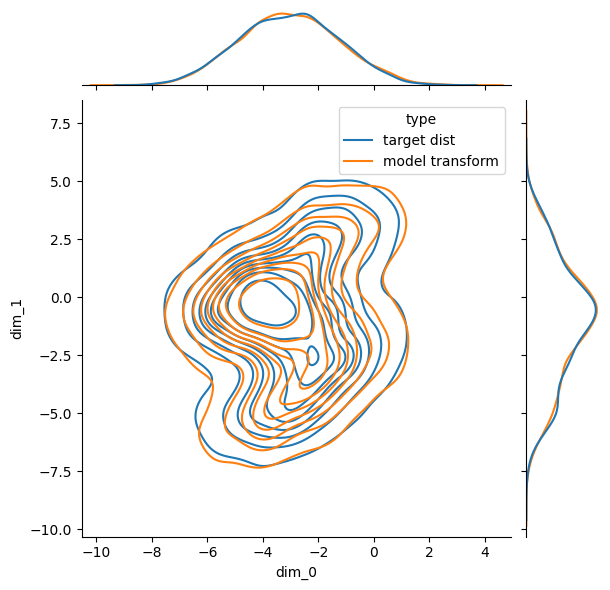

trail: 0 m step: 7 kl_test: 0.013064384460449219


  2%|▏         | 100/6000 [00:30<33:49,  2.91it/s]

trail: 0 m step: 8 Loss: 0.01320328813078175  L_n: 0.012270927429199219  kld: 0.0007605552673339844 KLD1: 0.011320456862449646 KLD2: 0.012998285703361034


  3%|▎         | 200/6000 [01:01<32:28,  2.98it/s]

trail: 0 m step: 8 Loss: 0.013788207712392152  L_n: 0.011441230773925781  kld: 0.0019145011901855469 KLD1: 0.010949206538498402 KLD2: 0.01004424411803484


  5%|▌         | 300/6000 [01:31<32:12,  2.95it/s]

trail: 0 m step: 8 Loss: 0.01157407499741466  L_n: 0.01105499267578125  kld: 0.000423431396484375 KLD1: 0.012078667990863323 KLD2: 0.009998248890042305


  7%|▋         | 400/6000 [02:02<31:29,  2.96it/s]

trail: 0 m step: 8 Loss: 0.01236720838430819  L_n: 0.010788917541503906  kld: 0.0012874603271484375 KLD1: 0.013448452576994896 KLD2: 0.00838530994951725


  8%|▊         | 500/6000 [02:32<30:54,  2.97it/s]

trail: 0 m step: 8 Loss: 0.01575043749019632  L_n: 0.013848304748535156  kld: 0.0015516281127929688 KLD1: 0.011141086928546429 KLD2: 0.011319424025714397


 10%|█         | 600/6000 [03:03<30:26,  2.96it/s]

trail: 0 m step: 8 Loss: 0.012891839683349903  L_n: 0.011488914489746094  kld: 0.0011444091796875 KLD1: 0.010275260545313358 KLD2: 0.00910880882292986


 12%|█▏        | 700/6000 [03:33<29:59,  2.95it/s]

trail: 0 m step: 8 Loss: 0.014824562374530387  L_n: 0.014572620391845703  kld: 0.00020551681518554688 KLD1: 0.01042958814650774 KLD2: 0.0104469433426857


 13%|█▎        | 800/6000 [04:04<29:15,  2.96it/s]

trail: 0 m step: 8 Loss: 0.013503159275961943  L_n: 0.011900901794433594  kld: 0.0013070106506347656 KLD1: 0.008404357358813286 KLD2: 0.011549754068255424


 15%|█▌        | 900/6000 [04:35<28:49,  2.95it/s]

trail: 0 m step: 8 Loss: 0.013788033438697502  L_n: 0.01236581802368164  kld: 0.0011601448059082031 KLD1: 0.011225174181163311 KLD2: 0.008125601336359978


 17%|█▋        | 1000/6000 [05:05<28:10,  2.96it/s]

trail: 0 m step: 8 Loss: 0.013553761737517458  L_n: 0.011790752410888672  kld: 0.001438140869140625 KLD1: 0.008998948149383068 KLD2: 0.008213738910853863


 18%|█▊        | 1100/6000 [05:36<27:39,  2.95it/s]

trail: 0 m step: 8 Loss: 0.015640055311228248  L_n: 0.013125896453857422  kld: 0.0020508766174316406 KLD1: 0.009685945697128773 KLD2: 0.009117824025452137


 20%|██        | 1200/6000 [06:06<27:04,  2.95it/s]

trail: 0 m step: 8 Loss: 0.014332705148842679  L_n: 0.013329029083251953  kld: 0.0008187294006347656 KLD1: 0.012061836197972298 KLD2: 0.011144982650876045


 22%|██▏       | 1300/6000 [06:37<26:34,  2.95it/s]

trail: 0 m step: 8 Loss: 0.012918755184340585  L_n: 0.011126518249511719  kld: 0.0014619827270507812 KLD1: 0.013702455908060074 KLD2: 0.013533521443605423


 23%|██▎       | 1400/6000 [07:07<25:56,  2.95it/s]

trail: 0 m step: 8 Loss: 0.013615644357886026  L_n: 0.012259483337402344  kld: 0.00110626220703125 KLD1: 0.012344169430434704 KLD2: 0.010684071108698845


 25%|██▌       | 1500/6000 [07:38<25:25,  2.95it/s]

trail: 0 m step: 8 Loss: 0.011999610002720486  L_n: 0.009823322296142578  kld: 0.0017752647399902344 KLD1: 0.013642065227031708 KLD2: 0.009437874890863895


 27%|██▋       | 1600/6000 [08:09<24:48,  2.96it/s]

trail: 0 m step: 8 Loss: 0.01283924746065987  L_n: 0.009537696838378906  kld: 0.00269317626953125 KLD1: 0.012098461389541626 KLD2: 0.01023706141859293


 28%|██▊       | 1700/6000 [08:39<24:14,  2.96it/s]

trail: 0 m step: 8 Loss: 0.01299894935569489  L_n: 0.01151418685913086  kld: 0.0012111663818359375 KLD1: 0.010729372501373291 KLD2: 0.009251981973648071


 30%|███       | 1800/6000 [09:10<23:42,  2.95it/s]

trail: 0 m step: 8 Loss: 0.013496386987185388  L_n: 0.01045846939086914  kld: 0.0024781227111816406 KLD1: 0.010483039543032646 KLD2: 0.010036544874310493


 32%|███▏      | 1900/6000 [09:40<23:06,  2.96it/s]

trail: 0 m step: 8 Loss: 0.015358056220843358  L_n: 0.014604568481445312  kld: 0.0006146430969238281 KLD1: 0.012276026420295238 KLD2: 0.010669988580048084


 33%|███▎      | 2000/6000 [10:11<22:31,  2.96it/s]

trail: 0 m step: 8 Loss: 0.011466301370019883  L_n: 0.009782791137695312  kld: 0.001373291015625 KLD1: 0.011667350307106972 KLD2: 0.011088819243013859


 35%|███▌      | 2100/6000 [10:42<21:57,  2.96it/s]

trail: 0 m step: 8 Loss: 0.010354200666049342  L_n: 0.009646892547607422  kld: 0.0005769729614257812 KLD1: 0.01264936663210392 KLD2: 0.009799025021493435


 37%|███▋      | 2200/6000 [11:12<21:29,  2.95it/s]

trail: 0 m step: 8 Loss: 0.014799654313270703  L_n: 0.012692928314208984  kld: 0.0017185211181640625 KLD1: 0.010500275529921055 KLD2: 0.01043067779392004


 38%|███▊      | 2300/6000 [11:43<20:54,  2.95it/s]

trail: 0 m step: 8 Loss: 0.012320251167141714  L_n: 0.010906219482421875  kld: 0.0011534690856933594 KLD1: 0.009363089688122272 KLD2: 0.010125039145350456


 40%|████      | 2400/6000 [12:14<20:15,  2.96it/s]

trail: 0 m step: 8 Loss: 0.010069682774478513  L_n: 0.00978851318359375  kld: 0.00022935867309570312 KLD1: 0.012043740600347519 KLD2: 0.01039814855903387


 42%|████▏     | 2500/6000 [12:44<19:44,  2.95it/s]

trail: 0 m step: 8 Loss: 0.01061396087249119  L_n: 0.008955001831054688  kld: 0.0013532638549804688 KLD1: 0.010381167754530907 KLD2: 0.007797672878950834


 43%|████▎     | 2600/6000 [13:15<19:08,  2.96it/s]

trail: 0 m step: 8 Loss: 0.01186140281437819  L_n: 0.01119852066040039  kld: 0.0005407333374023438 KLD1: 0.009843042120337486 KLD2: 0.011293400079011917


 45%|████▌     | 2700/6000 [13:45<18:33,  2.96it/s]

trail: 0 m step: 8 Loss: 0.01420270317795132  L_n: 0.012910842895507812  kld: 0.0010538101196289062 KLD1: 0.011120074428617954 KLD2: 0.010606278665363789


 47%|████▋     | 2800/6000 [14:16<18:01,  2.96it/s]

trail: 0 m step: 8 Loss: 0.012320548010976871  L_n: 0.01084280014038086  kld: 0.0012054443359375 KLD1: 0.012124459259212017 KLD2: 0.010809809900820255


 48%|████▊     | 2900/6000 [14:46<17:28,  2.96it/s]

trail: 0 m step: 8 Loss: 0.015309098096098275  L_n: 0.014096736907958984  kld: 0.0009889602661132812 KLD1: 0.013845107518136501 KLD2: 0.007108822464942932


 50%|█████     | 3000/6000 [15:17<16:55,  2.95it/s]

trail: 0 m step: 8 Loss: 0.012238016836171074  L_n: 0.01022481918334961  kld: 0.0016422271728515625 KLD1: 0.010209404863417149 KLD2: 0.010751282796263695


 52%|█████▏    | 3100/6000 [15:48<16:23,  2.95it/s]

trail: 0 m step: 8 Loss: 0.012837703008421252  L_n: 0.010263919830322266  kld: 0.0020995140075683594 KLD1: 0.009183911606669426 KLD2: 0.010136198252439499


 53%|█████▎    | 3200/6000 [16:18<15:44,  2.96it/s]

trail: 0 m step: 8 Loss: 0.010601898096914093  L_n: 0.008990287780761719  kld: 0.0013146400451660156 KLD1: 0.010294483043253422 KLD2: 0.008532070554792881


 55%|█████▌    | 3300/6000 [16:49<15:10,  2.96it/s]

trail: 0 m step: 8 Loss: 0.013919155527165935  L_n: 0.01196908950805664  kld: 0.001590728759765625 KLD1: 0.010904288850724697 KLD2: 0.0098054064437747


 57%|█████▋    | 3400/6000 [17:19<14:36,  2.97it/s]

trail: 0 m step: 8 Loss: 0.01417443556969367  L_n: 0.012396812438964844  kld: 0.0014500617980957031 KLD1: 0.010684887878596783 KLD2: 0.009781736880540848


 58%|█████▊    | 3500/6000 [17:49<14:05,  2.96it/s]

trail: 0 m step: 8 Loss: 0.012611601680419743  L_n: 0.01201009750366211  kld: 0.0004906654357910156 KLD1: 0.010932965204119682 KLD2: 0.009723417460918427


 60%|██████    | 3600/6000 [18:20<13:32,  2.95it/s]

trail: 0 m step: 8 Loss: 0.011753261469771153  L_n: 0.010119438171386719  kld: 0.0013327598571777344 KLD1: 0.010678630322217941 KLD2: 0.01140991598367691


 62%|██████▏   | 3700/6000 [18:51<12:58,  2.95it/s]

trail: 0 m step: 8 Loss: 0.010473800864510888  L_n: 0.008610248565673828  kld: 0.0015201568603515625 KLD1: 0.010763818398118019 KLD2: 0.010242311283946037


 63%|██████▎   | 3800/6000 [19:21<12:24,  2.96it/s]

trail: 0 m step: 8 Loss: 0.01103441449538205  L_n: 0.009715080261230469  kld: 0.0010762214660644531 KLD1: 0.010940966196358204 KLD2: 0.008720694109797478


 65%|██████▌   | 3900/6000 [19:52<11:51,  2.95it/s]

trail: 0 m step: 8 Loss: 0.014022826349494984  L_n: 0.012325286865234375  kld: 0.001384735107421875 KLD1: 0.00844618771225214 KLD2: 0.010996679775416851


 67%|██████▋   | 4000/6000 [20:22<11:17,  2.95it/s]

trail: 0 m step: 8 Loss: 0.012099449261711429  L_n: 0.010623455047607422  kld: 0.0012040138244628906 KLD1: 0.010972077958285809 KLD2: 0.009955898858606815


 68%|██████▊   | 4100/6000 [20:53<10:43,  2.95it/s]

trail: 0 m step: 8 Loss: 0.010209182642758205  L_n: 0.00861978530883789  kld: 0.0012965202331542969 KLD1: 0.008440990932285786 KLD2: 0.01015311386436224


 70%|███████   | 4200/6000 [21:24<10:07,  2.96it/s]

trail: 0 m step: 8 Loss: 0.012179533307650904  L_n: 0.011472225189208984  kld: 0.0005769729614257812 KLD1: 0.011809170246124268 KLD2: 0.007900544442236423


 72%|███████▏  | 4300/6000 [21:54<09:34,  2.96it/s]

trail: 0 m step: 8 Loss: 0.012012156740024326  L_n: 0.0109710693359375  kld: 0.0008492469787597656 KLD1: 0.013223934918642044 KLD2: 0.008409716188907623


 73%|███████▎  | 4400/6000 [22:25<09:00,  2.96it/s]

trail: 0 m step: 8 Loss: 0.011904512108263893  L_n: 0.010257244110107422  kld: 0.0013437271118164062 KLD1: 0.01093292236328125 KLD2: 0.009426931850612164


 75%|███████▌  | 4500/6000 [22:55<08:26,  2.96it/s]

trail: 0 m step: 8 Loss: 0.012305430768932948  L_n: 0.010143756866455078  kld: 0.0017633438110351562 KLD1: 0.007870600558817387 KLD2: 0.00948294997215271


 77%|███████▋  | 4600/6000 [23:26<07:53,  2.96it/s]

trail: 0 m step: 8 Loss: 0.014706727285399119  L_n: 0.01203298568725586  kld: 0.0021810531616210938 KLD1: 0.008254747837781906 KLD2: 0.00945326779037714


 78%|███████▊  | 4700/6000 [23:56<07:20,  2.95it/s]

trail: 0 m step: 8 Loss: 0.01189616575005638  L_n: 0.010806560516357422  kld: 0.000888824462890625 KLD1: 0.010163586586713791 KLD2: 0.011203857138752937


 80%|████████  | 4800/6000 [24:27<06:45,  2.96it/s]

trail: 0 m step: 8 Loss: 0.010151530018678306  L_n: 0.008582592010498047  kld: 0.0012798309326171875 KLD1: 0.007897783070802689 KLD2: 0.009631900116801262


 82%|████████▏ | 4900/6000 [24:57<06:11,  2.96it/s]

trail: 0 m step: 8 Loss: 0.011099725025848842  L_n: 0.008936882019042969  kld: 0.0017642974853515625 KLD1: 0.009275116957724094 KLD2: 0.008193785324692726


 83%|████████▎ | 5000/6000 [25:28<05:38,  2.95it/s]

trail: 0 m step: 8 Loss: 0.01070953329356477  L_n: 0.009194374084472656  kld: 0.0012359619140625 KLD1: 0.0099139753729105 KLD2: 0.00938049890100956


 85%|████████▌ | 5100/6000 [25:58<05:04,  2.95it/s]

trail: 0 m step: 8 Loss: 0.009116333514159618  L_n: 0.007311820983886719  kld: 0.0014719963073730469 KLD1: 0.009456432424485683 KLD2: 0.009896551258862019


 87%|████████▋ | 5200/6000 [26:29<04:28,  2.98it/s]

trail: 0 m step: 8 Loss: 0.011139512113704347  L_n: 0.01055145263671875  kld: 0.00047969818115234375 KLD1: 0.01052985992282629 KLD2: 0.010659986175596714


 88%|████████▊ | 5300/6000 [27:00<03:57,  2.95it/s]

trail: 0 m step: 8 Loss: 0.012926164934039803  L_n: 0.01055288314819336  kld: 0.0019359588623046875 KLD1: 0.010221166536211967 KLD2: 0.009308424778282642


 90%|█████████ | 5400/6000 [27:30<03:24,  2.94it/s]

trail: 0 m step: 8 Loss: 0.013703754433686651  L_n: 0.010171890258789062  kld: 0.0028810501098632812 KLD1: 0.007523647975176573 KLD2: 0.008679849095642567


 92%|█████████▏| 5500/6000 [28:01<02:48,  2.98it/s]

trail: 0 m step: 8 Loss: 0.015454948328902013  L_n: 0.013821125030517578  kld: 0.0013327598571777344 KLD1: 0.011937686242163181 KLD2: 0.009835053235292435


 93%|█████████▎| 5600/6000 [28:31<02:15,  2.95it/s]

trail: 0 m step: 8 Loss: 0.011135901906532603  L_n: 0.009630680084228516  kld: 0.0012278556823730469 KLD1: 0.011235577054321766 KLD2: 0.008281562477350235


 95%|█████████▌| 5700/6000 [29:02<01:41,  2.96it/s]

trail: 0 m step: 8 Loss: 0.013328566601889386  L_n: 0.013129234313964844  kld: 0.00016260147094726562 KLD1: 0.012085795402526855 KLD2: 0.008225657045841217


 97%|█████████▋| 5800/6000 [29:32<01:07,  2.96it/s]

trail: 0 m step: 8 Loss: 0.01117768378286706  L_n: 0.010033130645751953  kld: 0.0009336471557617188 KLD1: 0.009964585304260254 KLD2: 0.01107977144420147


 98%|█████████▊| 5900/6000 [30:03<00:33,  2.96it/s]

trail: 0 m step: 8 Loss: 0.013314021667019416  L_n: 0.011532306671142578  kld: 0.001453399658203125 KLD1: 0.008860433474183083 KLD2: 0.008755018934607506


100%|██████████| 6000/6000 [30:33<00:00,  3.27it/s]

trail: 0 m step: 8 Loss: 0.011135213754315422  L_n: 0.010001182556152344  kld: 0.0009250640869140625 KLD1: 0.009010585024952888 KLD2: 0.009292468428611755



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


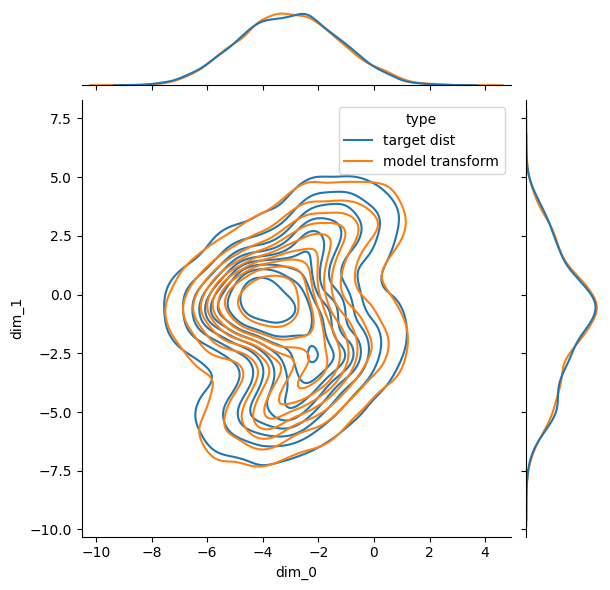

trail: 0 m step: 8 kl_test: 0.01112985610961914


  2%|▏         | 100/6000 [00:30<33:41,  2.92it/s]

trail: 0 m step: 9 Loss: 0.010137614819604181  L_n: 0.009381294250488281  kld: 0.0008020401000976562 KLD1: 0.008442679420113564 KLD2: 0.010300674475729465


  3%|▎         | 200/6000 [01:00<32:38,  2.96it/s]

trail: 0 m step: 9 Loss: 0.009752213408030161  L_n: 0.008402347564697266  kld: 0.0014314651489257812 KLD1: 0.009362056851387024 KLD2: 0.007439233362674713


  5%|▌         | 300/6000 [01:31<32:13,  2.95it/s]

trail: 0 m step: 9 Loss: 0.009489729491816402  L_n: 0.009287834167480469  kld: 0.00021409988403320312 KLD1: 0.009480899199843407 KLD2: 0.007602505385875702


  7%|▋         | 400/6000 [02:02<31:40,  2.95it/s]

trail: 0 m step: 9 Loss: 0.010385674853374731  L_n: 0.009473323822021484  kld: 0.0009675025939941406 KLD1: 0.00814906321465969 KLD2: 0.005997586529701948


  8%|▊         | 500/6000 [02:32<30:58,  2.96it/s]

trail: 0 m step: 9 Loss: 0.009553958957008215  L_n: 0.008568763732910156  kld: 0.0010447502136230469 KLD1: 0.008803622797131538 KLD2: 0.008261449635028839


 10%|█         | 600/6000 [03:03<30:32,  2.95it/s]

trail: 0 m step: 9 Loss: 0.008612547965920075  L_n: 0.0075225830078125  kld: 0.001155853271484375 KLD1: 0.0077455732971429825 KLD2: 0.00698623713105917


 12%|█▏        | 700/6000 [03:33<29:55,  2.95it/s]

trail: 0 m step: 9 Loss: 0.01083940768599202  L_n: 0.010562419891357422  kld: 0.000293731689453125 KLD1: 0.010288200341165066 KLD2: 0.007989875040948391


 13%|█▎        | 800/6000 [04:04<29:12,  2.97it/s]

trail: 0 m step: 9 Loss: 0.009225235913643846  L_n: 0.00855255126953125  kld: 0.000713348388671875 KLD1: 0.008626295253634453 KLD2: 0.00977048184722662


 15%|█▌        | 900/6000 [04:34<28:48,  2.95it/s]

trail: 0 m step: 9 Loss: 0.011332060473184219  L_n: 0.010141372680664062  kld: 0.001262664794921875 KLD1: 0.009871087037026882 KLD2: 0.006247764453291893


 17%|█▋        | 1000/6000 [05:05<28:16,  2.95it/s]

trail: 0 m step: 9 Loss: 0.010050631536881852  L_n: 0.009164810180664062  kld: 0.0009393692016601562 KLD1: 0.0058251842856407166 KLD2: 0.0062520867213606834


 18%|█▊        | 1100/6000 [05:35<27:26,  2.98it/s]

trail: 0 m step: 9 Loss: 0.010507551266499063  L_n: 0.008968830108642578  kld: 0.0016317367553710938 KLD1: 0.008960219100117683 KLD2: 0.007680526468902826


 20%|██        | 1200/6000 [06:06<27:07,  2.95it/s]

trail: 0 m step: 9 Loss: 0.010506524539383074  L_n: 0.00983428955078125  kld: 0.0007128715515136719 KLD1: 0.008446131832897663 KLD2: 0.00856797955930233


 22%|██▏       | 1300/6000 [06:36<26:35,  2.95it/s]

trail: 0 m step: 9 Loss: 0.01023414511758451  L_n: 0.00888967514038086  kld: 0.0014257431030273438 KLD1: 0.009298160672187805 KLD2: 0.010772928595542908


 23%|██▎       | 1400/6000 [07:07<26:00,  2.95it/s]

trail: 0 m step: 9 Loss: 0.009397637526818721  L_n: 0.00887918472290039  kld: 0.0005497932434082031 KLD1: 0.01068065594881773 KLD2: 0.008199416100978851


 25%|██▌       | 1500/6000 [07:37<25:21,  2.96it/s]

trail: 0 m step: 9 Loss: 0.00957022153761063  L_n: 0.008152008056640625  kld: 0.0015039443969726562 KLD1: 0.009549877606332302 KLD2: 0.008162573911249638


 27%|██▋       | 1600/6000 [08:08<24:59,  2.93it/s]

trail: 0 m step: 9 Loss: 0.0090731017751371  L_n: 0.006798744201660156  kld: 0.0024118423461914062 KLD1: 0.01122796256095171 KLD2: 0.008373874239623547


 28%|██▊       | 1700/6000 [08:38<24:11,  2.96it/s]

trail: 0 m step: 9 Loss: 0.009424720719755602  L_n: 0.008636474609375  kld: 0.0008358955383300781 KLD1: 0.008386979810893536 KLD2: 0.006936497986316681


 30%|███       | 1800/6000 [09:09<23:32,  2.97it/s]

trail: 0 m step: 9 Loss: 0.007853610702963362  L_n: 0.006230354309082031  kld: 0.0017213821411132812 KLD1: 0.008907979354262352 KLD2: 0.008006096817553043


 32%|███▏      | 1900/6000 [09:39<23:09,  2.95it/s]

trail: 0 m step: 9 Loss: 0.011711136129102932  L_n: 0.010772705078125  kld: 0.0009951591491699219 KLD1: 0.007052621338516474 KLD2: 0.008546587079763412


 33%|███▎      | 2000/6000 [10:10<22:31,  2.96it/s]

trail: 0 m step: 9 Loss: 0.00852544923762578  L_n: 0.0076274871826171875  kld: 0.0009522438049316406 KLD1: 0.00883394293487072 KLD2: 0.0093789491802454


 35%|███▌      | 2100/6000 [10:40<22:04,  2.94it/s]

trail: 0 m step: 9 Loss: 0.008453367598451072  L_n: 0.007538318634033203  kld: 0.0009703636169433594 KLD1: 0.0069459606893360615 KLD2: 0.0073128147050738335


 37%|███▋      | 2200/6000 [11:11<21:25,  2.96it/s]

trail: 0 m step: 9 Loss: 0.011187150008644266  L_n: 0.009855270385742188  kld: 0.0014123916625976562 KLD1: 0.008154831826686859 KLD2: 0.00814503338187933


 38%|███▊      | 2300/6000 [11:41<20:37,  2.99it/s]

trail: 0 m step: 9 Loss: 0.007795034789450992  L_n: 0.006772518157958984  kld: 0.0010843276977539062 KLD1: 0.007486865855753422 KLD2: 0.00793491955846548


 40%|████      | 2400/6000 [12:12<20:13,  2.97it/s]

trail: 0 m step: 9 Loss: 0.00672455081139648  L_n: 0.006522655487060547  kld: 0.00021409988403320312 KLD1: 0.008452939800918102 KLD2: 0.008060764521360397


 42%|████▏     | 2500/6000 [12:42<19:45,  2.95it/s]

trail: 0 m step: 9 Loss: 0.007156866747761149  L_n: 0.00620269775390625  kld: 0.0010118484497070312 KLD1: 0.0053590345196425915 KLD2: 0.005541856400668621


 43%|████▎     | 2600/6000 [13:12<19:13,  2.95it/s]

trail: 0 m step: 9 Loss: 0.010850179804799586  L_n: 0.010325431823730469  kld: 0.0005564689636230469 KLD1: 0.00745711475610733 KLD2: 0.009290726855397224


 45%|████▌     | 2700/6000 [13:43<18:33,  2.96it/s]

trail: 0 m step: 9 Loss: 0.010031023296988958  L_n: 0.009538650512695312  kld: 0.0005221366882324219 KLD1: 0.009315919131040573 KLD2: 0.008873307146131992


 47%|████▋     | 2800/6000 [14:13<18:01,  2.96it/s]

trail: 0 m step: 9 Loss: 0.009196092785270046  L_n: 0.008348941802978516  kld: 0.0008983612060546875 KLD1: 0.007716996595263481 KLD2: 0.009047550149261951


 48%|████▊     | 2900/6000 [14:44<17:36,  2.94it/s]

trail: 0 m step: 9 Loss: 0.01014607464369681  L_n: 0.009671688079833984  kld: 0.0005030632019042969 KLD1: 0.010328669100999832 KLD2: 0.004990518093109131


 50%|█████     | 3000/6000 [15:15<16:50,  2.97it/s]

trail: 0 m step: 9 Loss: 0.008319970725395875  L_n: 0.006791591644287109  kld: 0.0016207695007324219 KLD1: 0.0073045287281274796 KLD2: 0.008360203355550766


 52%|█████▏    | 3100/6000 [15:45<16:22,  2.95it/s]

trail: 0 m step: 9 Loss: 0.012089832247426477  L_n: 0.010742664337158203  kld: 0.0014286041259765625 KLD1: 0.00876415241509676 KLD2: 0.008316373452544212


 53%|█████▎    | 3200/6000 [16:16<15:46,  2.96it/s]

trail: 0 m step: 9 Loss: 0.008019808181541351  L_n: 0.006771564483642578  kld: 0.001323699951171875 KLD1: 0.007000206504017115 KLD2: 0.006297121290117502


 55%|█████▌    | 3300/6000 [16:46<15:14,  2.95it/s]

trail: 0 m step: 9 Loss: 0.009480895381668845  L_n: 0.008115291595458984  kld: 0.0014481544494628906 KLD1: 0.007707838434726 KLD2: 0.0076491390354931355


 57%|█████▋    | 3400/6000 [17:17<14:38,  2.96it/s]

trail: 0 m step: 9 Loss: 0.01117675295037396  L_n: 0.010043621063232422  kld: 0.001201629638671875 KLD1: 0.008125816471874714 KLD2: 0.007421061396598816


 58%|█████▊    | 3500/6000 [17:47<14:05,  2.96it/s]

trail: 0 m step: 9 Loss: 0.008415400625232914  L_n: 0.008221149444580078  kld: 0.00020599365234375 KLD1: 0.0077446820214390755 KLD2: 0.007828294299542904


 60%|██████    | 3600/6000 [18:17<13:37,  2.94it/s]

trail: 0 m step: 9 Loss: 0.009696740835637641  L_n: 0.008967399597167969  kld: 0.0007734298706054688 KLD1: 0.006835902109742165 KLD2: 0.009608413092792034


 62%|██████▏   | 3700/6000 [18:48<12:41,  3.02it/s]

trail: 0 m step: 9 Loss: 0.007972728175477907  L_n: 0.007065773010253906  kld: 0.0009617805480957031 KLD1: 0.008667628280818462 KLD2: 0.008051035925745964


 63%|██████▎   | 3800/6000 [19:18<12:24,  2.95it/s]

trail: 0 m step: 9 Loss: 0.007980386681071686  L_n: 0.007523536682128906  kld: 0.000484466552734375 KLD1: 0.007569287903606892 KLD2: 0.007398693822324276


 65%|██████▌   | 3900/6000 [19:49<11:51,  2.95it/s]

trail: 0 m step: 9 Loss: 0.011373491173639578  L_n: 0.010457992553710938  kld: 0.0009708404541015625 KLD1: 0.005763649474829435 KLD2: 0.008684326894581318


 67%|██████▋   | 4000/6000 [20:19<11:15,  2.96it/s]

trail: 0 m step: 9 Loss: 0.010518054578448222  L_n: 0.009539604187011719  kld: 0.00103759765625 KLD1: 0.009329808875918388 KLD2: 0.008267665281891823


 68%|██████▊   | 4100/6000 [20:49<10:41,  2.96it/s]

trail: 0 m step: 9 Loss: 0.008010296765341563  L_n: 0.007330417633056641  kld: 0.000720977783203125 KLD1: 0.0060157980769872665 KLD2: 0.008168173022568226


 70%|███████   | 4200/6000 [21:20<10:10,  2.95it/s]

trail: 0 m step: 9 Loss: 0.01008018007331088  L_n: 0.009391307830810547  kld: 0.0007305145263671875 KLD1: 0.005852208007127047 KLD2: 0.006143203936517239


 72%|███████▏  | 4300/6000 [21:50<09:36,  2.95it/s]

trail: 0 m step: 9 Loss: 0.009763727305233406  L_n: 0.009235382080078125  kld: 0.0005602836608886719 KLD1: 0.008212851360440254 KLD2: 0.006449818145483732


 73%|███████▎  | 4400/6000 [22:20<09:01,  2.95it/s]

trail: 0 m step: 9 Loss: 0.009653981400328616  L_n: 0.008698463439941406  kld: 0.0010132789611816406 KLD1: 0.008483465760946274 KLD2: 0.0074340770952403545


 75%|███████▌  | 4500/6000 [22:51<08:25,  2.97it/s]

trail: 0 m step: 9 Loss: 0.009615715354256761  L_n: 0.008358478546142578  kld: 0.0013332366943359375 KLD1: 0.00583178736269474 KLD2: 0.00791055429726839


 77%|███████▋  | 4600/6000 [23:22<07:55,  2.94it/s]

trail: 0 m step: 9 Loss: 0.011255554944460221  L_n: 0.00965118408203125  kld: 0.00170135498046875 KLD1: 0.0065991757437586784 KLD2: 0.007468635216355324


 78%|███████▊  | 4700/6000 [23:52<07:19,  2.96it/s]

trail: 0 m step: 9 Loss: 0.008785336066658909  L_n: 0.008463382720947266  kld: 0.0003414154052734375 KLD1: 0.009241881780326366 KLD2: 0.008708793669939041


 80%|████████  | 4800/6000 [24:22<06:44,  2.96it/s]

trail: 0 m step: 9 Loss: 0.008467198423681778  L_n: 0.0078125  kld: 0.00069427490234375 KLD1: 0.006293993443250656 KLD2: 0.007997953332960606


 82%|████████▏ | 4900/6000 [24:53<06:06,  3.00it/s]

trail: 0 m step: 9 Loss: 0.008268505825698439  L_n: 0.006882667541503906  kld: 0.0014696121215820312 KLD1: 0.008121971972286701 KLD2: 0.00630979286506772


 83%|████████▎ | 5000/6000 [25:24<05:38,  2.96it/s]

trail: 0 m step: 9 Loss: 0.010270462733438544  L_n: 0.00932168960571289  kld: 0.0010061264038085938 KLD1: 0.006316676270216703 KLD2: 0.0071606868878006935


 85%|████████▌ | 5100/6000 [25:54<05:03,  2.96it/s]

trail: 0 m step: 9 Loss: 0.0077418363650723805  L_n: 0.006699085235595703  kld: 0.0011057853698730469 KLD1: 0.0074229673482477665 KLD2: 0.008118261583149433


 87%|████████▋ | 5200/6000 [26:25<04:32,  2.94it/s]

trail: 0 m step: 9 Loss: 0.00981374802450521  L_n: 0.009513378143310547  kld: 0.0003185272216796875 KLD1: 0.009444329887628555 KLD2: 0.00841127336025238


 88%|████████▊ | 5300/6000 [26:55<03:57,  2.95it/s]

trail: 0 m step: 9 Loss: 0.010112380984161609  L_n: 0.009001731872558594  kld: 0.0011777877807617188 KLD1: 0.007997819222509861 KLD2: 0.00739521998912096


 90%|█████████ | 5400/6000 [27:26<03:22,  2.97it/s]

trail: 0 m step: 9 Loss: 0.011076621936718444  L_n: 0.0091705322265625  kld: 0.002021312713623047 KLD1: 0.006114261690527201 KLD2: 0.00678028492256999


 92%|█████████▏| 5500/6000 [27:56<02:49,  2.95it/s]

trail: 0 m step: 9 Loss: 0.011083978740293033  L_n: 0.010104179382324219  kld: 0.0010390281677246094 KLD1: 0.009558108635246754 KLD2: 0.0075714061968028545


 93%|█████████▎| 5600/6000 [28:27<02:15,  2.94it/s]

trail: 0 m step: 9 Loss: 0.009101557868860513  L_n: 0.008244514465332031  kld: 0.0009088516235351562 KLD1: 0.00808086059987545 KLD2: 0.006772087886929512


 95%|█████████▌| 5700/6000 [28:57<01:29,  3.34it/s]

trail: 0 m step: 9 Loss: 0.009775638580322266  L_n: 0.009775638580322266  kld: 0.0 KLD1: 0.008465049788355827 KLD2: 0.006515083834528923


 97%|█████████▋| 5800/6000 [29:27<01:07,  2.98it/s]

trail: 0 m step: 9 Loss: 0.008359193455400055  L_n: 0.007945060729980469  kld: 0.0004391670227050781 KLD1: 0.009000697173178196 KLD2: 0.00882751401513815


 98%|█████████▊| 5900/6000 [29:57<00:33,  2.94it/s]

trail: 0 m step: 9 Loss: 0.00987880622082986  L_n: 0.00890350341796875  kld: 0.0010342597961425781 KLD1: 0.007534670643508434 KLD2: 0.006958614103496075


100%|██████████| 6000/6000 [30:28<00:00,  3.28it/s]

trail: 0 m step: 9 Loss: 0.007929120239330505  L_n: 0.007192134857177734  kld: 0.0007815361022949219 KLD1: 0.0065871719270944595 KLD2: 0.007333934772759676



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


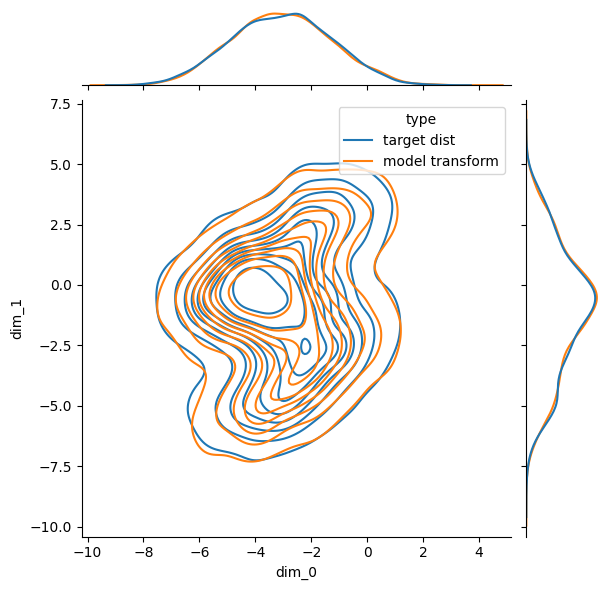

trail: 0 m step: 9 kl_test: 0.006702899932861328


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = (eta*(1.3**mirror_itr))
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )
